In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from scipy.stats import beta
from tqdm import tqdm
import math

random.seed(1504)


# Bandido Bernoulli
     Libro-MAB pag 70 ej 4.8


In [2]:
class BernoulliBandit :
    #Parametro de entrada means, con las medias de cada brazo en una lista
    # Ej: BernoulliBandit([0.5,0.8]) -> Entorno de dos brazos con medias 0.5,0.8
    def __init__ (self , means ):
        self.means = means #Guardar las medias de cada acción
        self.acumregret = 0 #Guardar la "pérdida acumulada" (Corresponde, según la definición, al pseudoregret)
        self.bestarm = max(means) #Guardar la media mejor acción
        self.frecuencyacum = [0]*len(means) #Guardar la frecuencia de cada acción
    # Devolver el numero de brazos (es decir, K)
    def K( self ):
        return(len(self.means))

    # Acepta parámetro 0 <= a <= K -1 y devuelve
    # una v.a X-Ber(mu_a), recompensa del brazo a+1
    def pull (self , a):
        if a < 0 or a >= self.K():
            raise ValueError("Valor de a no valido") #Error por parametro fuera de índice, recuerda [0,k-1] en python
        self.frecuencyacum[a] += 1 #Aumenta la frecuencia de la acción a
        naleatorio = random.random() #número aleatorio entre (0,1) para recompensa
        #Si la media del brazo a es mayor al número aleatorio => la v.a. X = 1
        # Si por el contario, la media es menor que el número aleatorio => la
        # v.a. X = 0
        if self.means[a] >= naleatorio: #P(X_a=1)
            reward = 1
        else: #P(X_a=0)
            reward = 0
        self.acumregret += (self.bestarm -self.means[a]) #añadimos el valor de esta acción a la 
        return(reward)
    def frecuency (self): #Devuelve la frecuencia de jugar cada acción
        return(self.frecuencyacum)
    def pseudoregret ( self ): #Devuelve la "pérdida acumulada"
        return(self.acumregret)

Veamos un ejemplo de implementacion del codigo anterior para el caso de K = 3

In [3]:
bandido = BernoulliBandit([0,0.5,1])

print("Numero de acciones: ",bandido.K())
print("Jugando la accion 1 obtenemos recompensa: ",bandido.pull(0))
print("Jugando la accion 2 obtenemos recompensa: ",bandido.pull(1))
print("Jugando la accion 3 obtenemos recompensa: ",bandido.pull(2))
print("Obtuvimos una pseudoperdida acumulada de: ",bandido.pseudoregret())

Numero de acciones:  3
Jugando la accion 1 obtenemos recompensa:  0
Jugando la accion 2 obtenemos recompensa:  1
Jugando la accion 3 obtenemos recompensa:  1
Obtuvimos una pseudoperdida acumulada de:  1.5


Observamos que aunque la recompensa al elegir la accion 2 sea 1 o 0 (50% de que ocurra cada una), la perdida acumulada siempre añadira 0,5.


# def ETC y caso bernoulli
Libro-MAB pag 71 ej 4.12


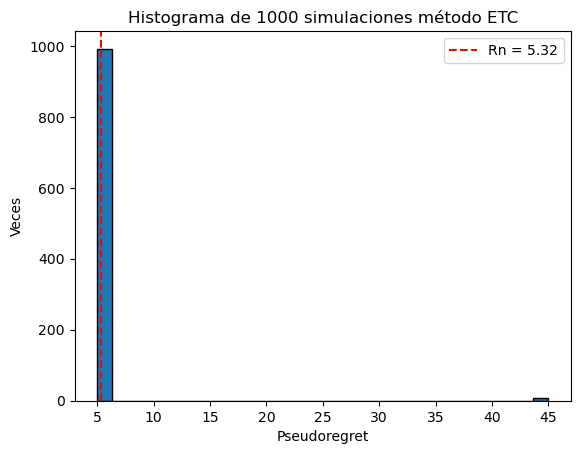

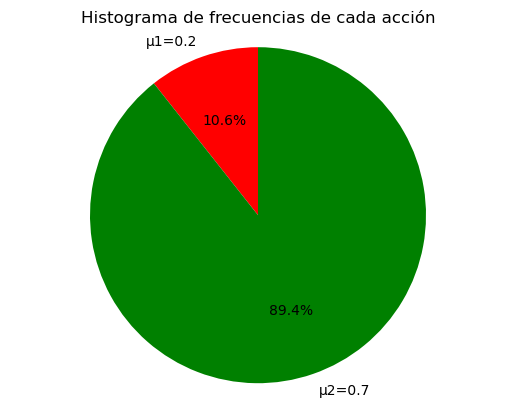

In [3]:

n = 100 #horizonte
m = 10 #número de rondas dedicadas a explorar cada opción (debe verificar que n>= m*K)
simula = 1000 #número de simulaciones

def ETC(n,m): #Parametros de entrada: n = horizonte, m = exploración. CUIDADO, verificar n>= m*K
    recompensas = np.zeros(bandido.K()) #para ir acumulando las recompensas
    veces = np.zeros(bandido.K()) #para ir acumulando las veces que se ha jugado cada acción
    mediasmuestrales = [0 for _ in range(bandido.K())] #para ir acumulando las medias muestrales
    for t in range(n):
        if t< m*bandido.K():
            At = t%bandido.K()
            recompensas[At] += bandido.pull(At) #conseguimos recompensa Xt
            veces[At] += 1 #T_At(t) sube en 1
            mediasmuestrales[At] = recompensas[At]/veces[At] #actualizamos la media muestral de At
        else:
            At = mediasmuestrales.index(max(mediasmuestrales))
            bandido.pull(At)
            # Ya no hace falta actualizar mas las medias, siempre vamos a jugar la misma accion
    return(mediasmuestrales,sum(recompensas))


# Simulaciones 2 BRAZOS
pseudoregret_valores_ETC = [] #lista acumuladora del pseudoregret
frecuencias_ETC = [0,0] #Lista acumuladora de las frecuencias
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])  # El entorno se resetea cada simulación
    ETC(n, m) # Jugamos segun la política ETC
    pseudoregret_valores_ETC.append(bandido.pseudoregret()) # Acumulamos pseudoregret
    frecuencias_ETC[0] += bandido.frecuency()[0] #Acumulamos frecuencia de la accion 1
    frecuencias_ETC[1] += bandido.frecuency()[1] #Acumulamos frecuencia de la accion 2


#GRAFICA
plt.hist(pseudoregret_valores_ETC, bins=30, edgecolor='black')
real_regret_ETC = np.mean(pseudoregret_valores_ETC)
plt.axvline(real_regret_ETC, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETC:.2f}")
plt.xlabel("Pseudoregret")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones método ETC")
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.pie([frecuencias_ETC[0] / simula, frecuencias_ETC[1] / simula], labels = ["μ1=0.2", "μ2=0.7"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Histograma de frecuencias de cada acción")
plt.show()

#### Gráfica frecuencias relativas por rondas

Vamos a implementar el método anterior, pero con la variación para que devuelva las frecuencias de jugar cada brazo y el orden en el que se juegan

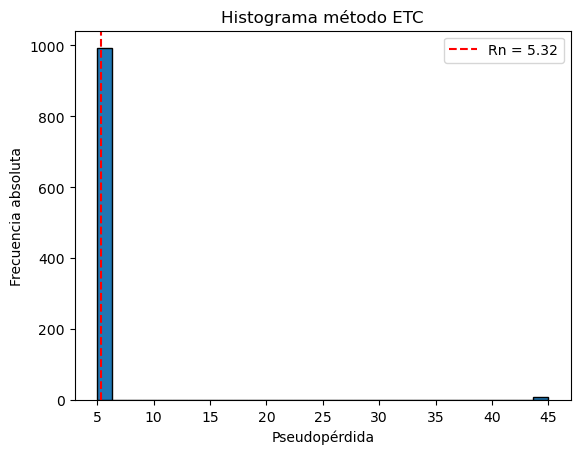

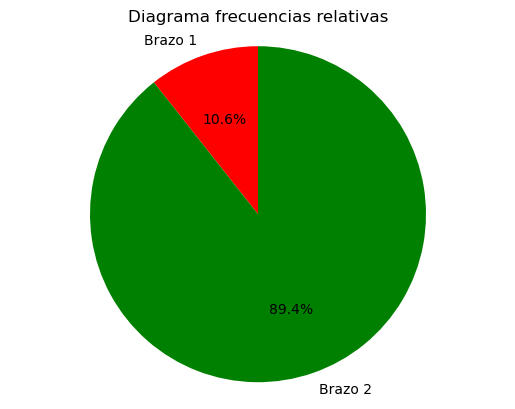

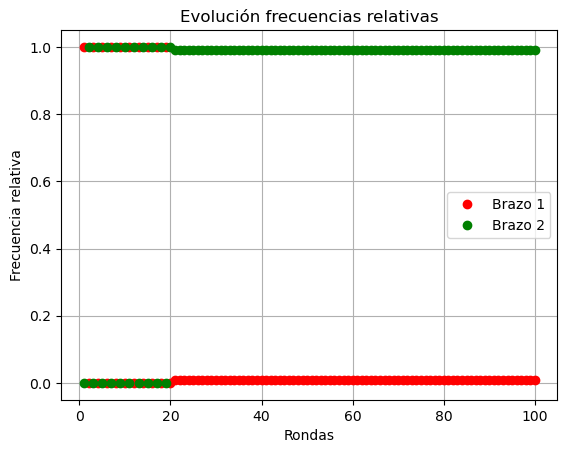

In [3]:

n = 100 #horizonte
m = 10 #numero de rondas dedicadas a explorar cada opcion (debe verificar que n>= m*K)
simula = 1000 #numero de simulaciones

def ETCrondas(n,m): #Modificamos el metodo ETC para ir guardando en cada ronda el brazo jugado
    brazosjugados = np.zeros(n, dtype=int) #para ir acumulandoen cada ronda el brazo jugado
    recompensas = np.zeros(bandido.K()) #para ir acumulando las recompensas
    veces = np.zeros(bandido.K()) #para ir acumulando las veces que se ha jugado cada accion
    mediasmuestrales = [0 for _ in range(bandido.K())] #para ir acumulando las medias muestrales
    for t in range(n):
        if t< m*bandido.K():
            At = t%bandido.K()
            recompensas[At] += bandido.pull(At) #conseguimos recompensa Xt
            veces[At] += 1 #T_At(t) sube en 1
            mediasmuestrales[At] = recompensas[At]/veces[At] #actualizamos la media muestral de At
        else:
            At = mediasmuestrales.index(max(mediasmuestrales))
            bandido.pull(At)
            # Ya no hace falta actualizar mas las medias, siempre vamos a jugar la misma accion
        brazosjugados[t] = At #Guardamos el brazo jugado en cada ronda
    return(brazosjugados)


# Simulaciones 2 BRAZOS
K = 2
pseudoregret_valores_ETCrondas = [] #lista acumuladora del pseudoregret
frecuencias_ETCrondas = [0,0] #lista acumuladora de las frecuencias acción 1 y 2
acumbrazos = np.zeros((n,K))
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])
    brazosjugados = ETCrondas(n, m)
    pseudoregret_valores_ETCrondas.append(bandido.pseudoregret())
    frecuencias_ETCrondas[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_ETCrondas[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_ETCrondas, bins=30, edgecolor='black')
real_regret_ETCrondas = np.mean(pseudoregret_valores_ETCrondas)
plt.axvline(real_regret_ETCrondas, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETCrondas:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta")
plt.title("Histograma método ETC")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_ETCrondas[0] / simula, frecuencias_ETCrondas[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1 = acumbrazos[:,0] / simula
brazo2 = acumbrazos[:,1] / simula
plt.plot(x, brazo1, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
print("A partir de la ronda 20, la probabilidad de elegir el brazo 2 es de:", brazo2[20])

A partir de la ronda 20, la probabilidad de elegir el brazo 2 es de: 0.987


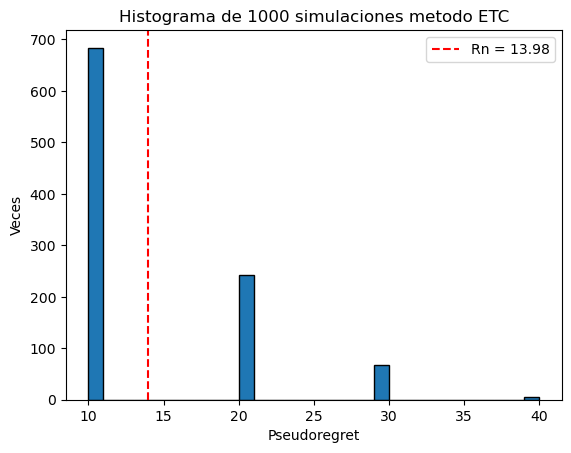

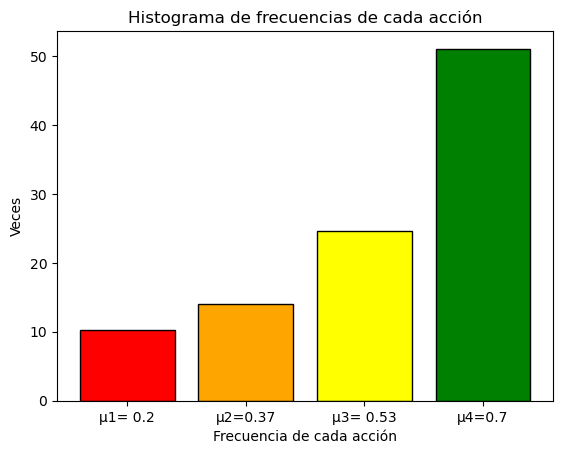

In [ ]:
# Simulaciones 4 BRAZOS
n=100
simula = 1000
m = 10
pseudoregret_valores_ETC = [] #
frecuencias_ETC = [0,0,0,0] #
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.37, 0.53, 0.7])
    ETC(n, m)
    pseudoregret_valores_ETC.append(bandido.pseudoregret())
    frecuencias_ETC[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_ETC[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    frecuencias_ETC[2] += bandido.frecuency()[2] #frecuencia de la accion 3
    frecuencias_ETC[3] += bandido.frecuency()[3] #frecuencia de la accion 4

plt.hist(pseudoregret_valores_ETC, bins=30, edgecolor='black')
real_regret_ETC = np.mean(pseudoregret_valores_ETC)
plt.axvline(real_regret_ETC, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETC:.2f}")
plt.xlabel("Pseudoregret")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones metodo ETC")
plt.legend()
plt.show()
plt.bar(["μ1= 0.2", "μ2=0.37","μ3= 0.53", "μ4=0.7"], [frecuencias_ETC[0] / simula, frecuencias_ETC[1] / simula,frecuencias_ETC[2] / simula,frecuencias_ETC[3] / simula], color=['red','orange','yellow', 'green'], edgecolor='black')
plt.xlabel("Frecuencia de cada acción")
plt.ylabel("Veces")
plt.title("Histograma de frecuencias de cada acción")
plt.show()

#### Comparacion estimador variando $\Delta$, m y n

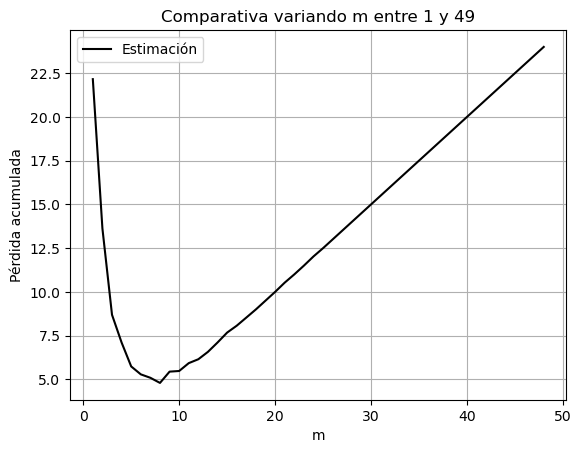

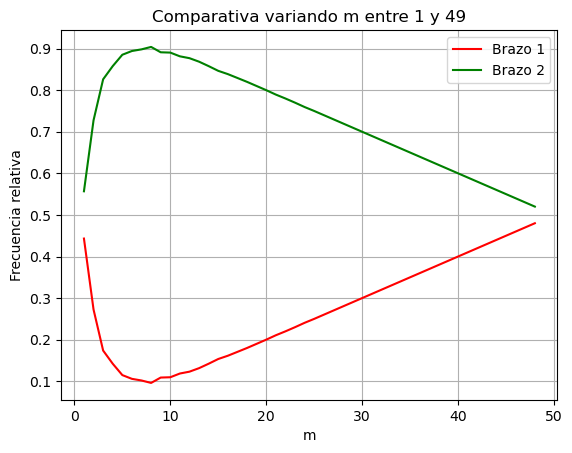

In [62]:

# COMPARACION VARIANDO M
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
regret_real_valores = []
frecuencias_ETC_ParaCadaM_brazo1 = []
frecuencias_ETC_ParaCadaM_brazo2 = []
m_values = range(1,49)  # valores de m desde 1 hasta 49
for m in m_values:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_ETC_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_ETC_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.7])
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_ETC_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_ETC_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_ETC_ParaCadaM_brazo1.append(np.mean(frecuencias_ETC_brazo1)/n) #Acumulamos frecuencia de la accion 1
    frecuencias_ETC_ParaCadaM_brazo2.append(np.mean(frecuencias_ETC_brazo2)/n) #Acumulamos frecuencia de la accion 2



#GRAFICA PSEUDOREGRETS
plt.plot(m_values, regret_valores, 'k-', label='Estimación')
plt.xlabel('m')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando m entre 1 y 49')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(m_values, frecuencias_ETC_ParaCadaM_brazo1, 'red', label='Brazo 1')
plt.plot(m_values, frecuencias_ETC_ParaCadaM_brazo2, 'green', label='Brazo 2')
plt.xlabel('m')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando m entre 1 y 49')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
#veamos cuando se alcanza el valor real minimo, el valor de m
minimo = min(regret_valores)
print("Valor de m = ",regret_valores.index(minimo) + 1,"para el cual se alcanza el valor minimo de la perdida real = ",minimo)
print("La mayor frecuencia relativa para el brazo 1 es:",frecuencias_ETC_ParaCadaM_brazo2[7])

Valor de m =  8 para el cual se alcanza el valor minimo de la perdida real =  4.797999999999999
La mayor frecuencia relativa para el brazo 1 es: 0.90404


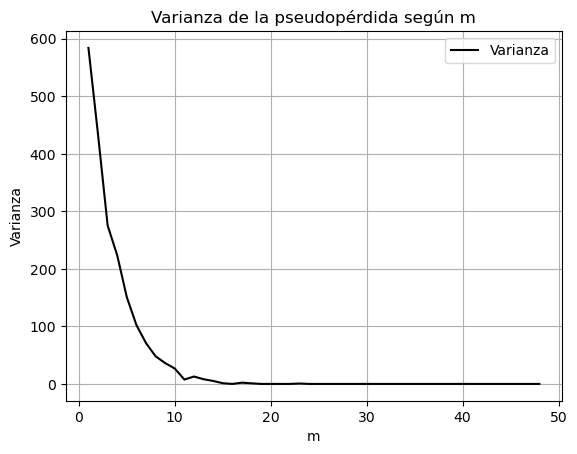

In [ ]:
# VARIANZA DEl pseudoREGRET variando m

m_values = range(1, 49)  # Valores de m desde 1 hasta 49
simula = 1000
n= 100
varianza = [] #varianza de cada m
for m in m_values:
    pseudoregret_valores_ETC = [] #
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.7])
        ETC(n, m)
        pseudoregret_valores_ETC.append(bandido.pseudoregret())
    varianza.append(np.var(pseudoregret_valores_ETC))

# Graficar la varianza
plt.plot(m_values, varianza, 'k-', label='Varianza')
plt.xlabel('m')
plt.ylabel('Varianza')
plt.title('Varianza de la pseudopérdida según m')
plt.legend()
plt.grid(True)
plt.show()

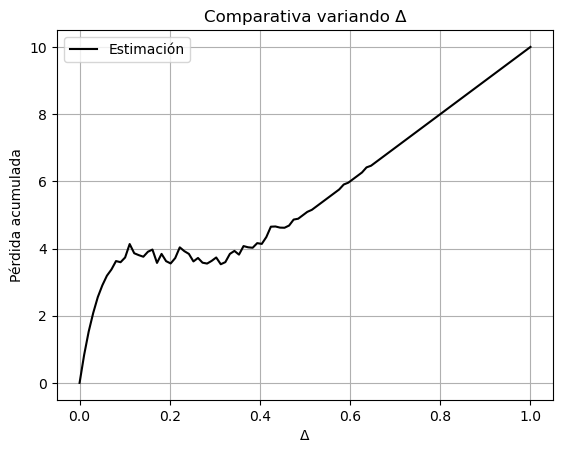

In [68]:

# COMPARACION VARIANDO DELTA
n = 100
simula = 1000
m=10
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de regret real
triangulovalores = np.linspace(0,1,100)  # valores de DELTA
for triangulo in triangulovalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = BernoulliBandit([0, 0+triangulo])
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))


# GRAFICA
plt.plot(triangulovalores, regret_valores, 'k-', label='Estimación')
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando Δ')
plt.legend()
plt.grid(True)
plt.show()

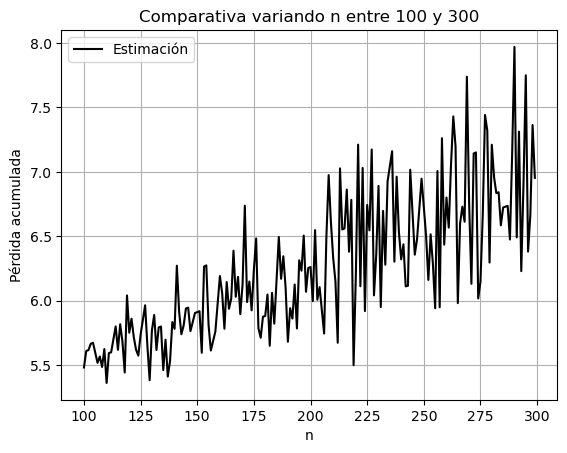

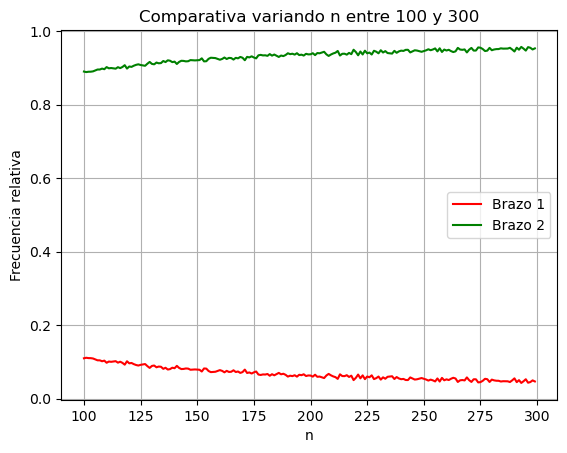

In [24]:

# COMPARACION VARIANDO N
simula = 1000
m=10
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de las regret real
frecuencias_ETC_ParaCadaN_brazo1 = []
frecuencias_ETC_ParaCadaN_brazo2 = []
nvalores = range(100,300)  # valores de n desde 100 hasta 200
for n in nvalores:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_ETC_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_ETC_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.7])
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_ETC_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_ETC_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_ETC_ParaCadaN_brazo1.append(np.mean(frecuencias_ETC_brazo1)/(n)) #Acumulamos frecuencia de la accion 1
    frecuencias_ETC_ParaCadaN_brazo2.append(np.mean(frecuencias_ETC_brazo2)/(n)) #Acumulamos frecuencia de la accion 2


# GRAFICA PSEUDOREGRETS
plt.plot(nvalores, regret_valores, 'k-', label='Estimación')
plt.xlabel('n')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando n entre 100 y 300')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(nvalores, frecuencias_ETC_ParaCadaN_brazo1, 'red', label='Brazo 1')
plt.plot(nvalores, frecuencias_ETC_ParaCadaN_brazo2, 'green', label='Brazo 2')
plt.xlabel('n')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando n entre 100 y 300')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
frecuencias_ETC_ParaCadaN_brazo1

[11.6,
 10.972,
 11.64,
 11.411,
 11.092,
 11.19,
 11.032,
 11.392,
 10.968,
 11.691,
 11.62,
 10.728,
 11.564,
 10.558,
 11.316,
 10.95,
 11.344,
 11.94,
 11.274,
 11.089,
 11.6,
 11.212,
 11.326,
 11.133,
 11.664,
 11.155,
 11.272,
 11.284,
 11.62,
 11.853,
 10.99,
 10.888,
 10.896,
 11.017,
 11.71,
 11.495,
 11.392,
 10.819,
 11.416,
 12.499,
 11.56,
 10.847,
 12.318,
 11.353,
 10.868,
 11.125,
 11.638,
 11.27,
 11.92,
 12.064,
 11.43,
 12.358,
 12.244,
 11.463,
 12.278,
 10.945,
 11.768,
 11.644,
 11.656,
 11.668,
 12.52,
 12.397,
 10.852,
 13.146,
 12.448,
 12.32,
 12.628,
 11.764,
 12.22,
 12.235,
 11.2,
 11.963,
 11.52,
 11.989,
 11.232,
 11.705,
 12.496,
 12.355,
 11.264,
 11.272,
 12.24,
 11.771,
 11.62,
 12.445,
 12.296,
 12.145,
 11.66,
 11.837,
 13.192,
 11.859,
 11.36,
 12.394,
 12.58,
 11.557,
 12.262,
 12.975,
 11.584,
 11.593,
 11.958,
 12.685]

In [20]:
frecuencias_ETC_ParaCadaN_brazo2


[88.4,
 90.028,
 90.36,
 91.589,
 92.908,
 93.81,
 94.968,
 95.608,
 97.032,
 97.309,
 98.38,
 100.272,
 100.436,
 102.442,
 102.684,
 104.05,
 104.656,
 105.06,
 106.726,
 107.911,
 108.4,
 109.788,
 110.674,
 111.867,
 112.336,
 113.845,
 114.728,
 115.716,
 116.38,
 117.147,
 119.01,
 120.112,
 121.104,
 121.983,
 122.29,
 123.505,
 124.608,
 126.181,
 126.584,
 126.501,
 128.44,
 130.153,
 129.682,
 131.647,
 133.132,
 133.875,
 134.362,
 135.73,
 136.08,
 136.936,
 138.57,
 138.642,
 139.756,
 141.537,
 141.722,
 144.055,
 144.232,
 145.356,
 146.344,
 147.332,
 147.48,
 148.603,
 151.148,
 149.854,
 151.552,
 152.68,
 153.372,
 155.236,
 155.78,
 156.765,
 158.8,
 159.037,
 160.48,
 161.011,
 162.768,
 163.295,
 163.504,
 164.645,
 166.736,
 167.728,
 167.76,
 169.229,
 170.38,
 170.555,
 171.704,
 172.855,
 174.34,
 175.163,
 174.808,
 177.141,
 178.64,
 178.606,
 179.42,
 181.443,
 181.738,
 182.025,
 184.416,
 185.407,
 186.042,
 186.315]


 ## Implementacion Teorema Acotacion $R_n$ para ETC
Libro-MAB pag 92 th 6.1


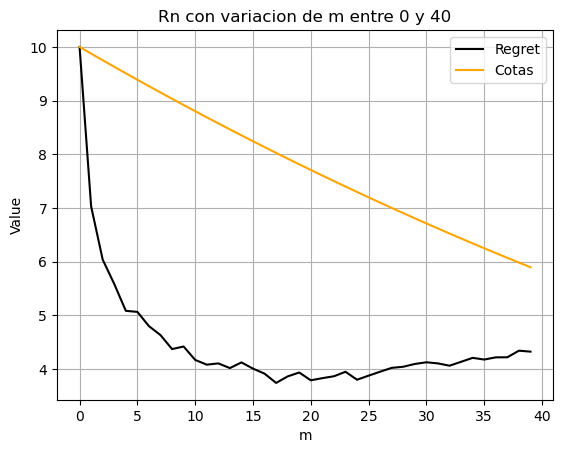

In [ ]:
# Simulaciones
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
cotas_valores = [] #acumulador de las cotas
m_values = range(40)  # valores de m desde 0 hasta 24
for m in m_values:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = BernoulliBandit([0.5, 0.6])
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    cotas_valores.append(m*0.1+(n-m*bandido.K())*0.1*np.exp(-m*0.1**2/4))

# GRAFICAS
plt.plot(m_values, regret_valores, 'k-', label='Regret')  # NEGRO para regret
plt.plot(m_values, cotas_valores, 'orange', label='Cotas')  # NARANJA para cotas
plt.xlabel('m')
plt.ylabel('Value')
plt.title('Rn con variacion de m entre 0 y 40')
plt.legend()
plt.grid(True)
plt.show()

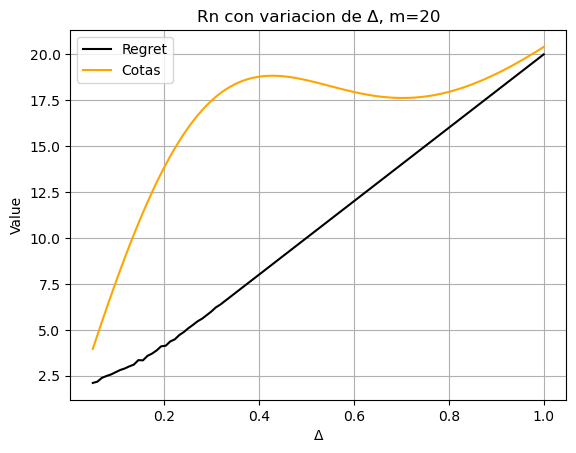

In [ ]:
# Simulaciones
n = 100
simula = 1000
m=20
regret_valores = [] #acumulador de regret
cotas_valores = [] #acumulador de las cotas
triangulovalores = np.linspace(0.05,1,100)  # 100 valores de DElTA desde 0.05 hasta 1
for triangulo in triangulovalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = BernoulliBandit([0, triangulo])
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    cotas_valores.append(m*triangulo+(n-m*bandido.K())*triangulo*np.exp(-m*triangulo**2/4))

# GRAFICAS
plt.plot(triangulovalores, regret_valores, 'k-', label='Regret')  # NEGRO para regret
plt.plot(triangulovalores, cotas_valores, 'orange', label='Cotas')  # NARANJA para cotas
plt.xlabel('Δ')
plt.ylabel('Value')
plt.title('Rn con variacion de Δ, m=20')
plt.legend()
plt.grid(True)
plt.show()

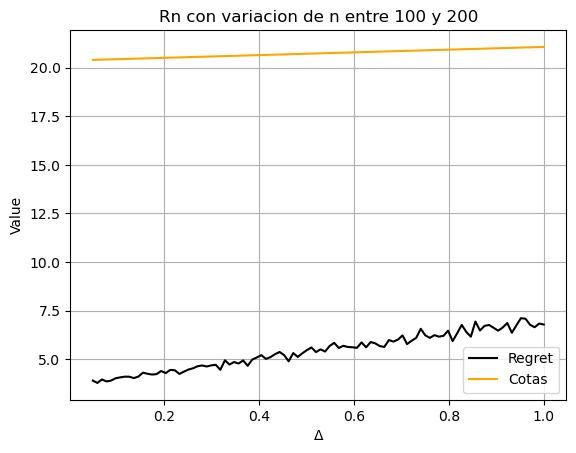

In [ ]:
# Simulaciones
simula = 1000
m=20
regret_valores = [] #acumulador de regret
cotas_valores = [] #acumulador de las cotas
nvalores = range(100,200)  # valores de n desde 100 hasta 200
for n in nvalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = BernoulliBandit([0.5, 0.6])
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    cotas_valores.append(m*triangulo+(n-m*bandido.K())*triangulo*np.exp(-m*triangulo**2/4))

# GRAFICAS
plt.plot(nvalores, regret_valores, 'k-', label='Regret')  # NEGRO regret
plt.plot(nvalores, cotas_valores, 'orange', label='Cotas')  # NARANJA cotas
plt.xlabel('Δ')
plt.ylabel('Value')
plt.title('Rn con variacion de n entre 100 y 200')
plt.legend()
plt.grid(True)
plt.show()




# def UCB y caso bernoulli
Libro-MAB pag 103


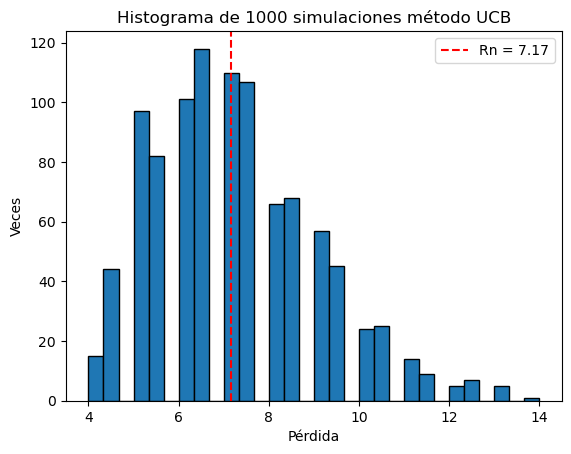

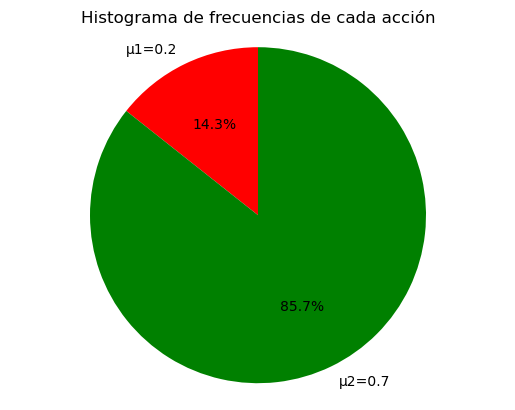

In [5]:
#bandido = BernoulliBandit([0.5,0.6]) #medias mu1 = 0.5 mu2 = 0.6
n = 100 #horizonte
simula = 1000 #numero de simulaciones

def UCB(n,delta):
    recompensas = np.zeros(bandido.K()) #para ir acumulando las recompensas
    veces = np.zeros(bandido.K()) #para ir acumulando las veces que se ha jugado cada accion
    mediasmuestrales = [0 for _ in range(bandido.K())] #para ir acumulando las medias muestrales
    UCBdelta = [0 for _ in range(bandido.K())] #para ir acumulando las cotas de confianza superiores
    for t in range(bandido.K()):
        At = t
        recompensas[At] += bandido.pull(At) #conseguimos recompensa Xt
        veces[At] += 1 #T_At(t) sube en 1
        mediasmuestrales[At] = recompensas[At]/veces[At] #actualizamos la media muestral de At
        UCBdelta[At] = mediasmuestrales[At] + np.sqrt(2*np.log(1/delta)/veces[At])
    for t in range(n-bandido.K()):
        At = UCBdelta.index(max(UCBdelta))
        recompensas[At] += bandido.pull(At) #conseguimos recompensa Xt
        veces[At] += 1 #T_At(t) sube en 1
        mediasmuestrales[At] = recompensas[At]/veces[At] #actualizamos la media muestral de At
        UCBdelta[At] = mediasmuestrales[At] + np.sqrt(2*np.log(1/delta)/veces[At])
    return(mediasmuestrales,sum(recompensas))


# Simulacion 2
pseudoregret_valores_UCB = []
frecuencias_UCB = [0,0] #frecuencia de cada accion
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
    #UCB(n,1/(n**2))
    UCB(n,1/n)
    pseudoregret_valores_UCB.append(bandido.pseudoregret())
    frecuencias_UCB[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_UCB[1] += bandido.frecuency()[1] #frecuencia de la accion 2

plt.hist(pseudoregret_valores_UCB, bins=30, edgecolor='black')
real_regret_UCB = np.mean(pseudoregret_valores_UCB)
plt.axvline(real_regret_UCB, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCB:.2f}")
plt.xlabel("Pérdida")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones método UCB")
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.pie([frecuencias_UCB[0] / simula, frecuencias_UCB[1] / simula], labels = ["μ1=0.2", "μ2=0.7"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Histograma de frecuencias de cada acción")
plt.show()

#### Gráficas frecuencias relativas por brazos

Vamos a implementar el método anterior, pero con la variación para que devuelva las frecuencias de jugar cada brazo y el orden en el que se juegan

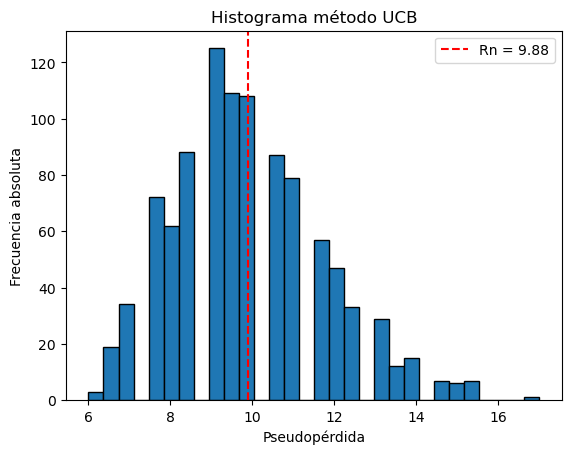

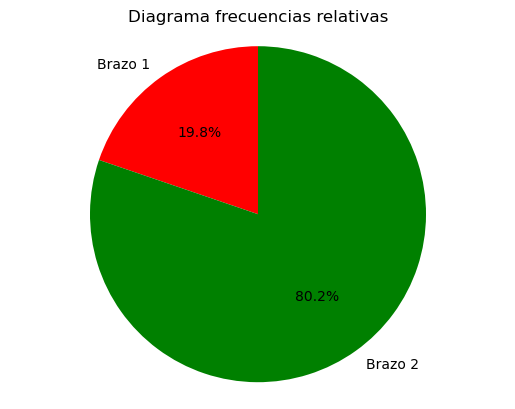

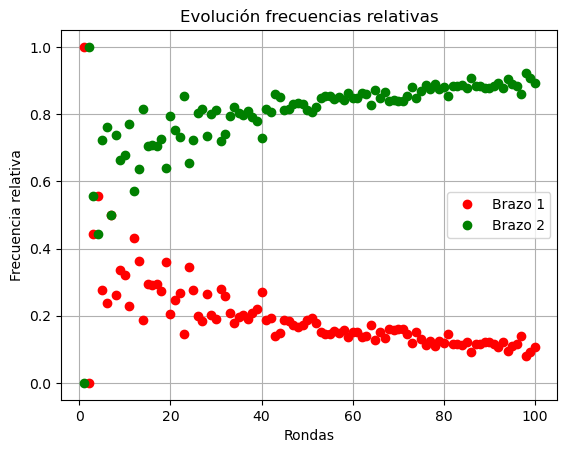

In [8]:
def UCBrondas(n,delta): #Nota: el entorno se define previamente fuera de la funcion como "bandido"
    brazosjugados = np.zeros(n, dtype=int) #para ir acumulandoen cada ronda el brazo jugado
    recompensas = np.zeros(bandido.K()) #para ir acumulando las recompensas
    veces = np.zeros(bandido.K()) #para ir acumulando las veces que se ha jugado cada accion
    mediasmuestrales = [0 for _ in range(bandido.K())] #para ir acumulando las medias muestrales
    UCBrondasdelta = [0 for _ in range(bandido.K())] #para ir acumulando las cotas de confianza superiores
    for t in range(bandido.K()):
        At = t
        recompensas[At] += bandido.pull(At) #conseguimos recompensa Xt
        veces[At] += 1 #T_At(t) sube en 1
        mediasmuestrales[At] = recompensas[At]/veces[At] #actualizamos la media muestral de At
        UCBrondasdelta[At] = mediasmuestrales[At] + np.sqrt(2*np.log(1/delta)/veces[At])
        brazosjugados[t] = At #Guardamos el brazo jugado en cada ronda
    for t in range(n-bandido.K()):
        At = UCBrondasdelta.index(max(UCBrondasdelta))
        recompensas[At] += bandido.pull(At) #conseguimos recompensa Xt
        veces[At] += 1 #T_At(t) sube en 1
        mediasmuestrales[At] = recompensas[At]/veces[At] #actualizamos la media muestral de At
        UCBrondasdelta[At] = mediasmuestrales[At] + np.sqrt(2*np.log(1/delta)/veces[At])
        brazosjugados[t+bandido.K()] = At
    return(brazosjugados)


# Simulacion 2
K = 2
pseudoregret_valores_UCBrondas = []
frecuencias_UCBrondas = [0,0] #frecuencia de cada accion
acumbrazos = np.zeros((n,K))
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
    brazosjugados = UCBrondas(n,1/(n**2))
    pseudoregret_valores_UCBrondas.append(bandido.pseudoregret())
    frecuencias_UCBrondas[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_UCBrondas[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_UCBrondas, bins=30, edgecolor='black')
real_regret_UCBrondas = np.mean(pseudoregret_valores_UCBrondas)
plt.axvline(real_regret_UCBrondas, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCBrondas:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta")
plt.title("Histograma método UCB")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_UCBrondas[0] / simula, frecuencias_UCBrondas[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1 = acumbrazos[:,0] / simula
brazo2 = acumbrazos[:,1] / simula
plt.plot(x, brazo1, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()

In [49]:
print("A partir de la segunda ronda, la probabilidad de elegir el brazo 2 es de:", brazo2[12])
print("A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2[99])

A partir de la segunda ronda, la probabilidad de elegir el brazo 2 es de: 0.629
A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.886


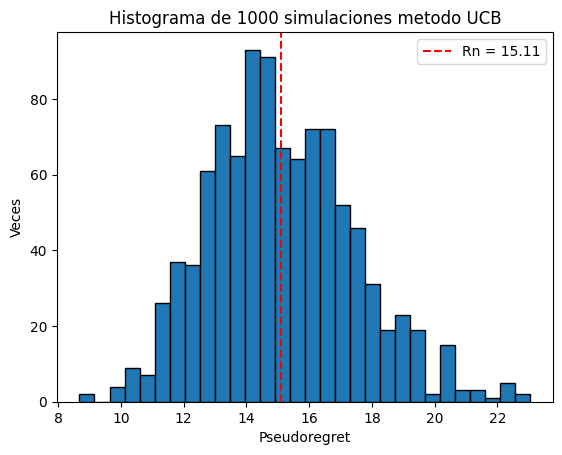

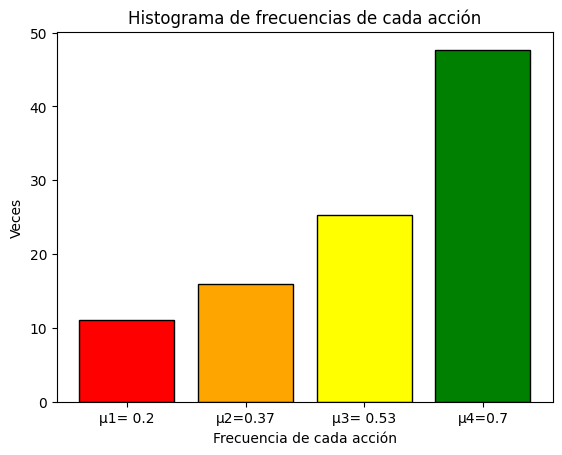

In [ ]:
# Simulaciones 4 BRAZOS
n=100
simula = 1000
pseudoregret_valores_UCB = [] #
frecuencias_UCB = [0,0,0,0] #
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.37, 0.53, 0.7])  # Reset the bandit for each simulation
    UCB(n, 1/n)
    pseudoregret_valores_UCB.append(bandido.pseudoregret())
    frecuencias_UCB[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_UCB[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    frecuencias_UCB[2] += bandido.frecuency()[2] #frecuencia de la accion 3
    frecuencias_UCB[3] += bandido.frecuency()[3] #frecuencia de la accion 4

plt.hist(pseudoregret_valores_UCB, bins=30, edgecolor='black')
real_regret_UCB = np.mean(pseudoregret_valores_UCB)
plt.axvline(real_regret_UCB, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCB:.2f}")
plt.xlabel("Pseudoregret")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones metodo UCB")
plt.legend()
plt.show()
plt.bar(["μ1= 0.2", "μ2=0.37","μ3= 0.53", "μ4=0.7"], [frecuencias_UCB[0] / simula, frecuencias_UCB[1] / simula,frecuencias_UCB[2] / simula,frecuencias_UCB[3] / simula], color=['red','orange','yellow', 'green'], edgecolor='black')
plt.xlabel("Frecuencia de cada acción")
plt.ylabel("Veces")
plt.title("Histograma de frecuencias de cada acción")
plt.show()

#### Comparacion estimador variando $\Delta$, $\delta$ y n

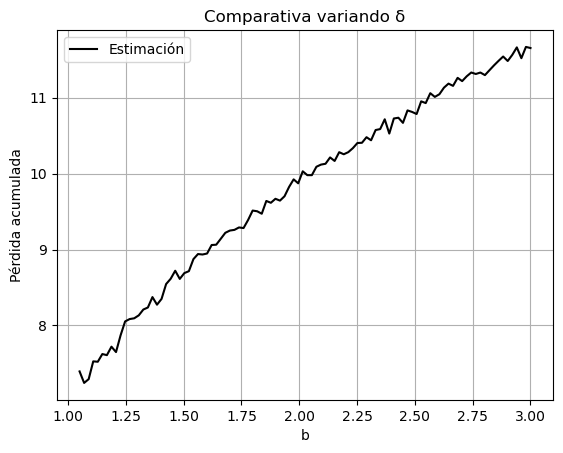

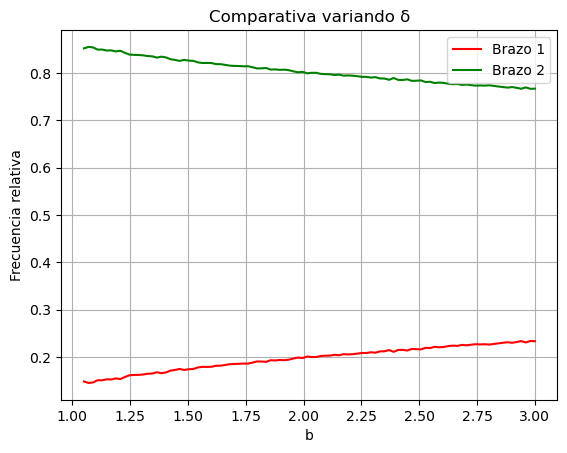

In [ ]:

# COMPARACION VARIANDO delta
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
frecuencias_UCB_ParaCadaM_brazo1 = []
frecuencias_UCB_ParaCadaM_brazo2 = []
delta_values = np.linspace(1.05,3,100)  # valores de b entre 1.05 y 3 (sería mas correcto llamarlos b_values)
for delta in delta_values:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_UCB_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_UCB_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
        UCB(n, 1/(n**delta))
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_UCB_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_UCB_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_UCB_ParaCadaM_brazo1.append(np.mean(frecuencias_UCB_brazo1)/n) #Acumulamos frecuencia de la accion 1
    frecuencias_UCB_ParaCadaM_brazo2.append(np.mean(frecuencias_UCB_brazo2)/n) #Acumulamos frecuencia de la accion 2


#GRAFICA PSEUDOREGRETS
plt.plot(delta_values, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.xlabel('b')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando δ')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(delta_values, frecuencias_UCB_ParaCadaM_brazo1, 'red', label='Brazo 1')
plt.plot(delta_values, frecuencias_UCB_ParaCadaM_brazo2, 'green', label='Brazo 2')
plt.xlabel('b')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando δ')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
#veamos diferencia freuencia relativa del brazo optimo segun delta
print("Valor maximo frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[0],"\n Valor minimio frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[99])

Valor maximo frecuencia relativa =  0.85212 
 Valor minimio frecuencia relativa =  0.7669


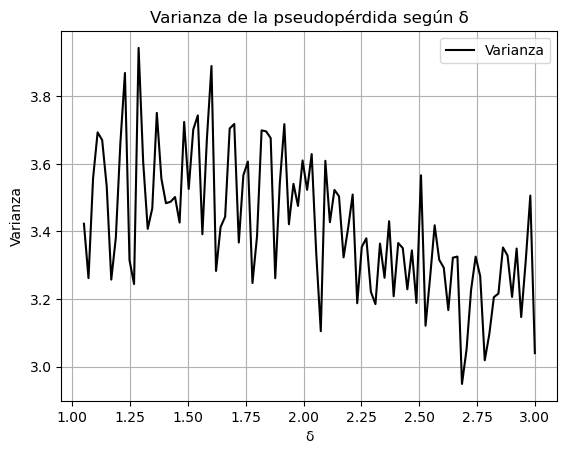

In [55]:
# VARIANZA DEl pseudoREGRET variando delta
n = 100
simula = 1000
varianza = [] #varianza de cada delta

delta_values = np.linspace(1.05,3,100)  # valores de b entre 1.05 y 3 (sería mas correcto llamarlos b_values)
for delta in delta_values:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
        UCB(n, 1/(n**delta))
        pseudoregret_valores.append(bandido.pseudoregret())
    varianza.append(np.var(pseudoregret_valores))
    
# Graficar la varianza
plt.plot(delta_values, varianza, 'k-', label='Varianza')
plt.xlabel('δ')
plt.ylabel('Varianza')
plt.title('Varianza de la pseudopérdida según δ')
plt.legend()
plt.grid(True)
plt.show()

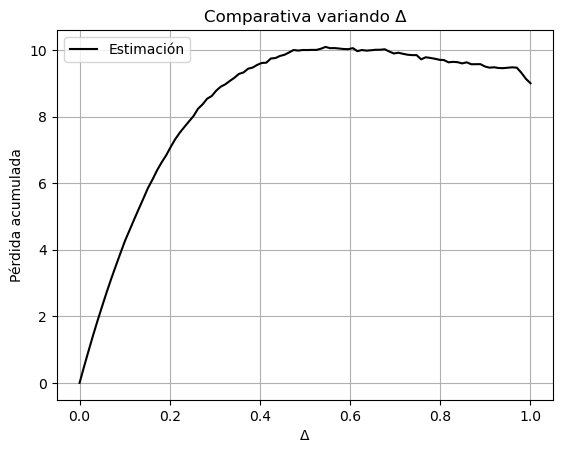

In [69]:

# COMPARACION VARIANDO DELTA
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de regret real
triangulovalores = np.linspace(0,1,100)  # valores de triangulo
for triangulo in triangulovalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = BernoulliBandit([0., 0.+triangulo])  # Reset the bandit for each simulation
        UCB(n, 1/(n**2))
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))


# GRAFICA PSEUDOPERDIDA
plt.plot(triangulovalores, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando Δ')
plt.legend()
plt.grid(True)
plt.show()

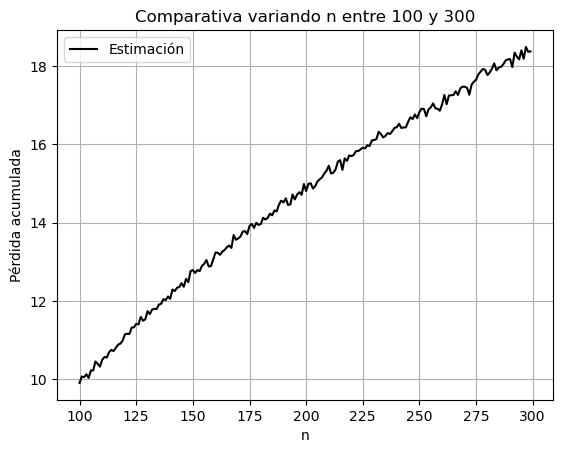

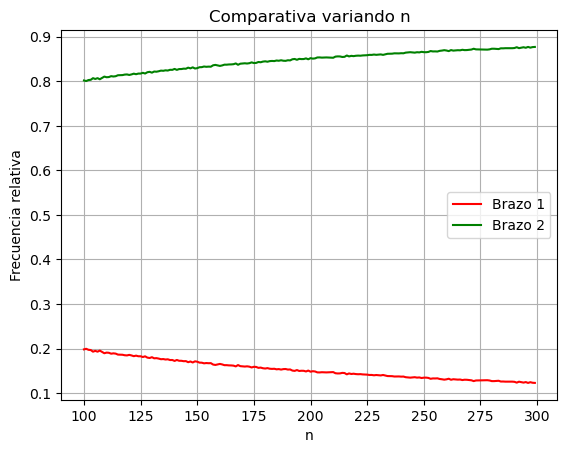

In [52]:

# COMPARACION VARIANDO N
simula = 1000
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de las regret real
frecuencias_UCB_ParaCadaM_brazo1 = []
frecuencias_UCB_ParaCadaM_brazo2 = []
nvalores = range(100,300)  # valores de n desde 100 hasta 200
for n in nvalores:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_UCB_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_UCB_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
        UCB(n, 1/(n**2))
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_UCB_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_UCB_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_UCB_ParaCadaM_brazo1.append(np.mean(frecuencias_UCB_brazo1)/n) #Acumulamos frecuencia de la accion 1
    frecuencias_UCB_ParaCadaM_brazo2.append(np.mean(frecuencias_UCB_brazo2)/n) #Acumulamos frecuencia de la accion 2

#GRAFICA PSEUDOREGRETS
plt.plot(nvalores, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.xlabel('n')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando n entre 100 y 300')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(nvalores, frecuencias_UCB_ParaCadaM_brazo1, 'red', label='Brazo 1')
plt.plot(nvalores, frecuencias_UCB_ParaCadaM_brazo2, 'green', label='Brazo 2')
plt.xlabel('n')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando n')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
#veamos diferencia freuencia relativa del brazo optimo segun delta
print("Valor maximo frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[0],"\n Valor minimio frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[99])

Valor maximo frecuencia relativa =  0.80179 
 Valor minimio frecuencia relativa =  0.8493567839195979


## Implementacion Teorema acotacion $R_n$ para UCB
Libro-MAB pag 105 Th 7.1

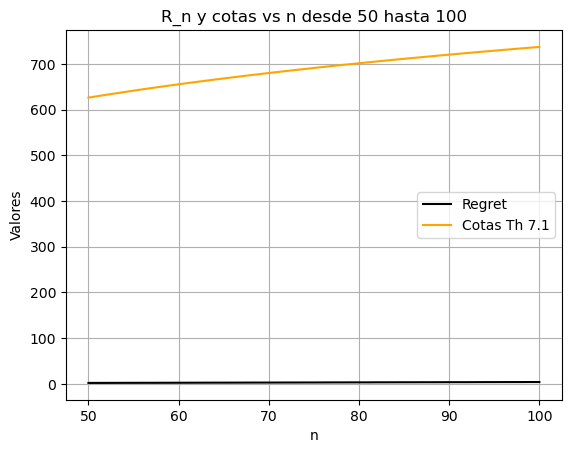

In [ ]:
# Simulaciones
n = 100
simula = 1000

regret_valores_UCB = [] #acumulador de regret
cotas_valores_UCB1 = [] #acumulador de las cotas
nrondas = range(50, 101)  # valores de m desde 50 hasta 100
for n in nrondas:
    pseudoregret_valores_UCB = [] #acumul
    for _ in range(simula):
        bandido = BernoulliBandit([0.5, 0.6])  # Reset the bandit for each simulation
        UCB(n,1/(n**2))
        pseudoregret_valores_UCB.append(bandido.pseudoregret())
    regret_valores_UCB.append(np.mean(pseudoregret_valores_UCB))
    cotas_valores_UCB1.append(3*0.1+16*np.log(n)/0.1)

# Plotting
plt.plot(nrondas, regret_valores_UCB, 'k-', label='Regret')  # Black line for regret
plt.plot(nrondas, cotas_valores_UCB1, 'orange', label='Cotas Th 7.1')  # Orange line for cotas
plt.xlabel('n')
plt.ylabel('Valores')
plt.title('R_n y cotas vs n desde 50 hasta 100')
plt.legend()
plt.grid(True)
plt.show()

Libro-MAB pag 108 Th 7.2

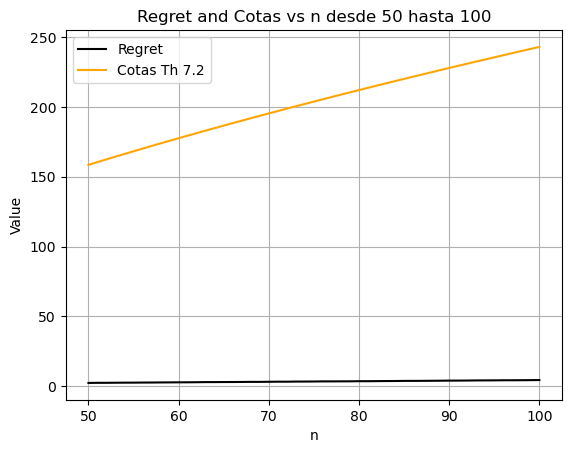

In [ ]:
# Simulaciones

regret_valores_UCB = [] #acumulador de regret
cotas_valores_UCB2 = [] #acumulador de las cotas
nrondas = range(50, 101)  # valores de m desde 50 hasta 100
for n in nrondas:
    pseudoregret_valores_UCB = [] #acumul
    for _ in range(simula):
        bandido = BernoulliBandit([0.5, 0.6])  # Reset the bandit for each simulation
        UCB(n,1/(n**2))
        pseudoregret_valores_UCB.append(bandido.pseudoregret())
    regret_valores_UCB.append(np.mean(pseudoregret_valores_UCB))
    cotas_valores_UCB2.append(8*np.sqrt(n*bandido.K()*np.log(n))+3*0.1)

# Plotting
plt.plot(nrondas, regret_valores_UCB, 'k-', label='Regret')  # Black line for regret
plt.plot(nrondas, cotas_valores_UCB2, 'orange', label='Cotas Th 7.2')  # Orange line for cotas
plt.xlabel('n')
plt.ylabel('Value')
plt.title('Regret and Cotas vs n desde 50 hasta 100')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 100/100 [34:35<00:00, 20.75s/it]


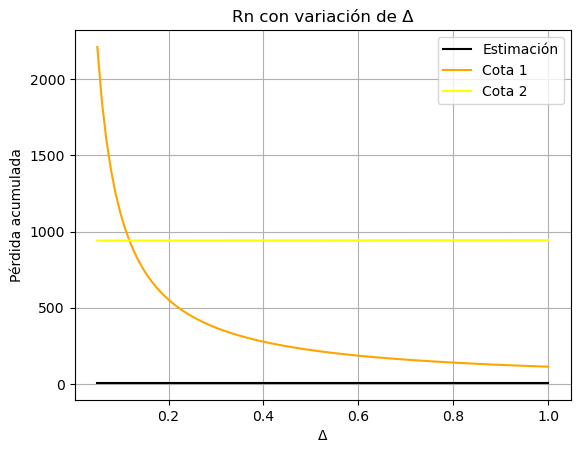

In [ ]:
# TH 7.2 CON VARIACION DE DELTA
from tqdm import tqdm
n=1000
simula = 10000
regret_valores_UCB = [] #acumulador de regret
cotas_valores_UCB2 = [] #acumulador de las cotas th7.2
cotas_valores_UCB1 = [] #acumulador de las cotas th7.1
triangulovalores = np.linspace(0,1,100)  # valores de DELTA
for triangulo in tqdm(triangulovalores):
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = BernoulliBandit([0., 0.+triangulo])   # Reset the bandit for each simulation
        UCB(n, 1/(n**2))
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores_UCB.append(np.mean(pseudoregret_valores))
    cotas_valores_UCB2.append(8*np.sqrt(n*bandido.K()*np.log(n))+3*triangulo)
    cotas_valores_UCB1.append(3*triangulo+16*np.log(n)/triangulo)


# GRAFICA PSEUDOREGRET
plt.plot(triangulovalores, regret_valores_UCB, 'k-', label='Estimación')  # Black line for regret
plt.plot(triangulovalores, cotas_valores_UCB1, 'orange', label='Cota 1')  # Orange line for cotas
plt.plot(triangulovalores, cotas_valores_UCB2, 'yellow', label='Cota 2')  # Orange line for cotas
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Rn con variación de Δ')
plt.legend()
plt.grid(True)
plt.show()

# Comparativa UCB vs ETC caso Bernoulli

In [ ]:
print("Valores de Rn para UCB",real_regret_UCB)
print("Valores de Rn para ETC",real_regret_ETC)

Valores de Rn para UCB 4.194400000000001
Valores de Rn para ETC 3.947999999999998


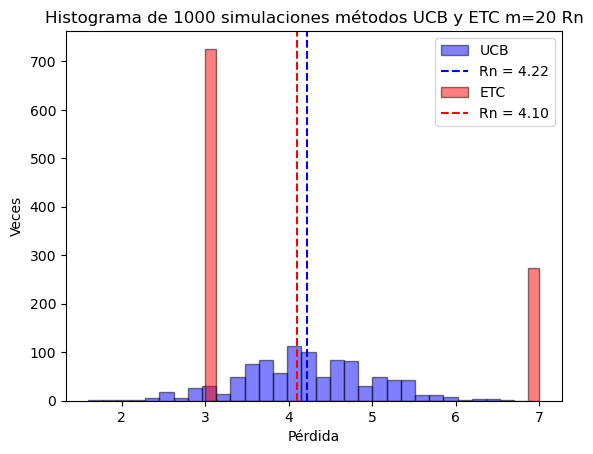

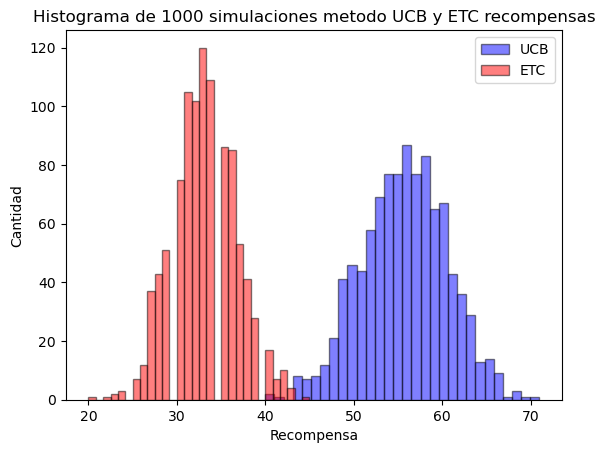

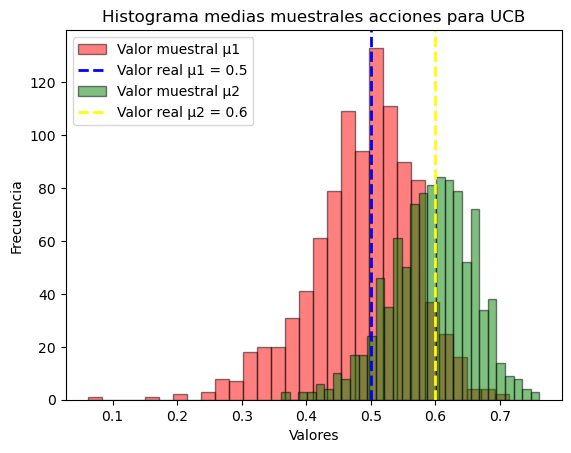

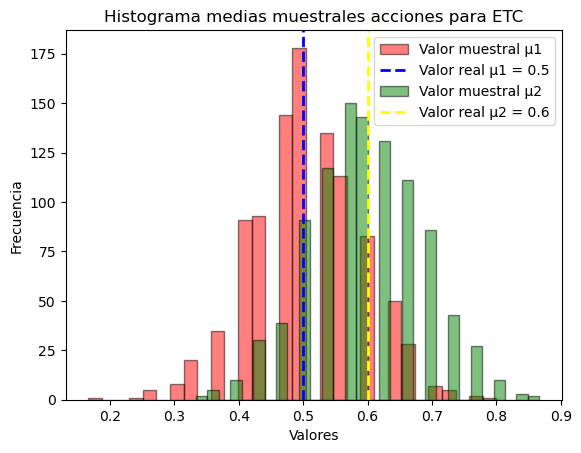

In [ ]:
com_regret_valores_UCB = [] #acumulador de regret UCB
com_medias_valores_UCB = [] #acumulador de regret UCB
com_recompensa_valores_UCB = [] #acumulador de regret UCB
com_regret_valores_ETC = [] #acumulador de regret ETC
com_medias_valores_ETC = [] #acumulador de regret ETC
com_recompensa_valores_ETC = [] #acumulador de regret ETC
simula = 1000 #numero de simulaciones
#nrondas = range(50, 101)  # valores de m desde 50 hasta 100
for _ in range(simula):
    bandido = BernoulliBandit([0.5, 0.6])  # Reset the bandit for each simulation
    (medUCB, recUCB) = UCB(n,1/(n**2))
    com_regret_valores_UCB.append(bandido.pseudoregret())
    com_medias_valores_UCB.append(medUCB)
    com_recompensa_valores_UCB.append(recUCB)
for _ in range(simula):
    bandido = BernoulliBandit([0.5, 0.6])  # Reset the bandit for each simulation
    (medETC, recETC) = ETC(n,30)
    com_regret_valores_ETC.append(bandido.pseudoregret())
    com_medias_valores_ETC.append(medETC)
    com_recompensa_valores_ETC.append(recETC)

plt.hist(com_regret_valores_UCB, bins=30, edgecolor='black', color='blue', alpha=0.5, label='UCB')
real_regret_UCB = np.mean(com_regret_valores_UCB)
plt.axvline(real_regret_UCB, color='blue', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCB:.2f}")
plt.hist(com_regret_valores_ETC, bins=30, edgecolor='black', color='red', alpha=0.5, label='ETC')
real_regret_ETC = np.mean(com_regret_valores_ETC)
plt.axvline(real_regret_ETC, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETC:.2f}")
plt.xlabel("Pérdida")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones métodos UCB y ETC m="+str(m) +" Rn")
plt.legend()
plt.show()

plt.hist(com_recompensa_valores_UCB, bins=30, edgecolor='black', color='blue', alpha=0.5, label='UCB')
plt.hist(com_recompensa_valores_ETC, bins=30, edgecolor='black', color='red', alpha=0.5, label='ETC')
plt.xlabel("Recompensa")
plt.ylabel("Cantidad")
plt.title("Histograma de "+ str(simula) +" simulaciones metodo UCB y ETC recompensas")
plt.legend()
plt.show()

# separar las medias muestrales com_medias_valores_UCB
primeramediaUCB = [pares[0] for pares in com_medias_valores_UCB]
segundamediaUCB = [pares[1] for pares in com_medias_valores_UCB]

# UCB
plt.hist(primeramediaUCB, bins=30, edgecolor='black', color='red', alpha=0.5, label='Valor muestral μ1')
plt.axvline(x=0.5, color='blue', linestyle='dashed', linewidth=2, label='Valor real μ1 = 0.5')
plt.hist(segundamediaUCB, bins=30, edgecolor='black', color='green', alpha=0.5, label='Valor muestral μ2')
plt.axvline(x=0.6, color='yellow', linestyle='dashed', linewidth=2, label='Valor real μ2 = 0.6')
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.title("Histograma medias muestrales acciones para UCB")
plt.legend()
plt.show()

# separar las medias muestrales com_medias_valores_UCB
primeramediaETC = [pares[0] for pares in com_medias_valores_ETC]
segundamediaETC = [pares[1] for pares in com_medias_valores_ETC]

# ETC
plt.hist(primeramediaETC, bins=30, edgecolor='black', color='red', alpha=0.5, label='Valor muestral μ1')
plt.axvline(x=0.5, color='blue', linestyle='dashed', linewidth=2, label='Valor real μ1 = 0.5')
plt.hist(segundamediaETC, bins=30, edgecolor='black', color='green', alpha=0.5, label='Valor muestral μ2')
plt.axvline(x=0.6, color='yellow', linestyle='dashed', linewidth=2, label='Valor real μ2 = 0.6')
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.title("Histograma medias muestrales acciones para ETC")
plt.legend()
plt.show()


# Bandido Normal

In [4]:
class NormalBandit:
    # Accepts a list of K >= 2 floats, each representing the mean of the arms
    def __init__(self, means):
        self.means = means  # Store the means of each arm
        self.acumregret = 0  # Store the accumulated regret
        self.bestarm = max(means)  # Store the mean of the best arm
        self.std_dev = 1  # Standard deviation for all arms !!SE PUEDE CAMBIAR PARA QUE NO SEAN DE DESVIACION ESTANDAR 1!!
        self.frecuencyacum = [0] * len(means)  # Store the frequency of each arm
    # Function should return the number of arms
    def K(self):
        return len(self.means)

    # Accepts a parameter 0 <= a <= K - 1 and returns the realization of a random variable
    # following a Gaussian distribution with the mean of the (a + 1)th arm and std_dev = 1
    def pull(self, a):
        if a < 0 or a >= self.K():
            raise ValueError("Invalid value for a")  # Error for out-of-bounds index
        self.frecuencyacum[a] += 1
        reward = random.gauss(self.means[a], self.std_dev)  # Gaussian reward
        self.acumregret += (self.bestarm - self.means[a])  # Add to accumulated regret
        return reward
    def frecuency (self):
        return(self.frecuencyacum)
    # Returns the regret incurred so far
    def pseudoregret(self):
        return self.acumregret
    
#DEFINIMOS FUNCION AUXILIAR PARA CALCULAR LA PROBABILIDAD    
def probabilidad(x): #Para el ejemplo 2 brazos normales P(x>0)
    return(1-norm.cdf(x))

Veamos ejemplo sencillo para $K=3$

In [ ]:
bandido = NormalBandit([0,0.5,1])

print("Numero de acciones: ",bandido.K())
print("Jugando la accion 1 obtenemos recompensa: ",bandido.pull(0))
print("Jugando la accion 2 obtenemos recompensa: ",bandido.pull(1))
print("Jugando la accion 3 obtenemos recompensa: ",bandido.pull(2))
print("Obtuvimos una pseudoperdida acumulada de: ",bandido.pseudoregret())

Numero de acciones:  3
Jugando la accion 1 obtenemos recompensa:  0.6116084701298391
Jugando la accion 2 obtenemos recompensa:  -0.810207566850057
Jugando la accion 3 obtenemos recompensa:  1.7177369937006843
Obtuvimos una pseudoperdida acumulada de:  1.5


Ahora veamos los métodos ETC y UCB para el caso de 2 brazos normales, de medias $2, 2.5$. Ambos con desviacio fijada en $1$.

# ETC caso normal

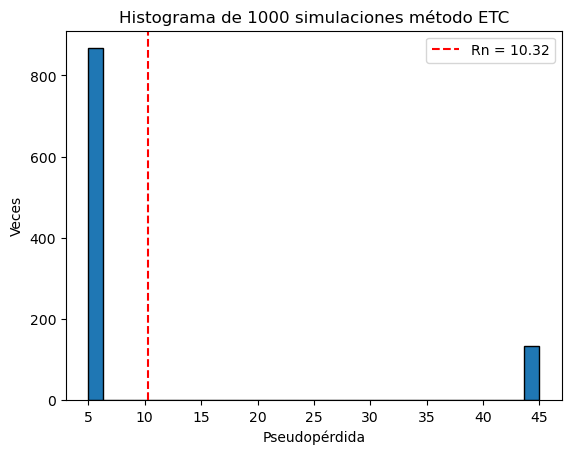

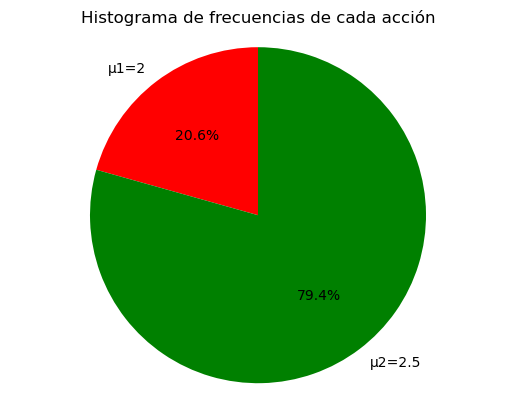

In [28]:
# Simulaciones
simula = 1000
n= 100
m =10
pseudoregret_valores_ETC = [] #
frecuencias_ETC = [0,0] #frecuencia de cada accion
for _ in range(simula):
    bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
    ETC(n, m)
    pseudoregret_valores_ETC.append(bandido.pseudoregret())
    frecuencias_ETC[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_ETC[1] += bandido.frecuency()[1] #frecuencia de la accion 2

plt.hist(pseudoregret_valores_ETC, bins=30, edgecolor='black')
real_regret_ETC = np.mean(pseudoregret_valores_ETC)
plt.axvline(real_regret_ETC, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETC:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones método ETC")
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.pie([frecuencias_ETC[0] / simula, frecuencias_ETC[1] / simula], labels = ["μ1=2", "μ2=2.5"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Histograma de frecuencias de cada acción")
plt.show()

#### Gráficas frecuencias relativas por brazos

Vamos a implementar el método anterior, pero con la variación para que devuelva las frecuencias de jugar cada brazo y el orden en el que se juegan

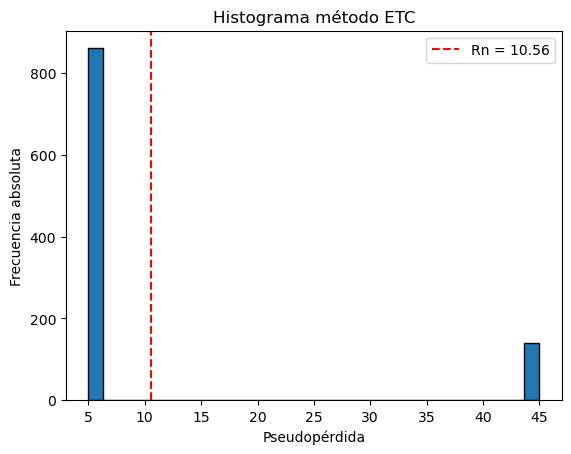

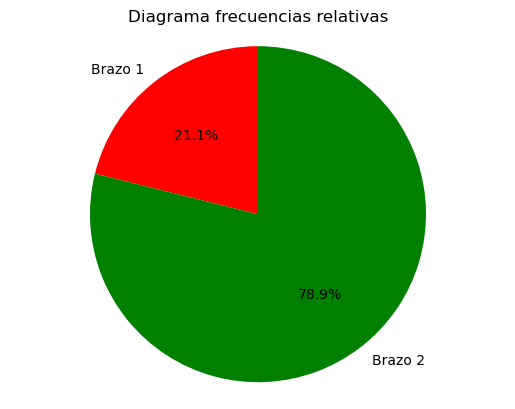

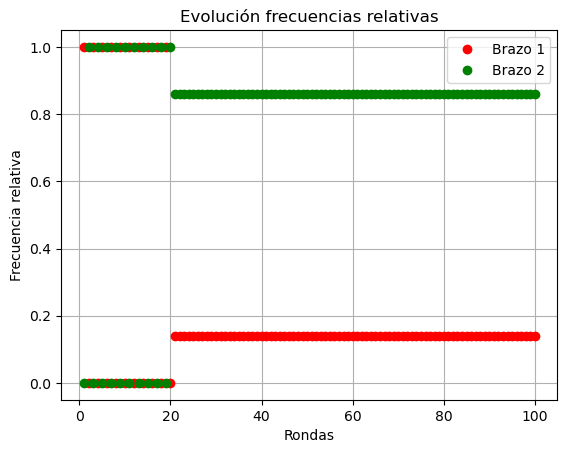

In [5]:

n = 100 #horizonte
m = 10 #numero de rondas dedicadas a explorar cada opcion (debe verificar que n>= m*K)
simula = 1000 #numero de simulaciones

# Simulaciones 2 BRAZOS
K = 2
pseudoregret_valores_ETCrondas = [] #
frecuencias_ETCrondas = [0,0] #
acumbrazos = np.zeros((n,K))
for _ in range(simula):
    bandido =  NormalBandit([2,2.5])  # Reset the bandit for each simulation
    brazosjugados = ETCrondas(n, m)
    pseudoregret_valores_ETCrondas.append(bandido.pseudoregret())
    frecuencias_ETCrondas[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_ETCrondas[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_ETCrondas, bins=30, edgecolor='black')
real_regret_ETCrondas = np.mean(pseudoregret_valores_ETCrondas)
plt.axvline(real_regret_ETCrondas, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETCrondas:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta")
plt.title("Histograma método ETC")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_ETCrondas[0] / simula, frecuencias_ETCrondas[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1 = acumbrazos[:,0] / simula
brazo2 = acumbrazos[:,1] / simula
plt.plot(x, brazo1, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print("A partir de la ronda 20, la probabilidad de elegir el brazo 2 es de:", brazo2[20])

A partir de la ronda 20, la probabilidad de elegir el brazo 2 es 0.861


#### Comparacion estimacion con pseudoregret y regret real

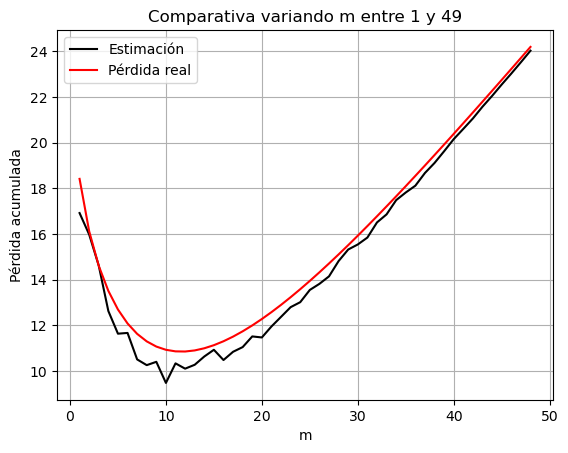

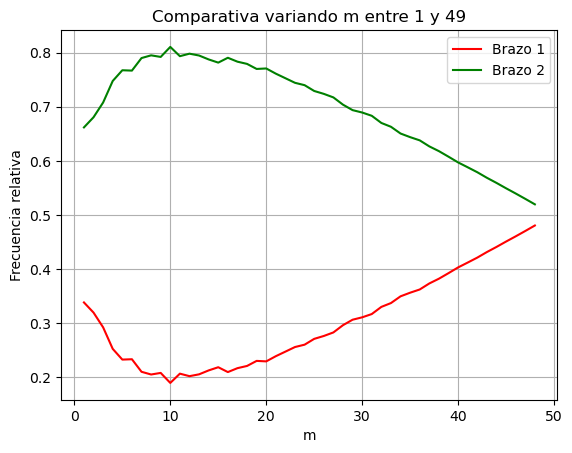

In [58]:

# COMPARACION VARIANDO M
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
regret_real_valores = []
frecuencias_ETC_ParaCadaM_brazo1 = []
frecuencias_ETC_ParaCadaM_brazo2 = []
m_values = range(1,49)  # valores de m desde 0 hasta 24
for m in m_values:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_ETC_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_ETC_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = NormalBandit([2, 2.5])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_ETC_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_ETC_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_ETC_ParaCadaM_brazo1.append(np.mean(frecuencias_ETC_brazo1)/n) #Acumulamos frecuencia de la accion 1
    frecuencias_ETC_ParaCadaM_brazo2.append(np.mean(frecuencias_ETC_brazo2)/n) #Acumulamos frecuencia de la accion 2
    regret_real_valores.append(0.5*(m+(100-m)*probabilidad(0.5/np.sqrt(2/m))))


#GRAFICA PSEUDOREGRETS
plt.plot(m_values, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.plot(m_values, regret_real_valores, 'red', label='Pérdida real')  # red line for regret real
plt.xlabel('m')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando m entre 1 y 49')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(m_values, frecuencias_ETC_ParaCadaM_brazo1, 'red', label='Brazo 1')
plt.plot(m_values, frecuencias_ETC_ParaCadaM_brazo2, 'green', label='Brazo 2')
plt.xlabel('m')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando m entre 1 y 49')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
#veamos cuando se alcanza el valor real minimo, el valor de m
minimo = min(regret_real_valores)
print("Valor de m = ",regret_real_valores.index(minimo) +1,"para el cual se alcanza el valor minimo de la perdida real = ",minimo)
print("La mayor frecuencia relativa para el brazo 1 es:",frecuencias_ETC_ParaCadaM_brazo2[regret_real_valores.index(minimo)])

Valor de m =  12 para el cual se alcanza el valor minimo de la perdida real =  10.854769962236631
La mayor frecuencia relativa para el brazo 1 es: 0.79792


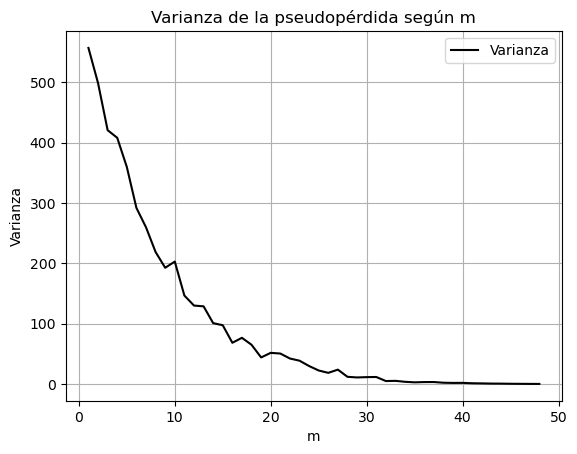

In [ ]:
# VARIANZA DEl pseudoREGRET variando m
def probabilidad(x): #Para el ejemplo 2 brazos normales P(x>0)
    return(1-norm.cdf(x))

m_values = range(1, 49)  # Valores de m desde 1 hasta 49
simula = 1000
n= 100
varianza = [] #varianza de cada m
for m in m_values:
    pseudoregret_valores_ETC = [] #
    for _ in range(simula):
        bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores_ETC.append(bandido.pseudoregret())
    varianza.append(np.var(pseudoregret_valores_ETC))

# Graficar la varianza
plt.plot(m_values, varianza, 'k-', label='Varianza')
plt.xlabel('m')
plt.ylabel('Varianza')
plt.title('Varianza de la pseudopérdida según m')
plt.legend()
plt.grid(True)
plt.show()

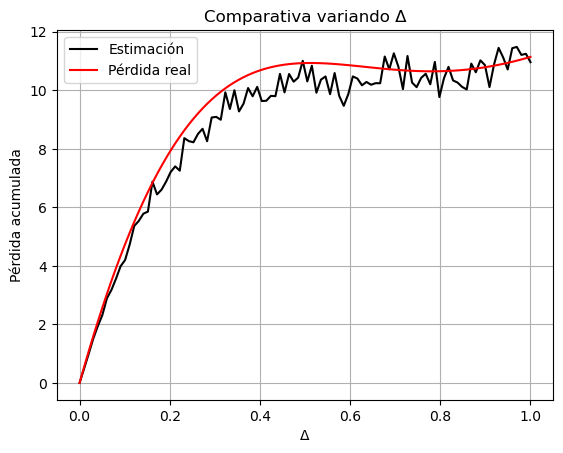

In [70]:

# COMPARACION VARIANDO DELTA
n = 100
simula = 1000
m=10
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de regret real
triangulovalores = np.linspace(0,1,100)  # valores de triangulo
for triangulo in triangulovalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2, 2+triangulo])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    regret_real_valores.append(triangulo*(m+(100-m)*probabilidad(triangulo/np.sqrt(2/m))))

# Plotting
plt.plot(triangulovalores, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.plot(triangulovalores, regret_real_valores, 'red', label='Pérdida real')  # red line for regret real
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando Δ')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
#comprobemos que el valor cuando Delta = 0.5 corresponde a la perdida real calculada previamente
triangulovaloreslista = triangulovalores.tolist()
indice = triangulovaloreslista.index(0.501010101010101)
regret_real_valores[indice]

10.930291087578006

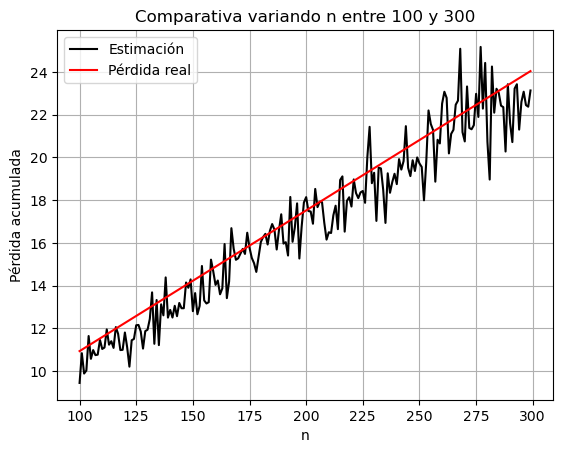

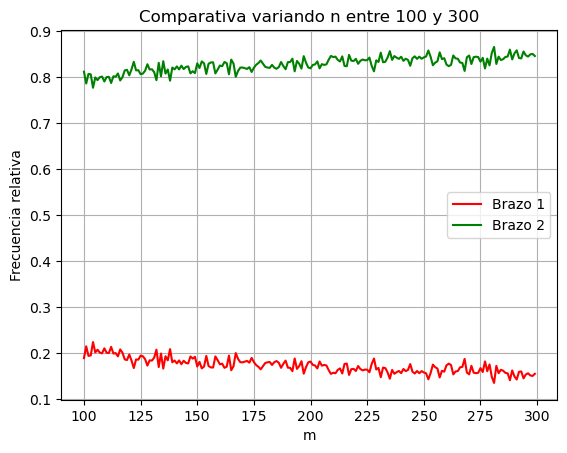

In [32]:

# COMPARACION VARIANDO N
simula = 1000
m=10
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de las regret real
frecuencias_ETC_ParaCadaN_brazo1 = []
frecuencias_ETC_ParaCadaN_brazo2 = []
nvalores = range(100,300)  # valores de m desde 0 hasta 24
for n in nvalores:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_ETC_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_ETC_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = NormalBandit([2, 2.5])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_ETC_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_ETC_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_ETC_ParaCadaN_brazo1.append(np.mean(frecuencias_ETC_brazo1)/n) #Acumulamos frecuencia de la accion 1
    frecuencias_ETC_ParaCadaN_brazo2.append(np.mean(frecuencias_ETC_brazo2)/n) #Acumulamos frecuencia de la accion 2
    regret_real_valores.append(0.5*(m+(n-m)*probabilidad(0.5/np.sqrt(2/m))))


#GRAFICA PSEUDOREGRETS
plt.plot(nvalores, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.plot(nvalores, regret_real_valores, 'red', label='Pérdida real')  # red line for regret real
plt.xlabel('n')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando n entre 100 y 300')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(nvalores, frecuencias_ETC_ParaCadaN_brazo1, 'red', label='Brazo 1')
plt.plot(nvalores, frecuencias_ETC_ParaCadaN_brazo2, 'green', label='Brazo 2')
plt.xlabel('m')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando n entre 100 y 300')
plt.legend()
plt.grid(True)
plt.show()

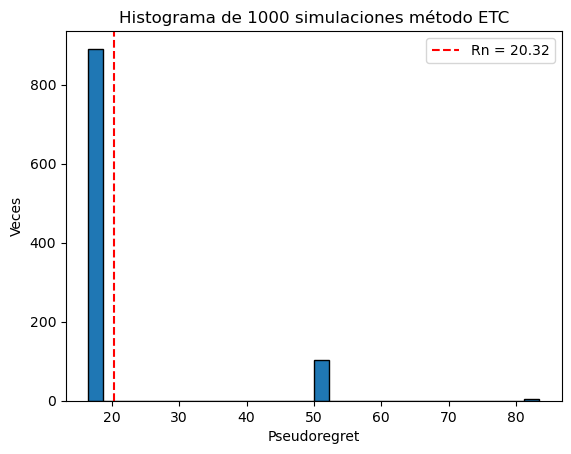

In [ ]:
# Simulaciones 2 // 3 acciones
simula = 1000
n= 100
m =11
pseudoregret_valores_ETC = [] #
for _ in range(simula):
    bandido = NormalBandit([2,2.5,3])  # Reset the bandit for each simulation
    ETC(n, m)
    pseudoregret_valores_ETC.append(bandido.pseudoregret())

plt.hist(pseudoregret_valores_ETC, bins=30, edgecolor='black')
real_regret_ETC = np.mean(pseudoregret_valores_ETC)
plt.axvline(real_regret_ETC, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETC:.2f}")
plt.xlabel("Pseudoregret")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones método ETC")
plt.legend()
plt.show()


## Teorema acotacion $R_n$

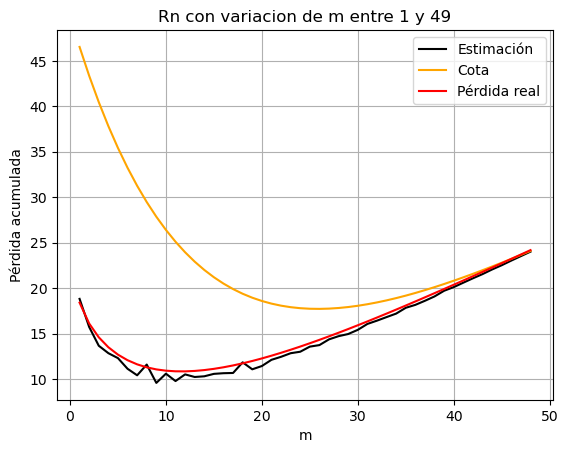

In [66]:
# Simulaciones
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
cotas_valores = [] #acumulador de las cotas
regret_real_valores = [] #acumulador de las regret real
m_values = range(1,49)  # valores de m desde 0 hasta 24
for m in m_values:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2, 2.5])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    cotas_valores.append(m*0.5+(n-m*bandido.K())*0.5*np.exp(-m*0.5**2/4))
    regret_real_valores.append(0.5*(m+(100-m)*probabilidad(0.5/np.sqrt(2/m))))


# Plotting
plt.plot(m_values, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.plot(m_values, cotas_valores, 'orange', label='Cota')  # Orange line for cotas
plt.plot(m_values, regret_real_valores, 'red', label='Pérdida real')  # red line for regret real
plt.xlabel('m')
plt.ylabel('Pérdida acumulada')	
plt.title('Rn con variacion de m entre 1 y 49')
plt.legend()
plt.grid(True)
plt.show()

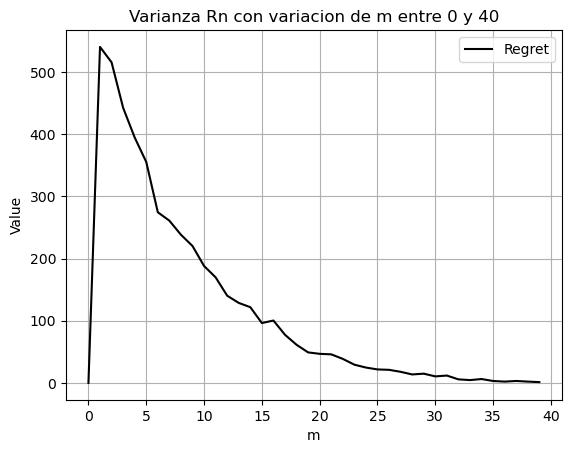

In [ ]:
# Simulations
simula = 1000  # Number of simulations
n = 100  # Horizon
m_values = range(40)  # Different values of m to test
variances = []  # To store the variance of pseudoregret for each m

for m in m_values:
    pseudoregret_valores = []  # Accumulator for pseudoregret
    for _ in range(simula):
        bandido = NormalBandit([2, 2.5])  # Reset the bandit for each simulation
        ETC(n, m)  # Run the ETC method
        pseudoregret_valores.append(bandido.pseudoregret())  # Collect pseudoregret
    variances.append(np.var(pseudoregret_valores))  # Compute variance for this m

# Plotting
plt.plot(m_values, variances, 'k-', label='Regret')  # Black line for regret
#plt.plot(m_values, cotas_valores, 'orange', label='Cotas')  # Orange line for cotas
plt.xlabel('m')
plt.ylabel('Value')
plt.title('Varianza Rn con variacion de m entre 0 y 40')
plt.legend()
plt.grid(True)
plt.show()

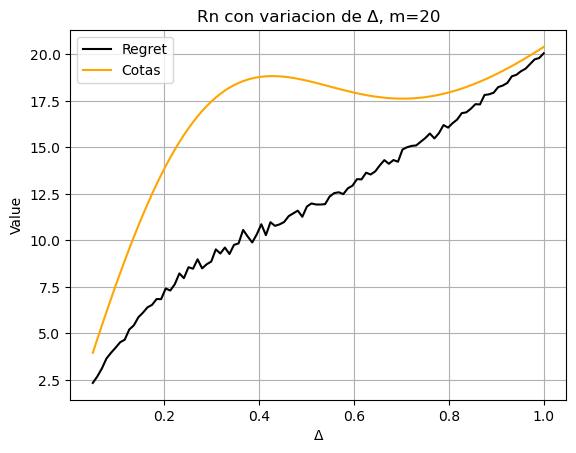

In [ ]:
# Simulaciones
n = 100
simula = 1000
m=20
regret_valores = [] #acumulador de regret
cotas_valores = [] #acumulador de las cotas
triangulovalores = np.linspace(0,1,100)  # valores de triangulo
for triangulo in triangulovalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2, 2+triangulo])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    cotas_valores.append(m*triangulo+(n-m*bandido.K())*triangulo*np.exp(-m*triangulo**2/4))

# Plotting
plt.plot(triangulovalores, regret_valores, 'k-', label='Regret')  # Black line for regret
plt.plot(triangulovalores, cotas_valores, 'orange', label='Cotas')  # Orange line for cotas
plt.xlabel('Δ')
plt.ylabel('Value')
plt.title('Rn con variacion de Δ, m=20')
plt.legend()
plt.grid(True)
plt.show()

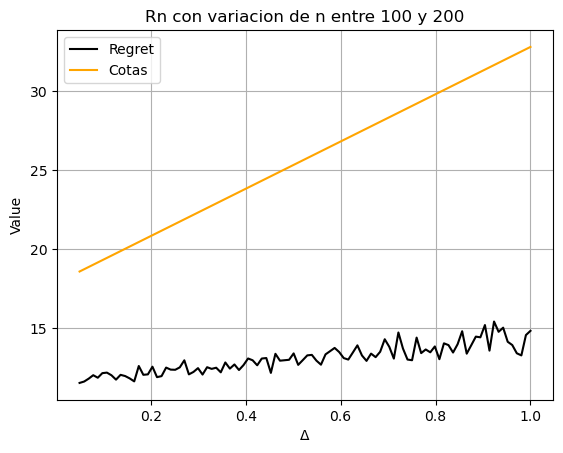

In [ ]:

# Simulaciones
simula = 1000
m=20
regret_valores = [] #acumulador de regret
cotas_valores = [] #acumulador de las cotas
nvalores = range(100,200)  # valores de m desde 0 hasta 24
for n in nvalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2, 2.5])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    cotas_valores.append(m*0.5+(n-m*bandido.K())*0.5*np.exp(-m*0.5**2/4))

# Plotting
plt.plot(nvalores, regret_valores, 'k-', label='Regret')  # Black line for regret
plt.plot(nvalores, cotas_valores, 'orange', label='Cotas')  # Orange line for cotas
plt.xlabel('Δ')
plt.ylabel('Value')
plt.title('Rn con variacion de n entre 100 y 200')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 150/150 [23:54<00:00,  9.57s/it]


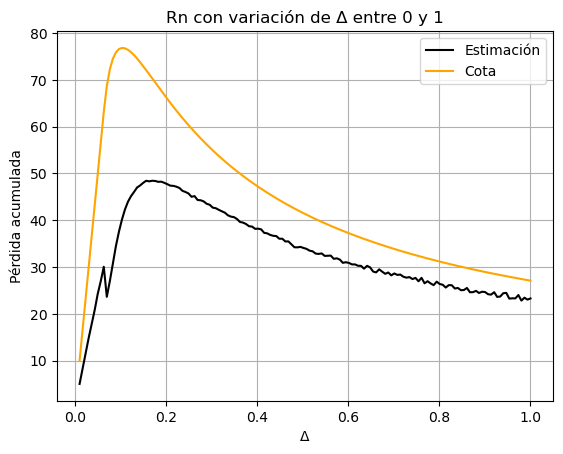

In [67]:

# EXPERIMENTO 6.1
from tqdm import tqdm

simula = 10**4
regret_valores = [] #acumulador de regret
cotas_valores = [] #acumulador de las cotas
n = 1000
deltavalores = np.linspace(0.01, 1, 150)  # valores de delta
for delta in tqdm(deltavalores):
    pseudoregret_valores = [] #acumulador de regret
    m = max(1, math.ceil(4/(delta**2)*np.log(n*delta**2/4)))  # Calculate m based on delta
    for _ in range(simula):
        bandido = NormalBandit([0, -delta])  # Reset the bandit for each simulation
        ETC(n, m)
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))
    cotas_valores.append(min(n*delta,delta+4/delta*(1+max(0,np.log(n*delta**2/4)))))

# Plotting
plt.plot(deltavalores, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.plot(deltavalores, cotas_valores, 'orange', label='Cota')  # Orange line for cotas
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Rn con variación de Δ entre 0 y 1')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def funcionmax(delta):
    return max(1, math.ceil(4/(delta**2)*np.log(n*delta**2/4)))
delta1 = 0.06315
delta2 = 0.06980
n=1000
m1 = funcionmax(delta1)
m2 = funcionmax(delta2)
print("Valor de m para delta1 = ",delta1,"es: ",m1)
print("Valor de m para delta2 = ",delta2,"es: ",m2)

Valor de m para delta1 =  0.06315 es:  1
Valor de m para delta2 =  0.0698 es:  162


# UCB caso normal

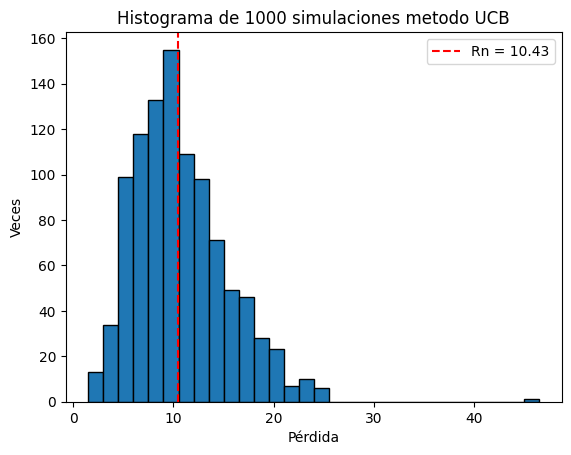

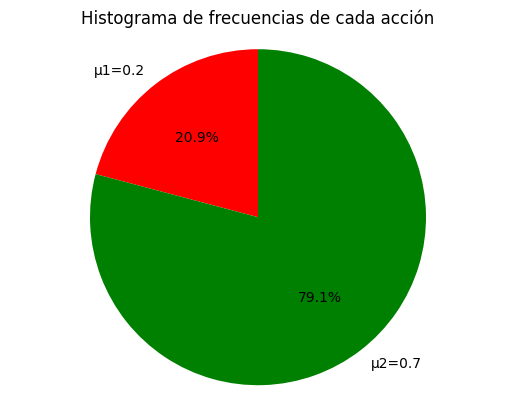

In [ ]:
# Simulacion 2
simula = 1000
n =100
pseudoregret_valores_UCB = []
frecuencias_UCB = [0,0] #frecuencia de cada accion
for _ in range(simula):
    bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
    UCB(n,1/(n**2))
    pseudoregret_valores_UCB.append(bandido.pseudoregret())
    frecuencias_UCB[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_UCB[1] += bandido.frecuency()[1] #frecuencia de la accion 2

plt.hist(pseudoregret_valores_UCB, bins=30, edgecolor='black')
real_regret_UCB = np.mean(pseudoregret_valores_UCB)
plt.axvline(real_regret_UCB, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCB:.2f}")
plt.xlabel("Pérdida")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones método UCB")
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.pie([frecuencias_UCB[0] / simula, frecuencias_UCB[1] / simula], labels = ["μ1=2", "μ2=2.5"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Histograma de frecuencias de cada acción")
plt.show()

#### Gráficas frecuencias relativas por brazos

Vamos a implementar el método anterior, pero con la variación para que devuelva las frecuencias de jugar cada brazo y el orden en el que se juegan

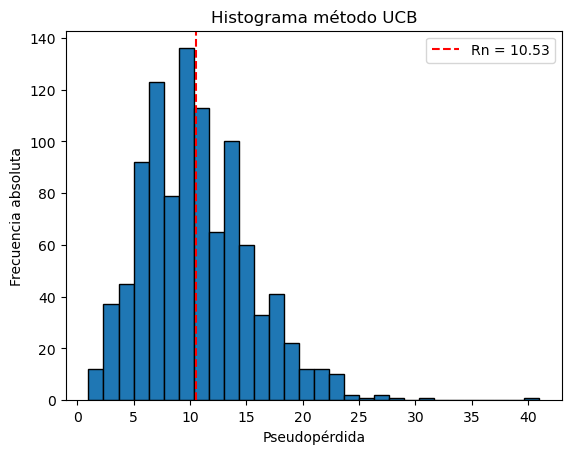

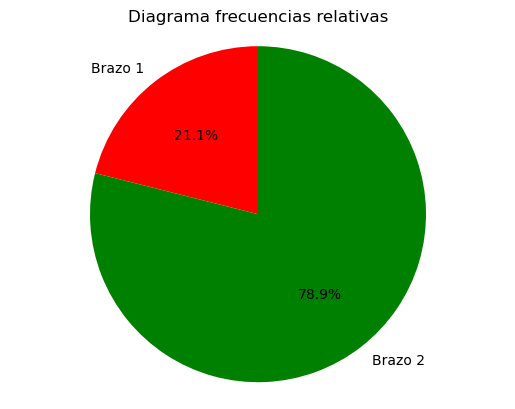

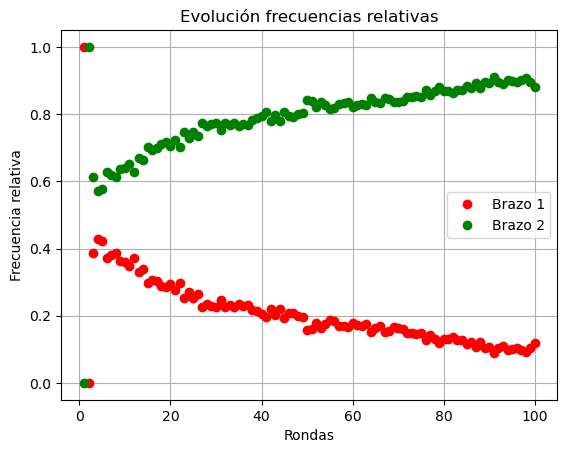

In [7]:
n = 100 #horizonte
simula = 1000 #numero de simulaciones

# Simulacion 2
K = 2
pseudoregret_valores_UCBrondas = []
frecuencias_UCBrondas = [0,0] #frecuencia de cada accion
acumbrazos = np.zeros((n,K))
for _ in range(simula):
    bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
    brazosjugados = UCBrondas(n,1/(n**2)) 
    pseudoregret_valores_UCBrondas.append(bandido.pseudoregret())
    frecuencias_UCBrondas[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_UCBrondas[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_UCBrondas, bins=30, edgecolor='black')
real_regret_UCBrondas = np.mean(pseudoregret_valores_UCBrondas)
plt.axvline(real_regret_UCBrondas, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCBrondas:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta")
plt.title("Histograma método UCB")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_UCBrondas[0] / simula, frecuencias_UCBrondas[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1 = acumbrazos[:,0] / simula
brazo2 = acumbrazos[:,1] / simula
plt.plot(x, brazo1, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
print("A partir de la segunda ronda, la probabilidad de elegir el brazo 2 es de:", brazo2[2])
print("A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2[99])

A partir de la segunda ronda, la probabilidad de elegir el brazo 2 es de: 0.662
A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.877


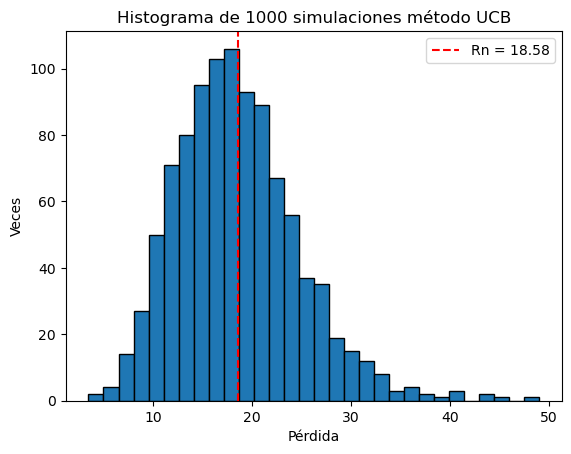

In [ ]:
# Simulacion con 3 acciones
simula = 1000
n =100
pseudoregret_valores_UCB = []
for _ in range(simula):
    bandido = NormalBandit([2,2.5,3])  # Reset the bandit for each simulation
    UCB(n,1/(n**2))
    pseudoregret_valores_UCB.append(bandido.pseudoregret())

plt.hist(pseudoregret_valores_UCB, bins=30, edgecolor='black')
real_regret_UCB = np.mean(pseudoregret_valores_UCB)
plt.axvline(real_regret_UCB, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCB:.2f}")
plt.xlabel("Pérdida")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones método UCB")
plt.legend()
plt.show()

#### Comparacion estimador variando $\Delta$, $\delta$ y n

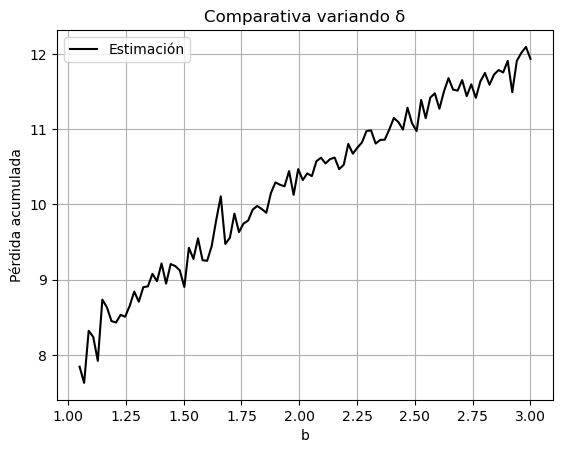

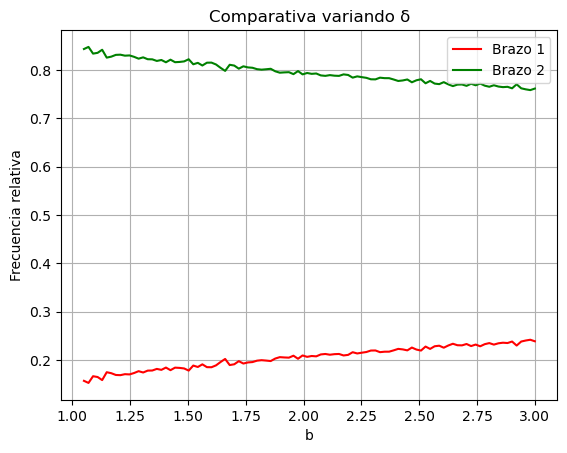

In [30]:

# COMPARACION VARIANDO delta
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
frecuencias_UCB_ParaCadaM_brazo1 = []
frecuencias_UCB_ParaCadaM_brazo2 = []
regret_real_valores = []
delta_values = np.linspace(1.05,3,100)  # valores de m desde 1 hasta 49
for delta in delta_values:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_UCB_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_UCB_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
        UCB(n, 1/(n**delta))
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_UCB_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_UCB_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_UCB_ParaCadaM_brazo1.append(np.mean(frecuencias_UCB_brazo1)/n) #Acumulamos frecuencia de la accion 1
    frecuencias_UCB_ParaCadaM_brazo2.append(np.mean(frecuencias_UCB_brazo2)/n) #Acumulamos frecuencia de la accion 2



#GRAFICA PSEUDOREGRETS
plt.plot(delta_values, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.xlabel('b')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando δ')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(delta_values, frecuencias_UCB_ParaCadaM_brazo1, 'red', label='Brazo 1')
plt.plot(delta_values, frecuencias_UCB_ParaCadaM_brazo2, 'green', label='Brazo 2')
plt.xlabel('b')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando δ')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#veamos diferencia freuencia relativa del brazo optimo segun delta
print("Valor maximo frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[0],"\n Valor minimio frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[99])


Valor maximo frecuencia relativa =  0.8431000000000001 
 Valor minimio frecuencia relativa =  0.76132


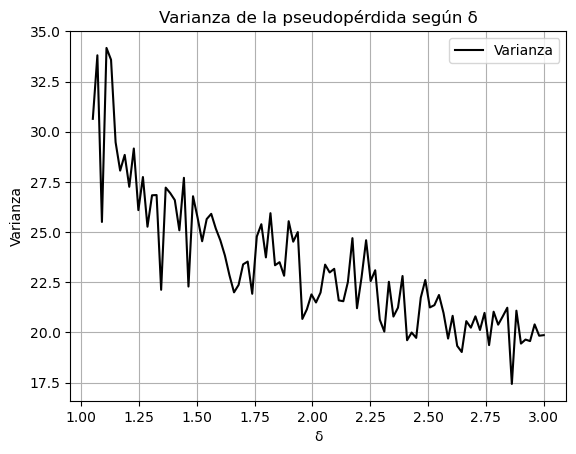

In [56]:
# VARIANZA DEl pseudoREGRET variando delta
n = 100
simula = 1000
varianza = [] #varianza de cada delta

delta_values = np.linspace(1.05,3,100)  # valores de b entre 1.05 y 3 (sería mas correcto llamarlos b_values)
for delta in delta_values:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
        UCB(n, 1/(n**delta))
        pseudoregret_valores.append(bandido.pseudoregret())
    varianza.append(np.var(pseudoregret_valores))
    
# Graficar la varianza
plt.plot(delta_values, varianza, 'k-', label='Varianza')
plt.xlabel('δ')
plt.ylabel('Varianza')
plt.title('Varianza de la pseudopérdida según δ')
plt.legend()
plt.grid(True)
plt.show()

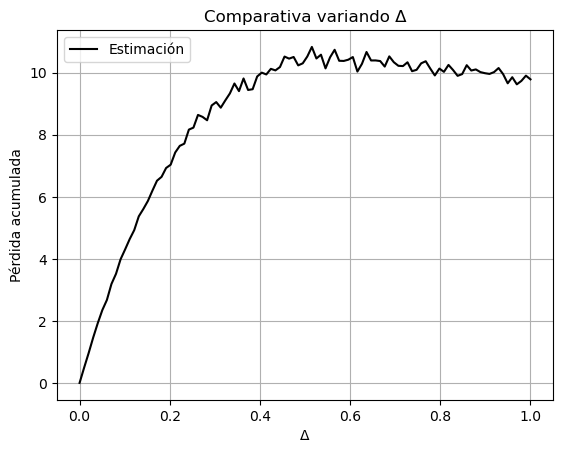

In [72]:

# COMPARACION VARIANDO DELTA
n = 100
simula = 1000
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de regret real
triangulovalores = np.linspace(0,1,100)  # valores de triangulo
for triangulo in triangulovalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2,2+triangulo])  # Reset the bandit for each simulation
        UCB(n, 1/(n**2))
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores.append(np.mean(pseudoregret_valores))


# GRAFICA PSEUDOREGRET
plt.plot(triangulovalores, regret_valores, 'k-', label='Estimación')  # Black line for regret
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando Δ')
plt.legend()
plt.grid(True)
plt.show()

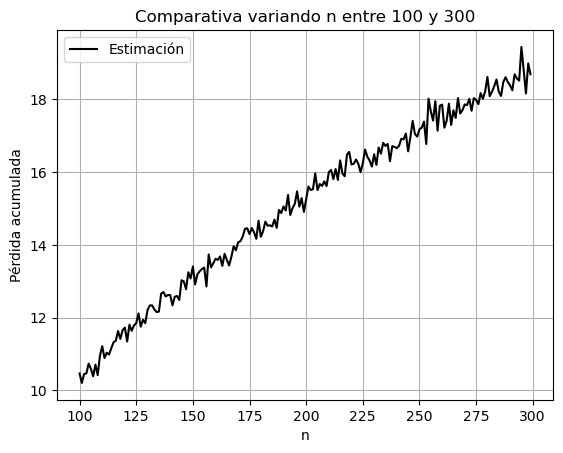

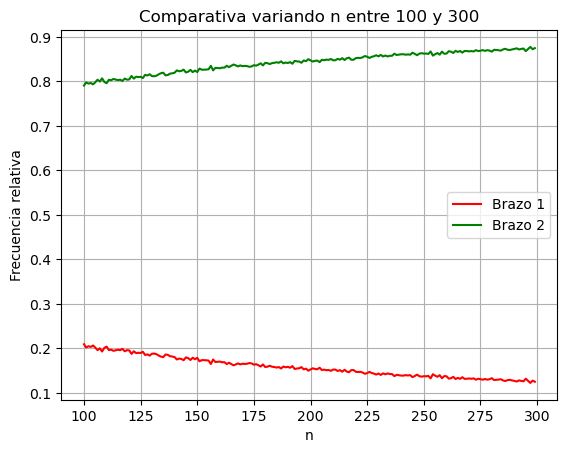

In [33]:

# COMPARACION VARIANDO N
simula = 1000
regret_valores = [] #acumulador de regret
regret_real_valores = [] #acumulador de las regret real
frecuencias_UCB_ParaCadaM_brazo1 = []
frecuencias_UCB_ParaCadaM_brazo2 = []
nvalores = range(100,300)  # valores de n desde 100 hasta 200
for n in nvalores:
    pseudoregret_valores = [] #acumulador de regret
    frecuencias_UCB_brazo1 = [] #acumulador de frecuencias brazo 1
    frecuencias_UCB_brazo2 = [] #acumulador de frecuencias brazo 2
    for _ in range(simula):
        bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
        UCB(n, 1/(n**2))
        pseudoregret_valores.append(bandido.pseudoregret())
        frecuencias_UCB_brazo1.append(bandido.frecuency()[0]) #Acumulamos frecuencia de la accion 1
        frecuencias_UCB_brazo2.append(bandido.frecuency()[1]) #Acumulamos frecuencia de la accion 2
    regret_valores.append(np.mean(pseudoregret_valores))
    frecuencias_UCB_ParaCadaM_brazo1.append(np.mean(frecuencias_UCB_brazo1)/n) #Acumulamos frecuencia de la accion 1
    frecuencias_UCB_ParaCadaM_brazo2.append(np.mean(frecuencias_UCB_brazo2)/n) #Acumulamos frecuencia de la accion 2

#GRAFICA PSEUDOREGRETS
plt.plot(nvalores, regret_valores, 'k-', label='Estimación')  # Black line for regret
#plt.plot(nvalores, regret_real_valores, 'red', label='Pérdida real')  # red line for regret real
plt.xlabel('n')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando n entre 100 y 300')
plt.legend()
plt.grid(True)
plt.show()

#GRAFICA FRECUENCIAS
plt.plot(nvalores, frecuencias_UCB_ParaCadaM_brazo1, 'red', label='Brazo 1')
plt.plot(nvalores, frecuencias_UCB_ParaCadaM_brazo2, 'green', label='Brazo 2')
plt.xlabel('n')
plt.ylabel('Frecuencia relativa')
plt.title('Comparativa variando n entre 100 y 300')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
#veamos diferencia freuencia relativa del brazo optimo segun delta
print("Valor inicio frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[0],"\n Valor final frecuencia relativa = ",frecuencias_UCB_ParaCadaM_brazo2[99])

Valor inicio frecuencia relativa =  0.79071 
 Valor final frecuencia relativa =  0.8501859296482412


## Teorema acotacion $R_n$

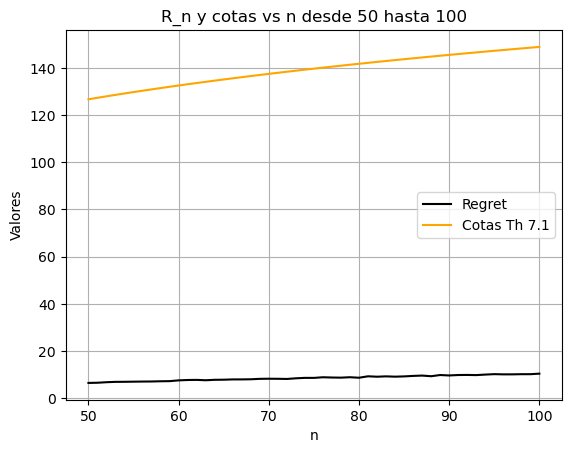

In [ ]:
# Simulaciones
n = 100
simula = 1000

regret_valores_UCB = [] #acumulador de regret
cotas_valores_UCB1 = [] #acumulador de las cotas
nrondas = range(50, 101)  # valores de m desde 50 hasta 100
for n in nrondas:
    pseudoregret_valores_UCB = [] #acumul
    for _ in range(simula):
        bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
        UCB(n,1/(n**2))
        pseudoregret_valores_UCB.append(bandido.pseudoregret())
    regret_valores_UCB.append(np.mean(pseudoregret_valores_UCB))
    cotas_valores_UCB1.append(3*0.5+16*np.log(n)/0.5)

# Plotting
plt.plot(nrondas, regret_valores_UCB, 'k-', label='Regret')  # Black line for regret
plt.plot(nrondas, cotas_valores_UCB1, 'orange', label='Cotas Th 7.1')  # Orange line for cotas
plt.xlabel('n')
plt.ylabel('Valores')
plt.title('R_n y cotas vs n desde 50 hasta 100')
plt.legend()
plt.grid(True)
plt.show()

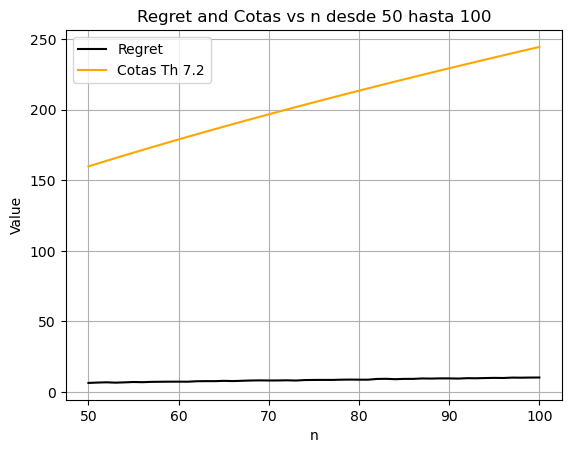

In [ ]:
# TH 7.2 COTA VARIANDO N
n=100
simula = 1000
regret_valores_UCB = [] #acumulador de regret
cotas_valores_UCB2 = [] #acumulador de las cotas
nrondas = range(50, 101)  # valores de m desde 50 hasta 100
for n in nrondas:
    pseudoregret_valores_UCB = [] #acumul
    for _ in range(simula):
        bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
        UCB(n,1/(n**2))
        pseudoregret_valores_UCB.append(bandido.pseudoregret())
    regret_valores_UCB.append(np.mean(pseudoregret_valores_UCB))
    cotas_valores_UCB2.append(8*np.sqrt(n*bandido.K()*np.log(n))+3*0.5)

# Plotting
plt.plot(nrondas, regret_valores_UCB, 'k-', label='Regret')  # Black line for regret
plt.plot(nrondas, cotas_valores_UCB2, 'orange', label='Cotas Th 7.2')  # Orange line for cotas
plt.xlabel('n')
plt.ylabel('Value')
plt.title('Regret and Cotas vs n desde 50 hasta 100')
plt.legend()
plt.grid(True)
plt.show()

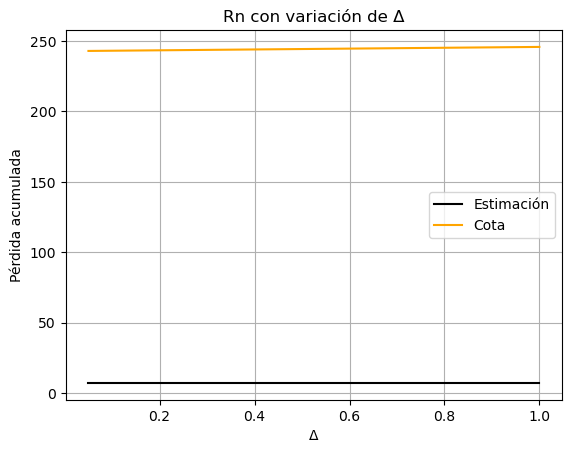

In [57]:
# TH 7.2 CON VARIACION DE DELTA
n=100
simula = 1000
regret_valores_UCB = [] #acumulador de regret
cotas_valores_UCB2 = [] #acumulador de las cotas
triangulovalores = np.linspace(0.05,1,100)  # valores de DELTA
for triangulo in triangulovalores:
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2,2+triangulo])  # Reset the bandit for each simulation
        UCB(n, 1/(n**2))
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores_UCB.append(np.mean(pseudoregret_valores_UCB))
    cotas_valores_UCB2.append(8*np.sqrt(n*bandido.K()*np.log(n))+3*triangulo)


# GRAFICA PSEUDOREGRET
plt.plot(triangulovalores, regret_valores_UCB, 'k-', label='Estimación')  # Black line for regret
plt.plot(triangulovalores, cotas_valores_UCB2, 'orange', label='Cota')  # Orange line for cotas
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Rn con variación de Δ')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


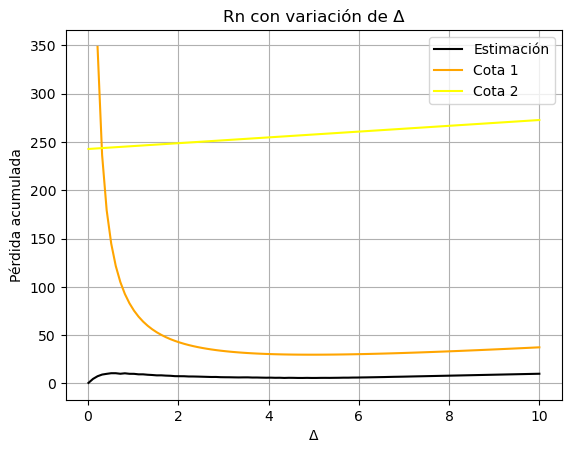

In [ ]:
# TH 7.2 CON VARIACION DE DELTA caso normal
from tqdm import tqdm
n=100
simula = 1000
regret_valores_UCB = [] #acumulador de regret
cotas_valores_UCB2 = [] #acumulador de las cotas th7.2
cotas_valores_UCB1 = [] #acumulador de las cotas th7.1
triangulovalores = np.linspace(0.01,10,100)  # valores de DELTA
for triangulo in tqdm(triangulovalores):
    pseudoregret_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([2, 2+triangulo])   # Reset the bandit for each simulation
        UCB(n, 1/(n**2))
        pseudoregret_valores.append(bandido.pseudoregret())
    regret_valores_UCB.append(np.mean(pseudoregret_valores))
    cotas_valores_UCB2.append(8*np.sqrt(n*bandido.K()*np.log(n))+3*triangulo)
    cotas_valores_UCB1.append(3*triangulo+16*np.log(n)/triangulo)


# GRAFICA PSEUDOREGRET
plt.plot(triangulovalores, regret_valores_UCB, 'k-', label='Estimación')  # Black line for regret
plt.plot(triangulovalores[2:], cotas_valores_UCB1[2:], 'orange', label='Cota 1')  # Orange line for cotas
plt.plot(triangulovalores, cotas_valores_UCB2, 'yellow', label='Cota 2')  # yellow line for cotas
plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Rn con variación de Δ')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 150/150 [31:20<00:00, 12.54s/it]


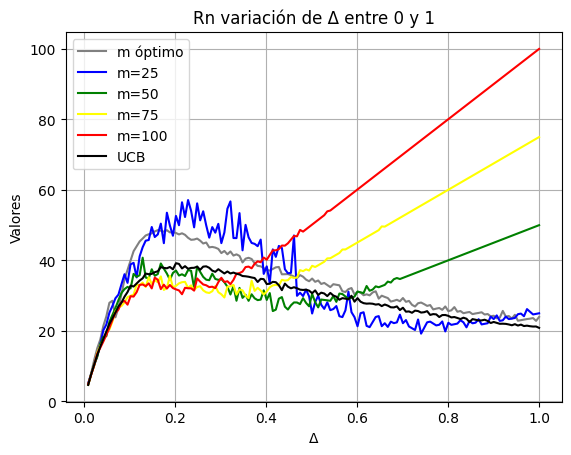

In [ ]:

# EXPERIMENTO 7.1 delta = 1/n^2
from tqdm import tqdm

simula = 10**3
regret_valoresmoptimo2 = [] #acumulador de regret para m optimo
regret_valoresm2 = [[],[],[],[]] #acumulador de regret para varios m
regret_valoresUCB2 = [] #acumulador de regret para UCB
n = 1000
mvalores = [25,50,75,100]
deltavalores = np.linspace(0.01, 1, 150)  # valores de delta
for delta in tqdm(deltavalores):
    pseudoregretmopt_valores = [] #acumulador de regret
    mopt = max(1, math.ceil(4/(delta**2)*np.log(n*delta**2/4)))  # Calculate m based on delta
    for _ in range(simula):
        bandido = NormalBandit([0, -delta])  # Reset the bandit for each simulation
        ETC(n, mopt)
        pseudoregretmopt_valores.append(bandido.pseudoregret())
    regret_valoresmoptimo2.append(np.mean(pseudoregretmopt_valores))
    for m in mvalores:
        pseudoregretm_valores = [] #acumulador de regret
        for _ in range(simula):
            bandido = NormalBandit([0, -delta])  # Reset the bandit for each simulation
            ETC(n, m)
            pseudoregretm_valores.append(bandido.pseudoregret())
        regret_valoresm2[mvalores.index(m)].append(np.mean(pseudoregretm_valores))
    pseudoregretUCB_valores = [] #acumulador de regret
    for _ in range(simula):
        bandido = NormalBandit([0, -delta])  # Reset the bandit for each simulation
        UCB(n,1/n**2)
        pseudoregretUCB_valores.append(bandido.pseudoregret())
    regret_valoresUCB2.append(np.mean(pseudoregretUCB_valores))


# Plotting
plt.plot(deltavalores, regret_valoresmoptimo2, 'grey', label='m óptimo')  # Black line for regret
plt.plot(deltavalores, regret_valoresm2[0], 'blue', label='m=25')
plt.plot(deltavalores, regret_valoresm2[1], 'green', label='m=50')
plt.plot(deltavalores, regret_valoresm2[2], 'yellow', label='m=75')
plt.plot(deltavalores, regret_valoresm2[3], 'red',label='m=100')  # Orange line for cotas
plt.plot(deltavalores, regret_valoresUCB2, 'k-', label='UCB')  # black line for cotas
plt.xlabel('Δ')
plt.ylabel('Valores')
plt.title('Rn variación de Δ entre 0 y 1')
plt.legend()
plt.grid(True)
plt.show()

# Comparativa ETC y UCB caso Normal

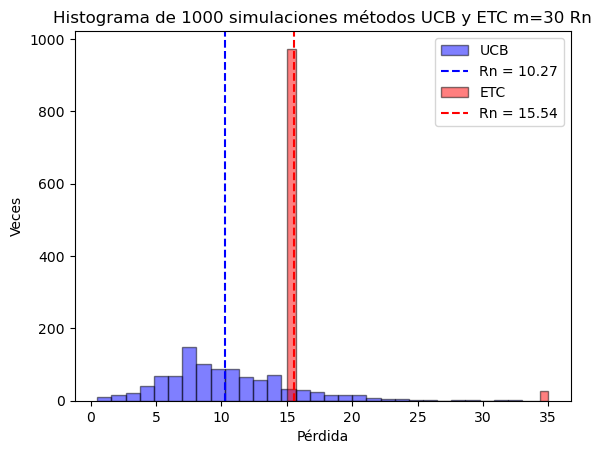

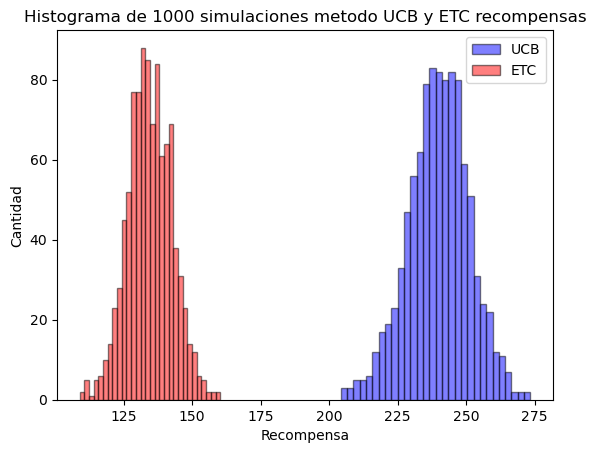

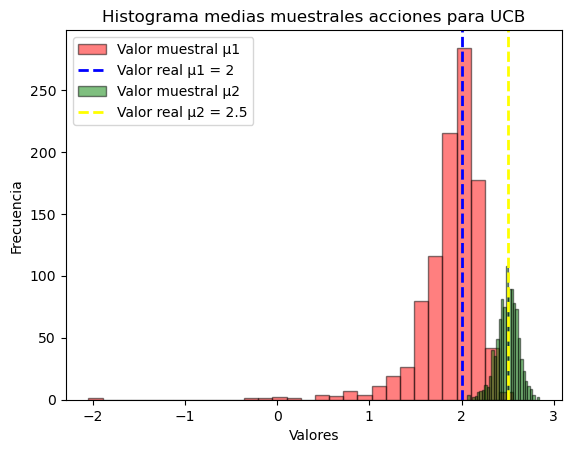

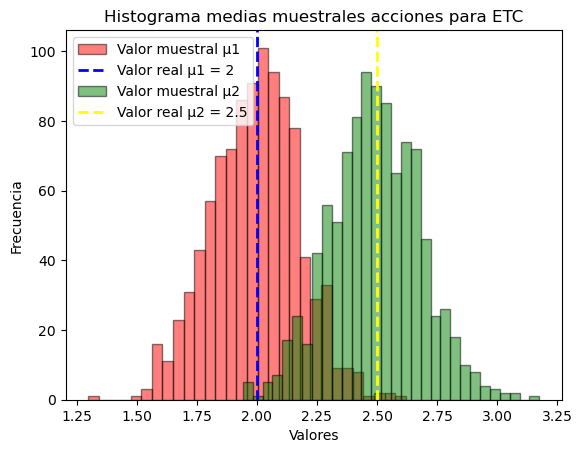

In [ ]:
com_regret_valores_UCB = [] #acumulador de regret UCB
com_medias_valores_UCB = [] #acumulador de regret UCB
com_recompensa_valores_UCB = [] #acumulador de regret UCB
com_regret_valores_ETC = [] #acumulador de regret ETC
com_medias_valores_ETC = [] #acumulador de regret ETC
com_recompensa_valores_ETC = [] #acumulador de regret ETC
simula = 1000 #numero de simulaciones
n = 100
m = 30
#nrondas = range(50, 101)  # valores de m desde 50 hasta 100
for _ in range(simula):
    bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
    (medUCB, recUCB) = UCB(n,1/(n**2))
    com_regret_valores_UCB.append(bandido.pseudoregret())
    com_medias_valores_UCB.append(medUCB)
    com_recompensa_valores_UCB.append(recUCB)
for _ in range(simula):
    bandido = NormalBandit([2,2.5])  # Reset the bandit for each simulation
    (medETC, recETC) = ETC(n,m)
    com_regret_valores_ETC.append(bandido.pseudoregret())
    com_medias_valores_ETC.append(medETC)
    com_recompensa_valores_ETC.append(recETC)

plt.hist(com_regret_valores_UCB, bins=30, edgecolor='black', color='blue', alpha=0.5, label='UCB')
real_regret_UCB = np.mean(com_regret_valores_UCB)
plt.axvline(real_regret_UCB, color='blue', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_UCB:.2f}")
plt.hist(com_regret_valores_ETC, bins=30, edgecolor='black', color='red', alpha=0.5, label='ETC')
real_regret_ETC = np.mean(com_regret_valores_ETC)
plt.axvline(real_regret_ETC, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_ETC:.2f}")
plt.xlabel("Pérdida")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones métodos UCB y ETC m="+str(m) +" Rn")
plt.legend()
plt.show()

plt.hist(com_recompensa_valores_UCB, bins=30, edgecolor='black', color='blue', alpha=0.5, label='UCB')
plt.hist(com_recompensa_valores_ETC, bins=30, edgecolor='black', color='red', alpha=0.5, label='ETC')
plt.xlabel("Recompensa")
plt.ylabel("Cantidad")
plt.title("Histograma de "+ str(simula) +" simulaciones metodo UCB y ETC recompensas")
plt.legend()
plt.show()

# separar las medias muestrales com_medias_valores_UCB
primeramediaUCB = [pares[0] for pares in com_medias_valores_UCB]
segundamediaUCB = [pares[1] for pares in com_medias_valores_UCB]

# UCB
plt.hist(primeramediaUCB, bins=30, edgecolor='black', color='red', alpha=0.5, label='Valor muestral μ1')
plt.axvline(x=2, color='blue', linestyle='dashed', linewidth=2, label='Valor real μ1 = 2')
plt.hist(segundamediaUCB, bins=30, edgecolor='black', color='green', alpha=0.5, label='Valor muestral μ2')
plt.axvline(x=2.5, color='yellow', linestyle='dashed', linewidth=2, label='Valor real μ2 = 2.5')
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.title("Histograma medias muestrales acciones para UCB")
plt.legend()
plt.show()

# separar las medias muestrales com_medias_valores_UCB
primeramediaETC = [pares[0] for pares in com_medias_valores_ETC]
segundamediaETC = [pares[1] for pares in com_medias_valores_ETC]

# ETC
plt.hist(primeramediaETC, bins=30, edgecolor='black', color='red', alpha=0.5, label='Valor muestral μ1')
plt.axvline(x=2, color='blue', linestyle='dashed', linewidth=2, label='Valor real μ1 = 2')
plt.hist(segundamediaETC, bins=30, edgecolor='black', color='green', alpha=0.5, label='Valor muestral μ2')
plt.axvline(x=2.5, color='yellow', linestyle='dashed', linewidth=2, label='Valor real μ2 = 2.5')
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.title("Histograma medias muestrales acciones para ETC")
plt.legend()
plt.show()


# Implementacion Bayesiana

## def caso bernoulli

 Caso de dos brazos (k=2)

 $X_{B1} \sim Ber(\theta_1)$


 $X_{B2} \sim Ber(\theta_2)$

PARA $t = 1:$

Simulamos un valor $\theta_1^1 \sim Be(1,1)$

Simulamos un valor $\theta_2^1 \sim Be(1,1)$

* Si $\theta_1^1>\theta_2^1$: Elegimos B1 y obtenemos recompensa $X_1\sim Ber(\theta_1)$.
Actualizamos $\theta_1|X_1 \sim Be(X_1 + 1, 1 - X_1 +1)$
* Si $\theta_1^1<\theta_2^1$: Elegimos B2 y obtenemos recompensa $X_1\sim Ber(\theta_2)$.
Actualizamos $\theta_2|X_1 \sim Be(X_1 + 1, 1 - X_1 +1)$

PARA $t\ge 2:$ (Suponiendo que estamos en el caso 1 para $t=1$)

Simulamos un valor $\theta_1^2 \sim Be(X_1 + 1, 1 - X_1 +1)$

Simulamos un valor $\theta_2^2 \sim Be(1,1)$

* Si $\theta_1^2>\theta_2^2$: Elegimos B1 y obtenemos recompensa $X_2\sim Ber(\theta_1)$.
Actualizamos $\theta_1|X_1,X_2 \sim Be(X_1 + X_2 + 1, 2 - X_1 - X_2 +1)$
* Si $\theta_1^2<\theta_2^2$: Elegimos B2 y obtenemos recompensa $X_2\sim Ber(\theta_2)$.
Actualizamos $\theta_2|X_2 \sim Be(X_2 + 1, 1 - X_2 +1)$



### Caso no informativo

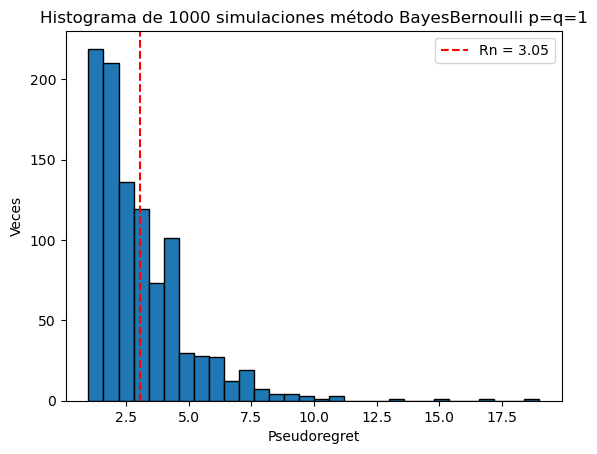

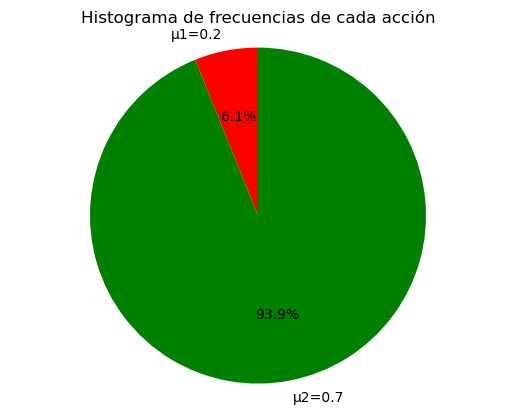

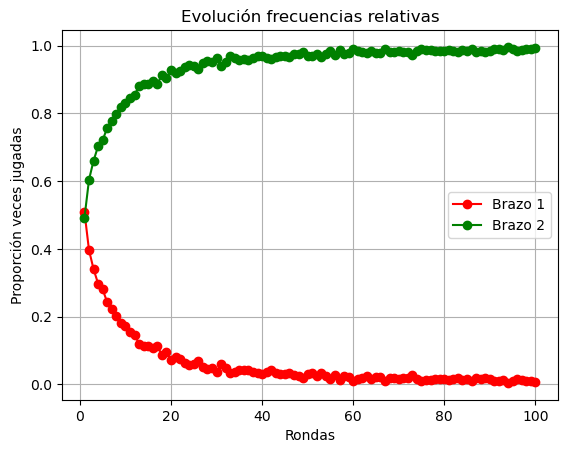

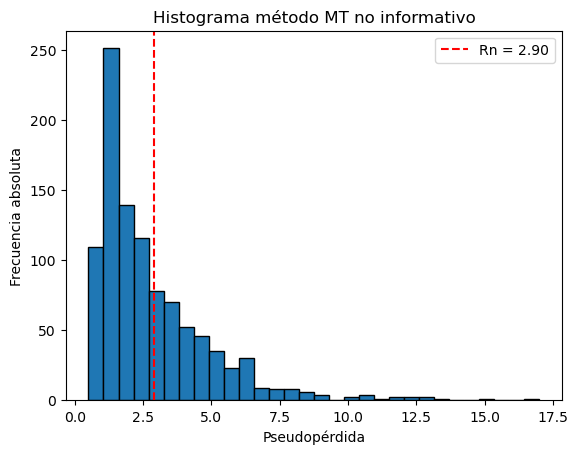

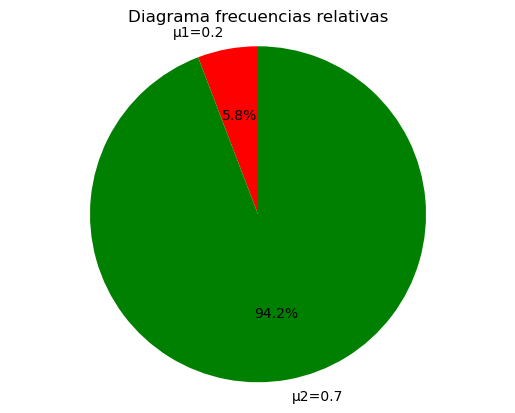

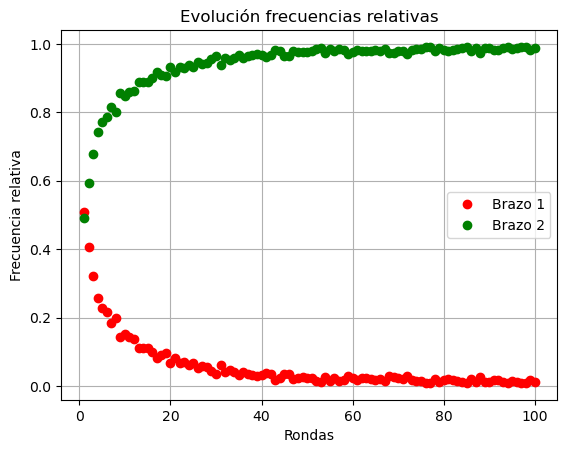

In [9]:
def BayesBernoulli(n,parAPriori, bandido): #n para horizonte y parAPriori son los parametros de las betas a priori (p,q) en una unica lista [p_1,q_1,p_2,q_2,...]
    recompensas = np.zeros(bandido.K()) #para ir acumulando las recompensas
    brazosjugados = np.zeros(n, dtype=int) #para ir acumulandoen cada ronda el brazo jugado
    for t in range(n):
        thetasupt = [0 for _ in range(bandido.K())] #para ir acumulando las thetas_k^t
        for k in range(bandido.K()): # simulamos thetas_k^t segun "betas priori"
            thetasupt[k] = np.random.beta(parAPriori[2*k]+recompensas[k],parAPriori[2*k+1]+(bandido.frecuency()[k])-recompensas[k]) # bandido.frecuency()[k] para sumar las veces "n"
        At = thetasupt.index(max(thetasupt)) #elegimos la accion con la mayor theta^t
        recompensas[At] += bandido.pull(At)
        brazosjugados[t] = At #guardamos el brazo jugado en cada ronda
    return(brazosjugados)


# Simulaciones 2 BRAZOS p=q=1
n = 100 #horizonte
simula = 1000 #numero de simulaciones
K = 2 #numero de brazos
pseudoregret_valores_BayesBernoulli = [] #acumulador pseudoregret
frecuencias_BayesBernoulli = [0,0] #acumulador de frecuencias de cada accion
acumbrazos = np.zeros((n,K)) #acumulador de brazos jugados por rondas
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [1,1,1,1],bandido) # beta(1,1) es la beta a priori para cada brazo
    pseudoregret_valores_BayesBernoulli.append(bandido.pseudoregret())
    frecuencias_BayesBernoulli[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesBernoulli[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_BayesBernoulli, bins=30, edgecolor='black')
real_regret_BayesBernoulli = np.mean(pseudoregret_valores_BayesBernoulli)
plt.axvline(real_regret_BayesBernoulli, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesBernoulli:.2f}")
plt.xlabel("Pseudoregret")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones método BayesBernoulli p=q=1")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_BayesBernoulli[0] / simula, frecuencias_BayesBernoulli[1] / simula], labels = ["μ1=0.2", "μ2=0.7"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Histograma de frecuencias de cada acción")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1Noinfo = acumbrazos[:,0] / simula
brazo2Noinfo = acumbrazos[:,1] / simula
plt.plot(x, brazo1Noinfo, marker='o', linestyle='-', color='red', label='Brazo 1')
plt.plot(x, brazo2Noinfo, marker='o', linestyle='-', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Proporción veces jugadas')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()


# Simulaciones 2 BRAZOS p=q=0.5
n = 100 #horizonte
simula = 1000 #numero de simulaciones
K = 2
pseudoregret_valores_BayesBernoulli = []  #acumulador pseudoregret
frecuencias_BayesBernoulli = [0,0] #acumulador de frecuencias de cada accion
acumbrazos = np.zeros((n,K)) #acumulador de brazos jugados por rondas
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [0.5,0.5,0.5,0.5],bandido) # beta(0.5,0.5) es la beta a priori para cada brazo
    pseudoregret_valores_BayesBernoulli.append(bandido.pseudoregret())
    frecuencias_BayesBernoulli[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesBernoulli[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1


#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_BayesBernoulli, bins=30, edgecolor='black')
real_regret_BayesBernoulli = np.mean(pseudoregret_valores_BayesBernoulli)
plt.axvline(real_regret_BayesBernoulli, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesBernoulli:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta") 
plt.title("Histograma método MT no informativo")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_BayesBernoulli[0] / simula, frecuencias_BayesBernoulli[1] / simula], labels = ["μ1=0.2", "μ2=0.7"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1jeffry = acumbrazos[:,0] / simula
brazo2jeffry = acumbrazos[:,1] / simula
plt.plot(x, brazo1jeffry, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2jeffry, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()


In [12]:
print("Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de:", brazo2jeffry[0])
print("Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de:", brazo2jeffry[4])
print("Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2jeffry[99])

Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de: 0.495
Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de: 0.776
Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.991


In [75]:
# Parámetros de la Beta, centrada: p-1/(p+q-2) y varianza: pq/((p+q)^2(p+q+1))
# Empezando con la buena informacion sobre la distribucion a priori
def centrada(p,q):
    return (p-1)/(p+q-2)
def varianza(p,q):
    return (p*q)/((p+q)**2*(p+q+1))
# queremos que para p_1,q_1 este centrada en 0.3 aproximadamente
# p_1 = 4, q_1 = 13
p1 = 5
q1 = 3
print("Valor esperado de la beta centrada en 0.2: ", centrada(p1,q1)," varianza: ", varianza(p1,q1))
# queremos que para p_2,q_2 este centrada en 0.6 aproximadamente
# p_2 = 6, q_2 = 3
p2 = 6
q2 = 3
print("Valor esperado de la beta centrada en 0.6: ", centrada(p2,q2)," varianza: ", varianza(p2,q2))

Valor esperado de la beta centrada en 0.2:  0.6666666666666666  varianza:  0.026041666666666668
Valor esperado de la beta centrada en 0.6:  0.7142857142857143  varianza:  0.022222222222222223


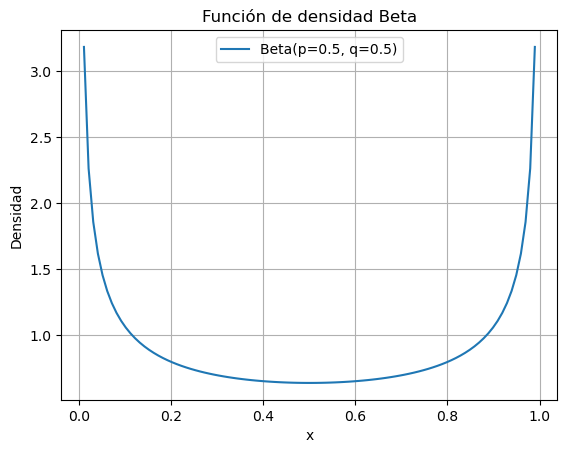

NameError: name 'centrada' is not defined

In [ ]:
# Valores de x entre 0 y 1, p y q
x = np.linspace(0, 1, 100)
p = 0.5
q = 0.5

# Densidad de la Beta
y = beta.pdf(x, p, q)

# Gráfica
plt.plot(x, y, label=f'Beta(p={p}, q={q})')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.title('Función de densidad Beta')
plt.legend()
plt.grid(True)
plt.show()

print("Valor esperado de la beta centrada en 0.2: ", centrada(p,q)," varianza: ", varianza(p,q))

In [161]:
# Parámetros de la Beta, centrada: p-1/(p+q-2) y varianza: pq/((p+q)^2(p+q+1))
# Continuando con la mala informacion sobre la distribucion a priori
# queremos que para p_1,q_1 este centrada en 0.5 aproximadamente
p1 = 19
q1 = 4
print("Valor esperado de la beta centrada en 0.5: ", centrada(p1,q1)," varianza: ", varianza(p1,q1))
# queremos que para p_2,q_2 este centrada en 0.4 aproximadamente
p2 = 5
q2 = 6
print("Valor esperado de la beta centrada en 0.4: ", centrada(p2,q2)," varianza: ", varianza(p2,q2))

Valor esperado de la beta centrada en 0.5:  0.8571428571428571  varianza:  0.0059861373660995585
Valor esperado de la beta centrada en 0.4:  0.4444444444444444  varianza:  0.02066115702479339


### Caso informativo

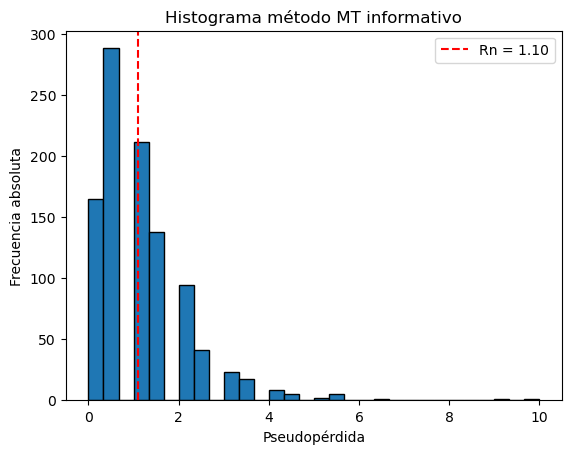

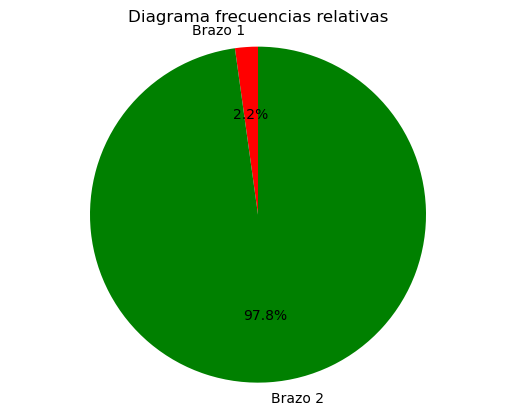

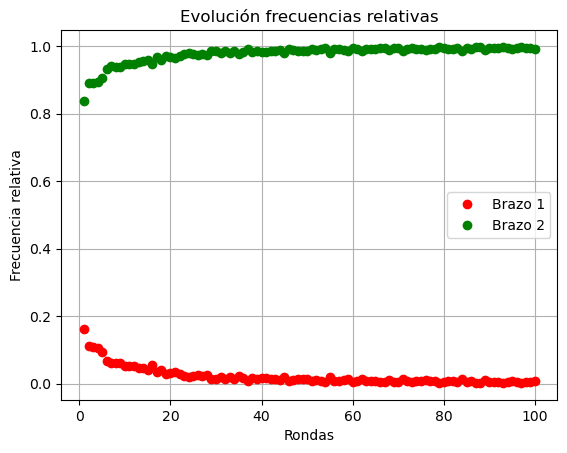

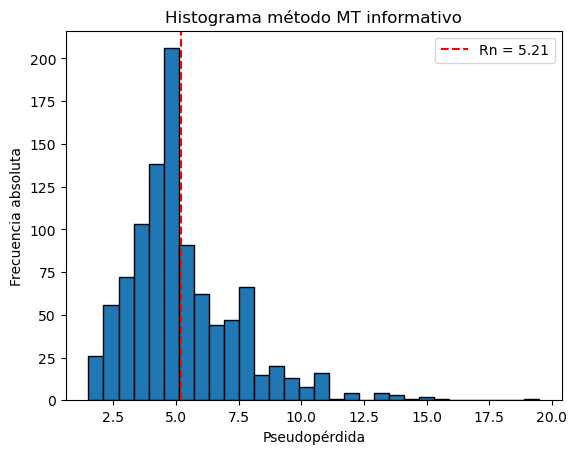

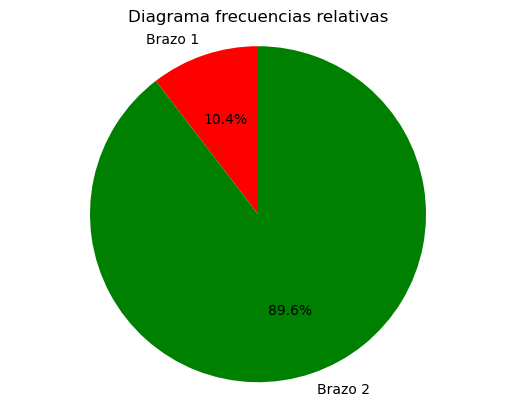

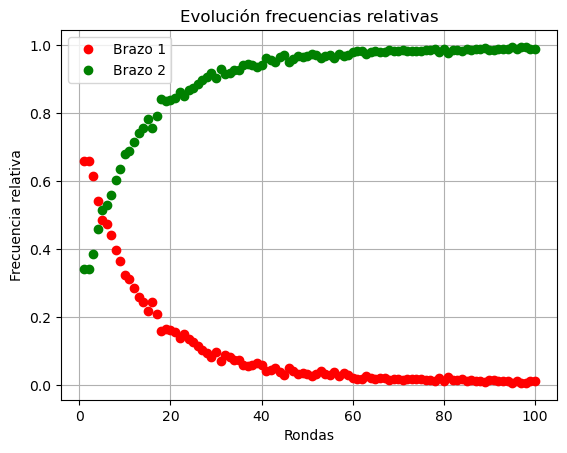

In [12]:

# Simulaciones 2 BRAZOS BUENA INFORMACION A PRIORI
n = 100 #horizonte
simula = 1000 #numero de simulaciones
K = 2
pseudoregret_valores_BayesBernoulli = [] #acumulador pseudoregret
frecuencias_BayesBernoulli = [0,0] #acumulador de frecuencias de cada accion
acumbrazos = np.zeros((n,K)) #acumulador de brazos jugados por rondas
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [4,8,4,3],bandido)
    pseudoregret_valores_BayesBernoulli.append(bandido.pseudoregret())
    frecuencias_BayesBernoulli[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesBernoulli[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_BayesBernoulli, bins=30, edgecolor='black')
real_regret_BayesBernoulli = np.mean(pseudoregret_valores_BayesBernoulli)
plt.axvline(real_regret_BayesBernoulli, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesBernoulli:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta") 
plt.title("Histograma método MT informativo")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_BayesBernoulli[0] / simula, frecuencias_BayesBernoulli[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1buenainfo = acumbrazos[:,0] / simula
brazo2buenainfo = acumbrazos[:,1] / simula
plt.plot(x, brazo1buenainfo, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2buenainfo, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()


# Simulaciones 2 BRAZOS MALA INFORMACION A PRIORI
n = 100 #horizonte
simula = 1000 #numero de simulaciones
K = 2
pseudoregret_valores_BayesBernoulli = []  #acumulador pseudoregret
frecuencias_BayesBernoulli = [0,0] #acumulador de frecuencias de cada accion
acumbrazos = np.zeros((n,K)) #acumulador de brazos jugados por rondas
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.7])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [5,4,5,6],bandido)
    pseudoregret_valores_BayesBernoulli.append(bandido.pseudoregret())
    frecuencias_BayesBernoulli[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesBernoulli[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1


#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_BayesBernoulli, bins=30, edgecolor='black')
real_regret_BayesBernoulli = np.mean(pseudoregret_valores_BayesBernoulli)
plt.axvline(real_regret_BayesBernoulli, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesBernoulli:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta") 
plt.title("Histograma método MT informativo")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_BayesBernoulli[0] / simula, frecuencias_BayesBernoulli[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1malainfo = acumbrazos[:,0] / simula
brazo2malainfo = acumbrazos[:,1] / simula
plt.plot(x, brazo1malainfo, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2malainfo, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()


In [62]:
print("Caso bueno: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de:", brazo2buenainfo[0])
print("Caso bueno: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2buenainfo[99])
print("Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de:", brazo2malainfo[0])
print("Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de:", brazo2malainfo[4])
print("Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2malainfo[99])

Caso bueno: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de: 0.838
Caso bueno: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.998
Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de: 0.316
Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de: 0.508
Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.99


Caso de bandido no info 4 brazos

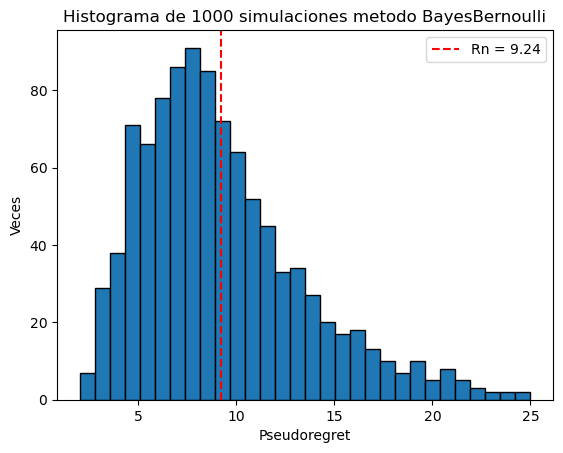

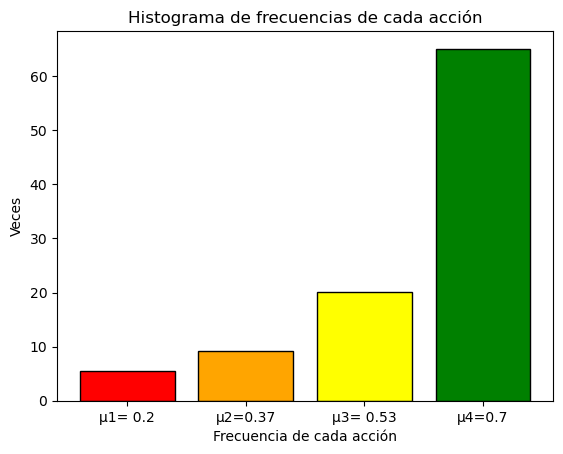

In [ ]:
# Simulaciones 4 BRAZOS p=q=1
n=100
simula = 1000
pseudoregret_valores_BayesBernoulli = [] #
frecuencias_BayesBernoulli = [0,0,0,0] #
for _ in range(simula):
    bandido = BernoulliBandit([0.2, 0.37, 0.53, 0.7])  # Reset the bandit for each simulation
    BayesBernoulli(n, [1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la beta a priori para cada brazo
    pseudoregret_valores_BayesBernoulli.append(bandido.pseudoregret())
    frecuencias_BayesBernoulli[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesBernoulli[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    frecuencias_BayesBernoulli[2] += bandido.frecuency()[2] #frecuencia de la accion 3
    frecuencias_BayesBernoulli[3] += bandido.frecuency()[3] #frecuencia de la accion 4

plt.hist(pseudoregret_valores_BayesBernoulli, bins=30, edgecolor='black')
real_regret_BayesBernoulli = np.mean(pseudoregret_valores_BayesBernoulli)
plt.axvline(real_regret_BayesBernoulli, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesBernoulli:.2f}")
plt.xlabel("Pseudoregret")
plt.ylabel("Veces")
plt.title("Histograma de "+ str(simula) +" simulaciones metodo BayesBernoulli")
plt.legend()
plt.show()
plt.bar(["μ1= 0.2", "μ2=0.37","μ3= 0.53", "μ4=0.7"], [frecuencias_BayesBernoulli[0] / simula, frecuencias_BayesBernoulli[1] / simula,frecuencias_BayesBernoulli[2] / simula,frecuencias_BayesBernoulli[3] / simula], color=['red','orange','yellow', 'green'], edgecolor='black')
plt.xlabel("Frecuencia de cada acción")
plt.ylabel("Veces")
plt.title("Histograma de frecuencias de cada acción")
plt.show()

## def caso normal

### Caso no informativo

Simular con media 0 y varianza grande

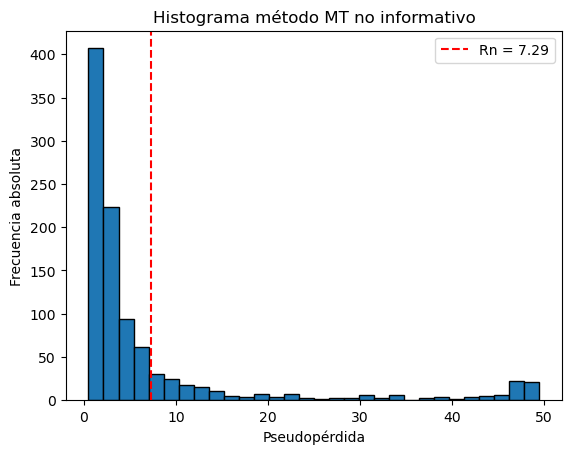

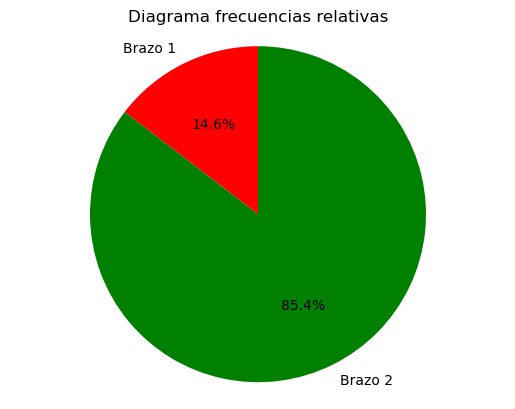

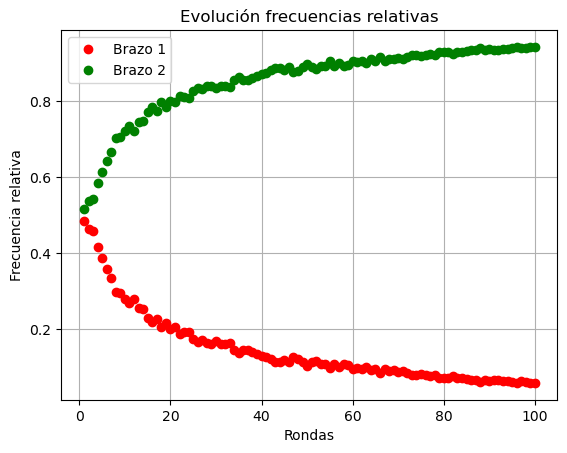

In [17]:
#Caso mt normal no informativo

def BayesNormalNoInfo(n,varianzas): #n para horizonte y mAPRriori son los m_0, sigma_0 (medias/varianza de cada brazo a priori) y varianzas son las varianzas de cada brazo CONOCIDAS
    recompensas = np.zeros(bandido.K()) #para ir acumulando las recompensas y jugadas
    brazosjugados = np.zeros(n, dtype=int) #para ir acumulandoen cada ronda el brazo jugado
    for t in range(n):
        musupt = [0 for _ in range(bandido.K())] #para ir acumulando las mu_a^t
        for k in range(bandido.K()): # simulamos mu_a^t
            if (bandido.frecuency()[k] == 0): # El brazo no ha sido jugado anteriormente
                musupt[k] = random.gauss(0,10**5) #Normal media 0 y varianza "infinita"
            else: #esta parte es normal de recompensas[k]/frecuencia = media muestral y varianza[k]/frecuencia
                musupt[k] = random.gauss(recompensas[k]/(bandido.frecuency()[k]), varianzas[k]/(bandido.frecuency()[k])) # bandido.frecuency()[k] para sumar las veces "n"
        At = musupt.index(max(musupt)) #elegimos la accion con la mayor m^t
        recompensas[At] += bandido.pull(At)
        brazosjugados[t] = At
    return(brazosjugados)

# Simulaciones medias 0 y varianzas 1
simula = 1000
n= 100
K = 2
pseudoregret_valores_BayesNormalNoInfo = [] #acumulador pseudoregret
frecuencias_BayesNormalNoInfo = [0,0] #frecuencia de cada accion
acumbrazos = np.zeros((n,K)) #acumulador de brazos jugados por rondas

for _ in range(simula):
    bandido = NormalBandit([2,2.5])
    brazosjugados = BayesNormalNoInfo(n, [1,1])
    pseudoregret_valores_BayesNormalNoInfo.append(bandido.pseudoregret())
    frecuencias_BayesNormalNoInfo[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesNormalNoInfo[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_BayesNormalNoInfo, bins=30, edgecolor='black')
real_regret_BayesNormalNoInfo = np.mean(pseudoregret_valores_BayesNormalNoInfo)
plt.axvline(real_regret_BayesNormalNoInfo, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesNormalNoInfo:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta")
plt.title("Histograma método MT no informativo")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_BayesNormalNoInfo[0] / simula, frecuencias_BayesNormalNoInfo[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1 = acumbrazos[:,0] / simula
brazo2 = acumbrazos[:,1] / simula
plt.plot(x, brazo1, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
print("Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de:", brazo2[0])
print("Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de:", brazo2[4])
print("Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2[99])

Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de: 0.507
Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de: 0.624
Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.94


### Caso informativo

Siguiendo el ejemplo bernoulli:

 Caso buena informacion, aumentamos 50% media brazo 1 y disminuimos 15% media brazo 2
 
 Caso mala informacion, aumentamos 185% media brazo 1 y disminuimos 37% media brazo 2

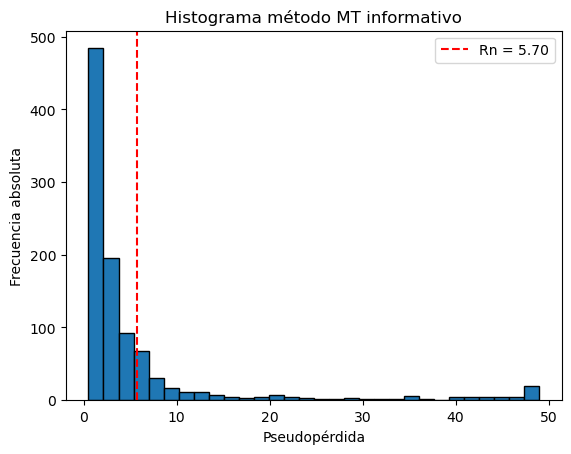

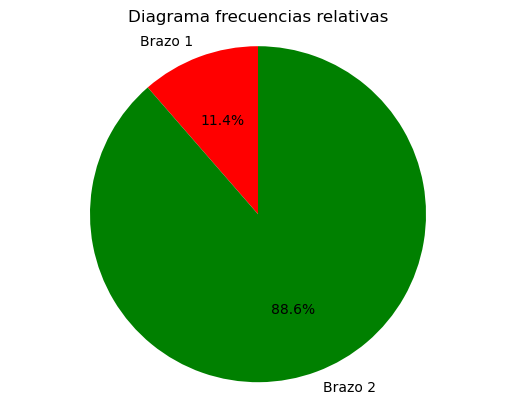

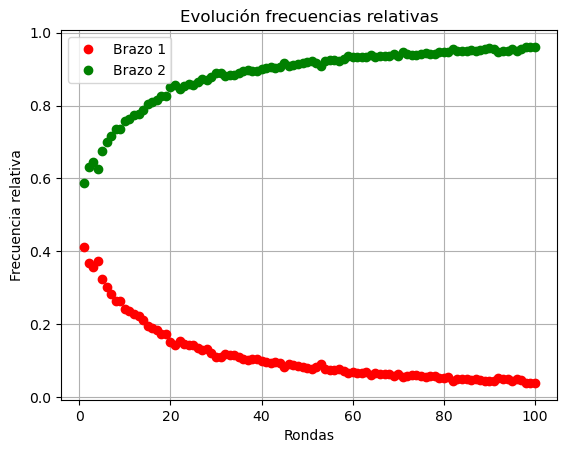

In [13]:
def BayesNormalInfo(n,msAPriori,varianzas): #n para horizonte y mAPRriori son los m_0, sigma_0 (medias/varianza de cada brazo a priori) y varianzas son las varianzas de cada brazo CONOCIDAS
    recompensas = np.zeros(bandido.K()) #para ir acumulando las recompensas y jugadas
    brazosjugados = np.zeros(n, dtype=int) #para ir acumulandoen cada ronda el brazo jugado
    for t in range(n):
        musupt = [0 for _ in range(bandido.K())] #para ir acumulando las m_k^t
        for k in range(bandido.K()): # simulamos ms_k^t
            if bandido.frecuency()[k] == 0:
                musupt[k] = random.gauss((msAPriori[2*k]),msAPriori[2*k+1])
            else:
                musupt[k] = random.gauss((bandido.frecuency()[k]/varianzas[k]*(recompensas[k]/bandido.frecuency()[k])+msAPriori[2*k]/msAPriori[2*k+1])/(bandido.frecuency()[k]/varianzas[k]+1/msAPriori[2*k+1]),1/(bandido.frecuency()[k]/varianzas[k]+1/msAPriori[2*k+1])) # bandido.frecuency()[k] para sumar las veces "n"
        At = musupt.index(max(musupt)) #elegimos la accion con la mayor m^t
        recompensas[At] += bandido.pull(At)
        brazosjugados[t] = At
    return(brazosjugados)


# Simulaciones para buena informacion a priori
simula = 1000
n= 100
K = 2
pseudoregret_valores_BayesNormalInfo = [] #
frecuencias_BayesNormalInfo = [0,0] #frecuencia de cada accion
acumbrazos = np.zeros((n,K)) #acumulador de brazos jugados por rondas
for _ in range(simula):
    bandido = NormalBandit([2,2.5])
    brazosjugados = BayesNormalInfo(n, [2.1,1,2.4,1] , [1,1]) #[3,1,2.1,1] alternativa [2.3,1,2.5,1]
    pseudoregret_valores_BayesNormalInfo.append(bandido.pseudoregret())
    frecuencias_BayesNormalInfo[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesNormalInfo[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_BayesNormalInfo, bins=30, edgecolor='black')
real_regret_BayesNormalInfo = np.mean(pseudoregret_valores_BayesNormalInfo)
plt.axvline(real_regret_BayesNormalInfo, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesNormalInfo:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta") 
plt.title("Histograma método MT informativo")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_BayesNormalInfo[0] / simula, frecuencias_BayesNormalInfo[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1buenainfo = acumbrazos[:,0] / simula
brazo2buenainfo = acumbrazos[:,1] / simula
plt.plot(x, brazo1buenainfo, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2buenainfo, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()




In [23]:
print("Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de:", brazo2buenainfo[0])
print("Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de:", brazo2buenainfo[4])
print("Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2buenainfo[99])

Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de: 0.593
Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de: 0.685
Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.951


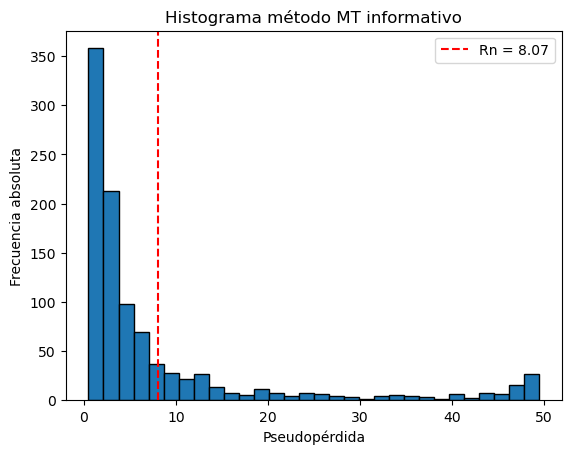

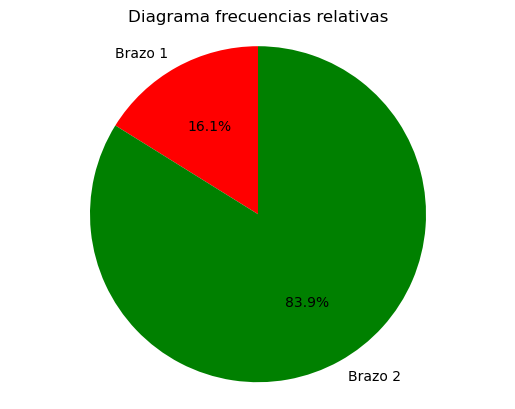

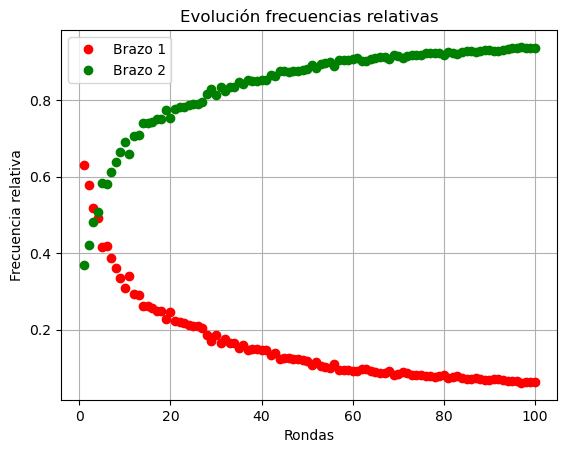

In [14]:

# Simulaciones para mala informacion a priori
simula = 1000
n= 100
K = 2
pseudoregret_valores_BayesNormalInfo = [] #
frecuencias_BayesNormalInfo = [0,0] #frecuencia de cada accion
acumbrazos = np.zeros((n,K)) #acumulador de brazos jugados por rondas
for _ in range(simula):
    bandido = NormalBandit([2,2.5])
    brazosjugados = BayesNormalInfo(n, [2.5,1,2,1] , [1,1]) 
    pseudoregret_valores_BayesNormalInfo.append(bandido.pseudoregret())
    frecuencias_BayesNormalInfo[0] += bandido.frecuency()[0] #frecuencia de la accion 1
    frecuencias_BayesNormalInfo[1] += bandido.frecuency()[1] #frecuencia de la accion 2
    for t in range(n): # Guardamos el brazo jugado en cada ronda
        acumbrazos[t][brazosjugados[t]] += 1

#GRAFICAS PSEUDOREGRETS
plt.hist(pseudoregret_valores_BayesNormalInfo, bins=30, edgecolor='black')
real_regret_BayesNormalInfo = np.mean(pseudoregret_valores_BayesNormalInfo)
plt.axvline(real_regret_BayesNormalInfo, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {real_regret_BayesNormalInfo:.2f}")
plt.xlabel("Pseudopérdida")
plt.ylabel("Frecuencia absoluta") 
plt.title("Histograma método MT informativo")
plt.legend()
plt.show()
#GRAFICAS FRECUENCIAS
fig, ax = plt.subplots()
ax.pie([frecuencias_BayesNormalInfo[0] / simula, frecuencias_BayesNormalInfo[1] / simula], labels = ["Brazo 1", "Brazo 2"], colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Diagrama frecuencias relativas")
plt.show()
#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
x = np.arange(1, n+1) # rondas horizonte
brazo1malainfo = acumbrazos[:,0] / simula
brazo2malainfo = acumbrazos[:,1] / simula
plt.plot(x, brazo1malainfo, marker='o', linestyle='none', color='red', label='Brazo 1')
plt.plot(x, brazo2malainfo, marker='o', linestyle='none', color='green', label='Brazo 2')
plt.xlabel('Rondas')
plt.ylabel('Frecuencia relativa')
plt.title('Evolución frecuencias relativas')
plt.grid(True)
plt.legend()
plt.show()


In [25]:
print("Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de:", brazo2malainfo[0])
print("Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de:", brazo2malainfo[4])
print("Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de:", brazo2malainfo[99])

Caso malo: A partir de la primera ronda, la probabilidad de elegir el brazo 2 es de: 0.344
Caso malo: A partir de la primera 5º ronda, la probabilidad de elegir el brazo 2 es de: 0.553
Caso malo: A partir de la última ronda, la probabilidad de elegir el brazo 2 es de: 0.931


## Teorema acotación

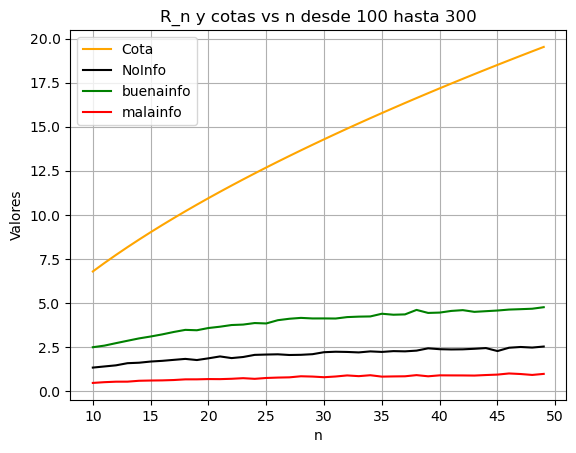

In [ ]:
# Simulacion 1
simula = 1000

regret_valores_MT_NoInfo = [] #acumulador de regret sin info
regret_valores_MT_MalaInfo = [] #acumulador de regret con mala info
regret_valores_MT_BuenaInfo = [] #acumulador de regret con buena info
cotas_valores_MT = [] #acumulador de las cotas
nrondas = range(10, 50)  # valores de n desde 50 hasta 100
for n in nrondas:
    pseudoregret_valores_NoInfo = [] #acumulor pseudoregret sin info
    pseudoregret_valores_MalaInfo = [] #acumulor pseudoregret mala info
    pseudoregret_valores_BuenaInfo = [] #acumulor pseudoregret buena info
    for _ in range(simula):
        bandido1 = BernoulliBandit([0.2,0.7])  # Vamos a generar un bandido para cada metodo
        bandido2 = BernoulliBandit([0.2,0.7])  # Vamos a generar un bandido para cada metodo
        bandido3 = BernoulliBandit([0.2,0.7])  # Vamos a generar un bandido para cada metodo
        BayesBernoulli(n, [0.5,0.5,0.5,0.5],bandido1) #sin info
        BayesBernoulli(n, [5,4,5,6],bandido2) # buena info
        BayesBernoulli(n, [4,8,4,3],bandido3) #mala info
        pseudoregret_valores_NoInfo.append(bandido1.pseudoregret())
        pseudoregret_valores_BuenaInfo.append(bandido2.pseudoregret())
        pseudoregret_valores_MalaInfo.append(bandido3.pseudoregret())
    regret_valores_MT_NoInfo.append(np.mean(pseudoregret_valores_NoInfo))
    regret_valores_MT_BuenaInfo.append(np.mean(pseudoregret_valores_BuenaInfo))
    regret_valores_MT_MalaInfo.append(np.mean(pseudoregret_valores_MalaInfo))
    cotas_valores_MT.append(np.sqrt(bandido3.K()*n*np.log(n)))

# Plotting
plt.plot(nrondas, cotas_valores_MT, 'orange', label='Cota')  
plt.plot(nrondas, regret_valores_MT_NoInfo, '-k', label='NoInfo')  
plt.plot(nrondas, regret_valores_MT_BuenaInfo, 'green', label='buenainfo')  
plt.plot(nrondas, regret_valores_MT_MalaInfo, 'red', label='malainfo')  
plt.xlabel('n')
plt.ylabel('Valores')
plt.title('R_n y cotas vs n desde 100 hasta 300')
plt.legend()
plt.grid(True)
plt.show()

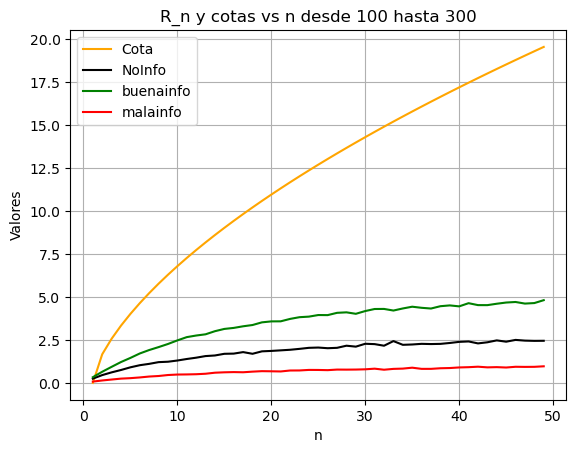

In [13]:
# Simulacion 2
simula = 1000

regret_valores_MT_NoInfo = [] #acumulador de regret sin info
regret_valores_MT_MalaInfo = [] #acumulador de regret con mala info
regret_valores_MT_BuenaInfo = [] #acumulador de regret con buena info
cotas_valores_MT = [] #acumulador de las cotas
nrondas = range(1, 50)  # valores de n desde 50 hasta 100
for n in nrondas:
    pseudoregret_valores_NoInfo = [] #acumulor pseudoregret sin info
    pseudoregret_valores_MalaInfo = [] #acumulor pseudoregret mala info
    pseudoregret_valores_BuenaInfo = [] #acumulor pseudoregret buena info
    for _ in range(simula):
        bandido1 = BernoulliBandit([0.2,0.7])  # Vamos a generar un bandido para cada metodo
        bandido2 = BernoulliBandit([0.2,0.7])  # Vamos a generar un bandido para cada metodo
        bandido3 = BernoulliBandit([0.2,0.7])  # Vamos a generar un bandido para cada metodo
        BayesBernoulli(n, [0.5,0.5,0.5,0.5],bandido1) #sin info
        BayesBernoulli(n, [5,4,5,6],bandido2) # buena info
        BayesBernoulli(n, [4,8,4,3],bandido3) #mala info
        pseudoregret_valores_NoInfo.append(bandido1.pseudoregret())
        pseudoregret_valores_BuenaInfo.append(bandido2.pseudoregret())
        pseudoregret_valores_MalaInfo.append(bandido3.pseudoregret())
    regret_valores_MT_NoInfo.append(np.mean(pseudoregret_valores_NoInfo))
    regret_valores_MT_BuenaInfo.append(np.mean(pseudoregret_valores_BuenaInfo))
    regret_valores_MT_MalaInfo.append(np.mean(pseudoregret_valores_MalaInfo))
    cotas_valores_MT.append(np.sqrt(bandido3.K()*n*np.log(n)))

# Plotting
plt.plot(nrondas, cotas_valores_MT, 'orange', label='Cota')  
plt.plot(nrondas, regret_valores_MT_NoInfo, '-k', label='NoInfo')  
plt.plot(nrondas, regret_valores_MT_BuenaInfo, 'green', label='buenainfo')  
plt.plot(nrondas, regret_valores_MT_MalaInfo, 'red', label='malainfo')  
plt.xlabel('n')
plt.ylabel('Valores')
plt.title('R_n y cotas vs n desde 100 hasta 300')
plt.legend()
plt.grid(True)
plt.show()

# Comparación todos los metodos


* Aumentar el numero de brazos hasta 10 ( 2 buenos 2 malos y el resto mediocres ) --> HECHO

* Aumentar horizonte y mostrar, ademas de la perdida acumulada, la proporcion / n  --> HECHO

* Aumentar $\Delta$ entre el mejor y el segundo mejor & el mejor y el resto --> HECHO




## Bernoulli

### 10 brazos

100%|██████████| 1000/1000 [00:10<00:00, 99.53it/s]


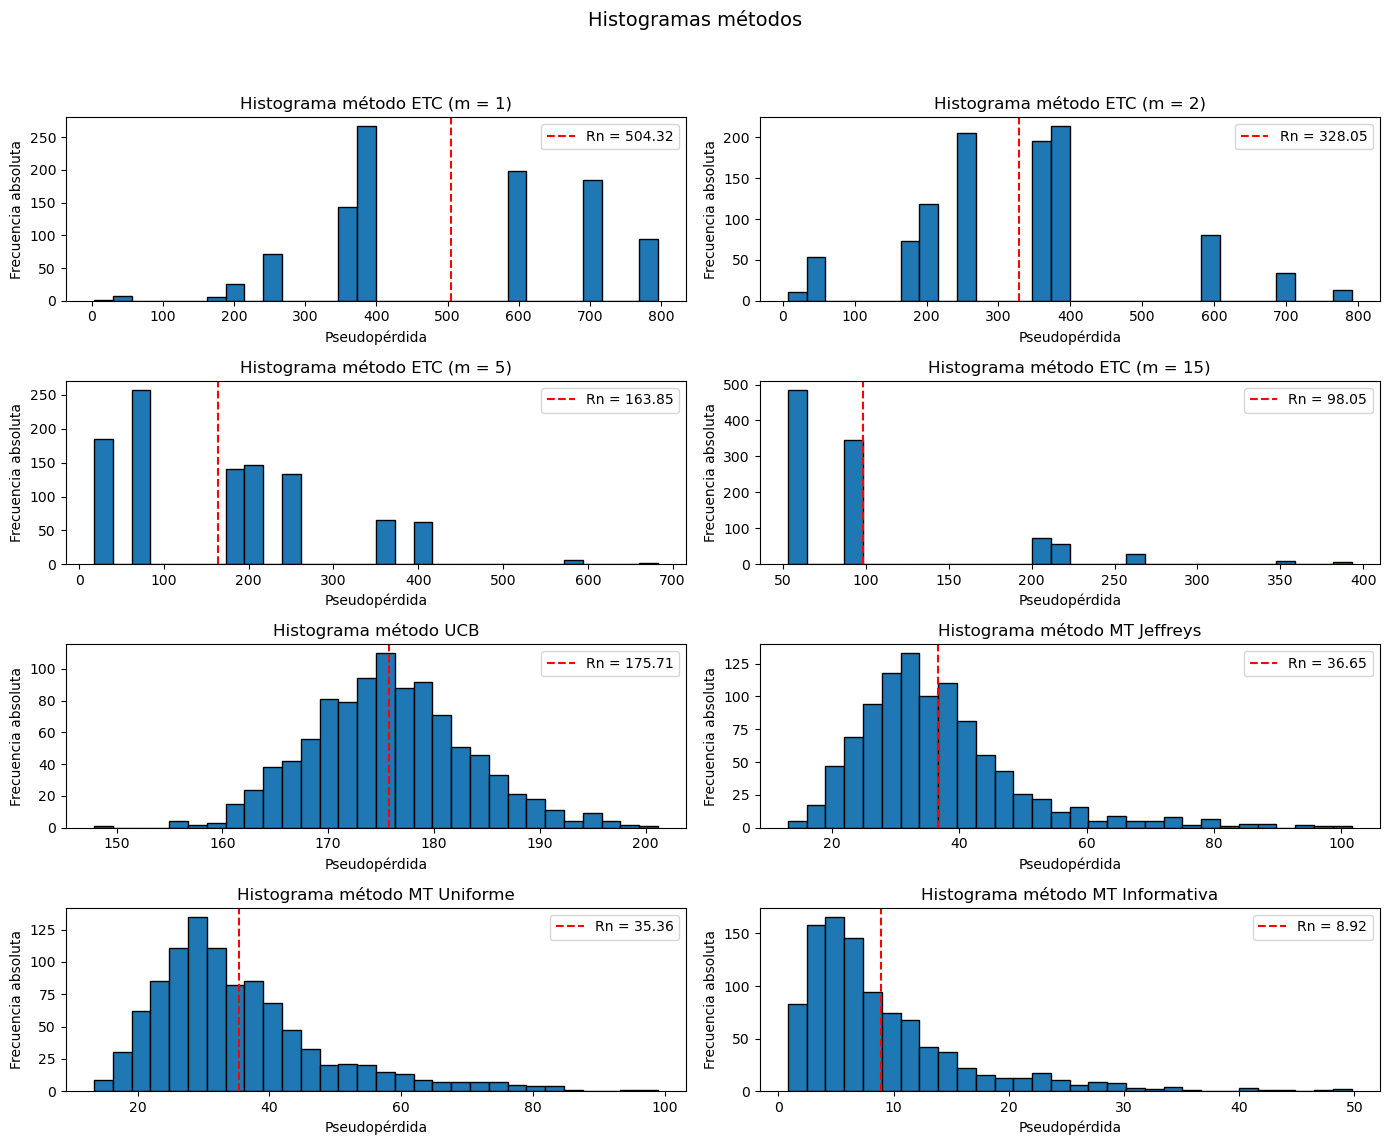

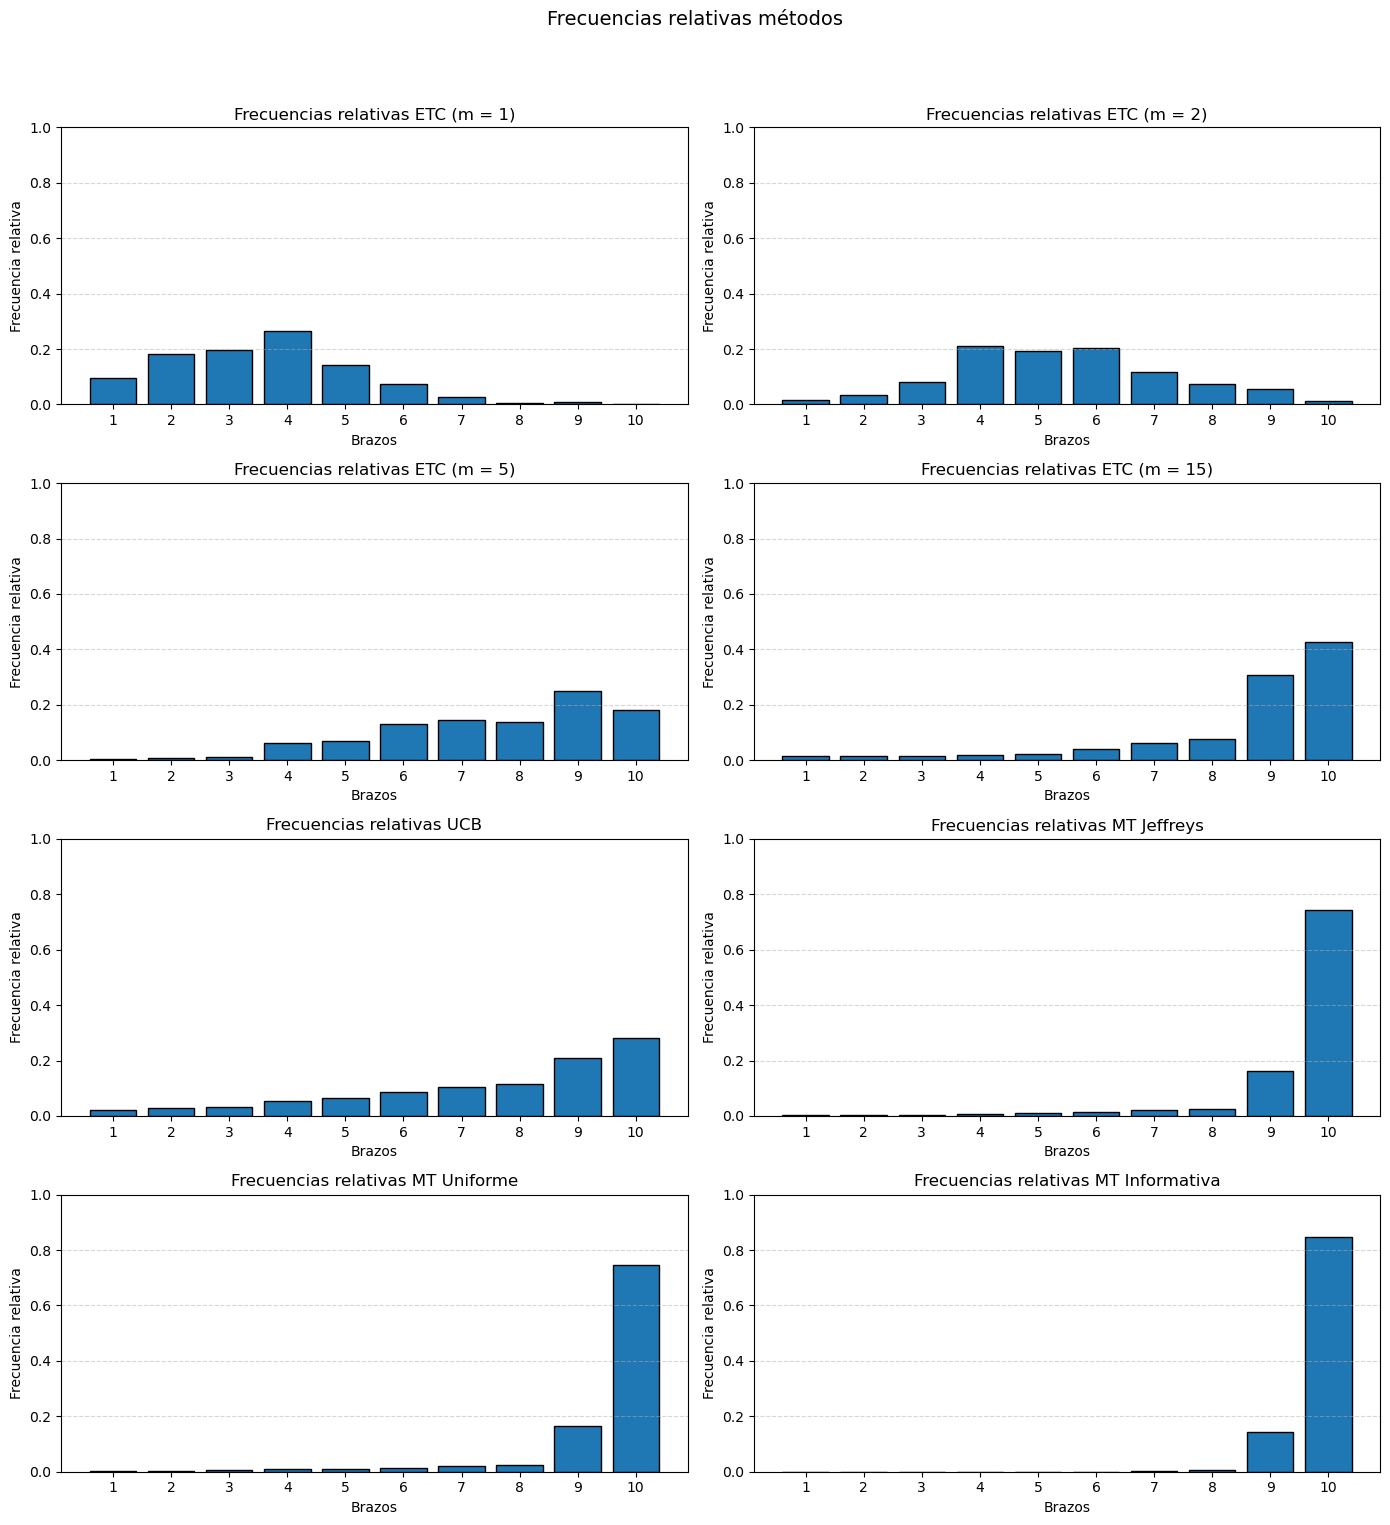

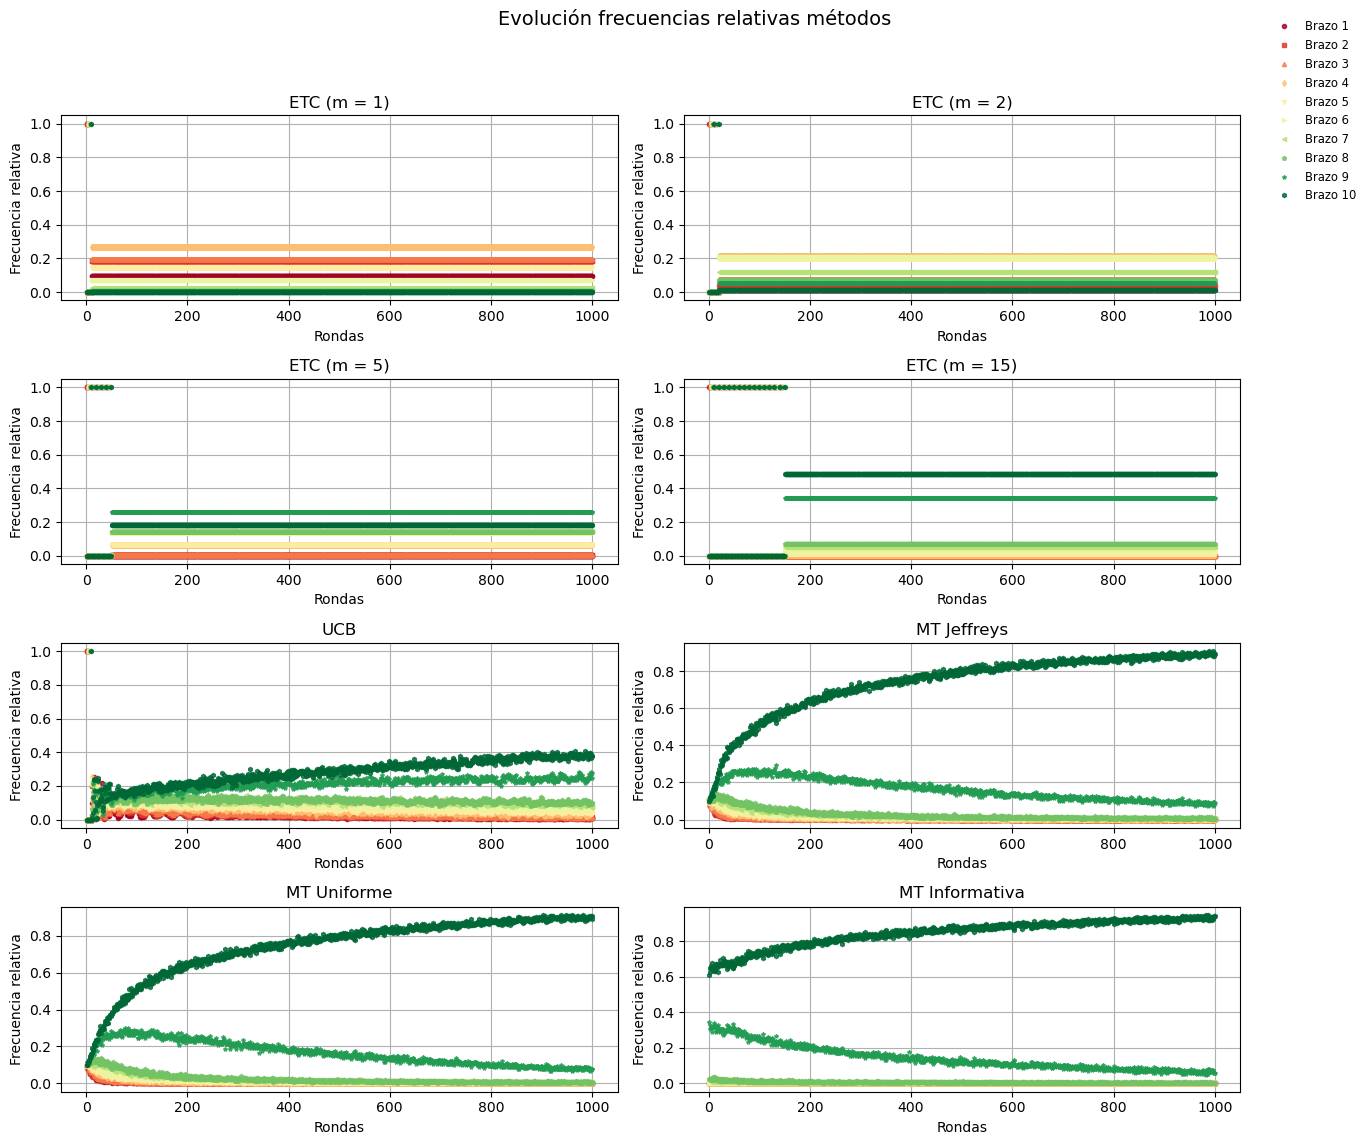

In [ ]:
n = 1000 #horizonte
simula = 1000 #numero de simulaciones
K = 10 #brazos

valoresm = [1,2,5,15]
pseudoregret_ETC_valoresM = [[] for _ in range(len(valoresm))] #acumulador de pseudoregret para 4 valores de m
frecuencias_ETC = np.zeros((len(valoresm),K)) #lista acumuladora de las frecuencias acción 1,2,3,4
acumbrazos_ETC = [np.zeros((n,K)),np.zeros((n,K)),np.zeros((n,K)),np.zeros((n,K))] #acumulador de brazos jugados por rondas para 4 valores de m

pseudoregret_UCB = [] #acumulador de pseudoregret UCB
frecuencias_UCB = np.zeros(K) #frecuencia de cada accion UCB
acumbrazos_UCB = np.zeros((n,K)) #acumulador de brazos jugados por rondas UCB

pseudoregret_NoInfo_Jeffry = [] #acumulador de pseudoregret NoInfo Jeffry
frecuencias_NoInfo_Jeffry = np.zeros(K) #frecuencia de cada accion NoInfo Jeffry
acumbrazos_NoInfo_Jeffry = np.zeros((n,K)) #acumulador de brazos jugados por rondas NoInfo Jeffry

pseudoregret_NoInfo_Uniforme = [] #acumulador de pseudoregret NoInfo Uniforme
frecuencias_NoInfo_Uniforme = np.zeros(K) #frecuencia de cada accion NoInfo Uniforme
acumbrazos_NoInfo_Uniforme = np.zeros((n,K)) #acumulador de brazos jugados por rondas NoInfo Uniforme

pseudoregret_Info = []
frecuencias_Info = np.zeros(K)
acumbrazos_Info = np.zeros((n,K))


#Simulacion ETC
for m in tqdm(valoresm):
    for _ in range(simula):
        bandido = BernoulliBandit([0.1, 0.2, 0.3, 0.5, 0.55, 0.65, 0.7, 0.72, 0.85, 0.9])  # Reset the bandit for each simulation
        brazosjugados = ETCrondas(n, m)
        pseudoregret_ETC_valoresM[valoresm.index(m)].append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_ETC[valoresm.index(m)][k] += bandido.frecuency()[k]
        for t in range(n):
            acumbrazos_ETC[valoresm.index(m)][t][brazosjugados[t]] += 1
#Simulacion UCB
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.1, 0.2, 0.3, 0.5, 0.55, 0.65, 0.7, 0.72, 0.85, 0.9])  # Reset the bandit for each simulation
    brazosjugados = UCBrondas(n,1/(n**2))
    pseudoregret_UCB.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_UCB[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_UCB[t][brazosjugados[t]] += 1
#Simulacion NoInfo Jeffry
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.1, 0.2, 0.3, 0.5, 0.55, 0.65, 0.7, 0.72, 0.85, 0.9])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5],bandido) # beta(0.5,0.5) es la dist a priori para cada brazo
    pseudoregret_NoInfo_Jeffry.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_NoInfo_Jeffry[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_NoInfo_Jeffry[t][brazosjugados[t]] += 1
# Simulacion NoInfo Uniforme
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.1, 0.2, 0.3, 0.5, 0.55, 0.65, 0.7, 0.72, 0.85, 0.9])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la dist a priori para cada brazo
    pseudoregret_NoInfo_Uniforme.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_NoInfo_Uniforme[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_NoInfo_Uniforme[t][brazosjugados[t]] += 1
# Simulacion Info
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.1, 0.2, 0.3, 0.5, 0.55, 0.65, 0.7, 0.72, 0.85, 0.9])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [19,150,19,70,19,40,19,19,19,15,19,12,19,9,19,8,19,4,19,3],bandido) # beta(2.1,1) es la dist a priori para cada brazo
    pseudoregret_Info.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_Info[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_Info[t][brazosjugados[t]] += 1


# GRAFICAS PSEUDOREGRETS
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()
for i, m in enumerate(valoresm):
    axs[i].hist(pseudoregret_ETC_valoresM[i], bins=30, edgecolor='black')
    ValorRegret_ETCrondas = np.mean(pseudoregret_ETC_valoresM[i])
    axs[i].axvline(ValorRegret_ETCrondas, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {ValorRegret_ETCrondas:.2f}")
    axs[i].set_title(f'Histograma método ETC (m = {m})')
    axs[i].set_xlabel('Pseudopérdida')
    axs[i].set_ylabel('Frecuencia absoluta')
    axs[i].legend()


axs[4].hist(pseudoregret_UCB, bins=30, edgecolor='black')
ValorRegret_UCB = np.mean(pseudoregret_UCB)
axs[4].axvline(ValorRegret_UCB, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_UCB:.2f}")
axs[4].set_title("Histograma método UCB")
axs[4].set_xlabel('Pseudopérdida')
axs[4].set_ylabel("Frecuencia absoluta")
axs[4].legend()

axs[5].hist(pseudoregret_NoInfo_Jeffry, bins=30, edgecolor='black')
ValorRegret_NoInfo_Jeffry = np.mean(pseudoregret_NoInfo_Jeffry)
axs[5].axvline(ValorRegret_NoInfo_Jeffry, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_NoInfo_Jeffry:.2f}")
axs[5].set_title("Histograma método MT Jeffreys")
axs[5].set_xlabel('Pseudopérdida')
axs[5].set_ylabel("Frecuencia absoluta")
axs[5].legend()

axs[6].hist(pseudoregret_NoInfo_Uniforme, bins=30, edgecolor='black')
ValorRegret_NoInfo_Uniforme = np.mean(pseudoregret_NoInfo_Uniforme)
axs[6].axvline(ValorRegret_NoInfo_Uniforme, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_NoInfo_Uniforme:.2f}")
axs[6].set_title("Histograma método MT Uniforme")
axs[6].set_xlabel('Pseudopérdida')
axs[6].set_ylabel("Frecuencia absoluta")
axs[6].legend()

axs[7].hist(pseudoregret_Info, bins=30, edgecolor='black')
ValorRegret_Info = np.mean(pseudoregret_Info)
axs[7].axvline(ValorRegret_Info, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_Info:.2f}")
axs[7].set_title("Histograma método MT Informativa")
axs[7].set_xlabel('Pseudopérdida')
axs[7].set_ylabel("Frecuencia absoluta")
axs[7].legend()

plt.suptitle("Histogramas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título principal
plt.show()

#GRAFICAS FRECUENCIAS
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
axs = axs.flatten()
labels = [f"{i+1}" for i in range(K)]

for i, m in enumerate(valoresm):
    # calcula las frecuencias relativas de los 10 brazos para el valor m
    rel_freq = np.array(frecuencias_ETC[i]) / (simula*n)

    # dibuja un bar chart en lugar de un plot lineal
    axs[i].bar(range(K), rel_freq, tick_label=labels, edgecolor='black')
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel("Brazos")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"Frecuencias relativas ETC (m = {m})")
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)

rel_freq_UCB = np.array(frecuencias_UCB) / (simula*n)
axs[4].bar(range(K), rel_freq_UCB,
           tick_label=labels,
           edgecolor='black')
axs[4].set_ylim(0, 1)
axs[4].set_xlabel("Brazos")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("Frecuencias relativas UCB")

rel_freq_noinfo = np.array(frecuencias_NoInfo_Jeffry) / (simula*n)
axs[5].bar(range(K), rel_freq_noinfo,
           tick_label=labels,
           edgecolor='black')
axs[5].set_ylim(0, 1)
axs[5].set_xlabel("Brazos")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("Frecuencias relativas MT Jeffreys")
axs[5].grid(axis='y', linestyle='--', alpha=0.5)

rel_freq_uniforme = np.array(frecuencias_NoInfo_Uniforme) / (simula*n)
axs[6].bar(range(K), rel_freq_uniforme,
           tick_label=labels,
           edgecolor='black')
axs[6].set_ylim(0, 1)
axs[6].set_xlabel("Brazos")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("Frecuencias relativas MT Uniforme")
axs[6].grid(axis='y', linestyle='--', alpha=0.5)

rel_freq_info = np.array(frecuencias_Info) /(simula*n)
axs[7].bar(range(K), rel_freq_info,
           tick_label=labels,
           edgecolor='black')
axs[7].set_ylim(0, 1)
axs[7].set_xlabel("Brazos")
axs[7].set_ylabel("Frecuencia relativa")
axs[7].set_title("Frecuencias relativas MT Informativa")
axs[7].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título principal
plt.show()


#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
cmap = plt.get_cmap('RdYlGn')
colores = [cmap(i) for i in np.linspace(0, 1, 10)]
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()
x = np.arange(1, n+1)  # Rondas

# Paleta y marcadores
cmap = plt.get_cmap('RdYlGn')
colores = [cmap(i) for i in np.linspace(0, 1, 10)]
marcadores = ['o', 's', '^', 'd', 'v', '>', '<', 'p', '*', 'h']

# Para coleccionar un único handle/label por brazo
handles = []
labels  = [f'Brazo {k+1}' for k in range(10)]

# 1) ETC
for i, m in enumerate(valoresm):
    for k in range(10):
        h, = axs[i].plot(
            x, acumbrazos_ETC[i][:, k] / simula,
            marker=marcadores[k],
            linestyle='None',
            markersize=3,
            alpha=0.8,
            color=colores[k]
        )
        # Sólo agregamos el handle de cada brazo la primera vez
        if i == 0:
            handles.append(h)

    axs[i].set_xlabel("Rondas")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"ETC (m = {m})")
    axs[i].grid(True)
    # NO axs[i].legend()

# 2) UCB
for k in range(10):
    h, = axs[4].plot(
        x, acumbrazos_UCB[:, k] / simula,
        marker=marcadores[k],
        linestyle='None',
        markersize=3,
        alpha=0.8,
        color=colores[k]
    )
# NO axs[4].legend()
axs[4].set_xlabel("Rondas")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("UCB")
axs[4].grid(True)

# 3) MT Jeffreys
for k in range(10):
    axs[5].plot(
        x, acumbrazos_NoInfo_Jeffry[:, k] / simula,
        marker=marcadores[k], linestyle='None',
        markersize=3, alpha=0.8, color=colores[k]
    )
axs[5].set_xlabel("Rondas")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("MT Jeffreys")
axs[5].grid(True)

# 4) MT Uniforme
for k in range(10):
    axs[6].plot(
        x, acumbrazos_NoInfo_Uniforme[:, k] / simula,
        marker=marcadores[k], linestyle='None',
        markersize=3, alpha=0.8, color=colores[k]
    )
axs[6].set_xlabel("Rondas")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("MT Uniforme")
axs[6].grid(True)

# 5) MT Informativa
for k in range(10):
    axs[7].plot(
        x, acumbrazos_Info[:, k] / simula,
        marker=marcadores[k], linestyle='None',
        markersize=3, alpha=0.8, color=colores[k]
    )
axs[7].set_xlabel("Rondas")
axs[7].set_ylabel("Frecuencia relativa")
axs[7].set_title("MT Informativa")
axs[7].grid(True)

# Suyptitle y ajuste de layout
plt.suptitle("Evolución frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])  # Deja espacio a la derecha

# Leyenda global en esquina superior derecha
fig.legend(handles, labels,
           loc='upper right',
           bbox_to_anchor=(0.98, 0.98),
           fontsize='small',
           ncol=1,
           frameon=False)

plt.show()



CONCLUSIONES A DESTACAR

* En el metodo ETC se obtiene que para m = 1 o m = 2 el brazo optimo se juega muy poco debido a que  en caso de empate, se selecciona de izquierda a derecha el brazo a jugar y como el óptimo es el ultimo tan solo se selecciona si el obtimo obtuvo 1 de recompensa y el resto 0 

* Mejores resultados el bayesiano info, pero parte con ventaja entonces es algo que podriamos no tener en un caso practico. Luego lo mas prometedores son los jeffreys y uniforme, cuyo comportamiento es similar, aunque cabe destacar que el tiempo de computo de ambos metodos es superior al doble del resto de metodos frecuentistas

### 4 brazos

FALTA

* Aumentar el K=10 para representar mas brazos (reoresentar el diagrama circular como un histograma)

100%|██████████| 10/10 [00:00<00:00, 210.39it/s]


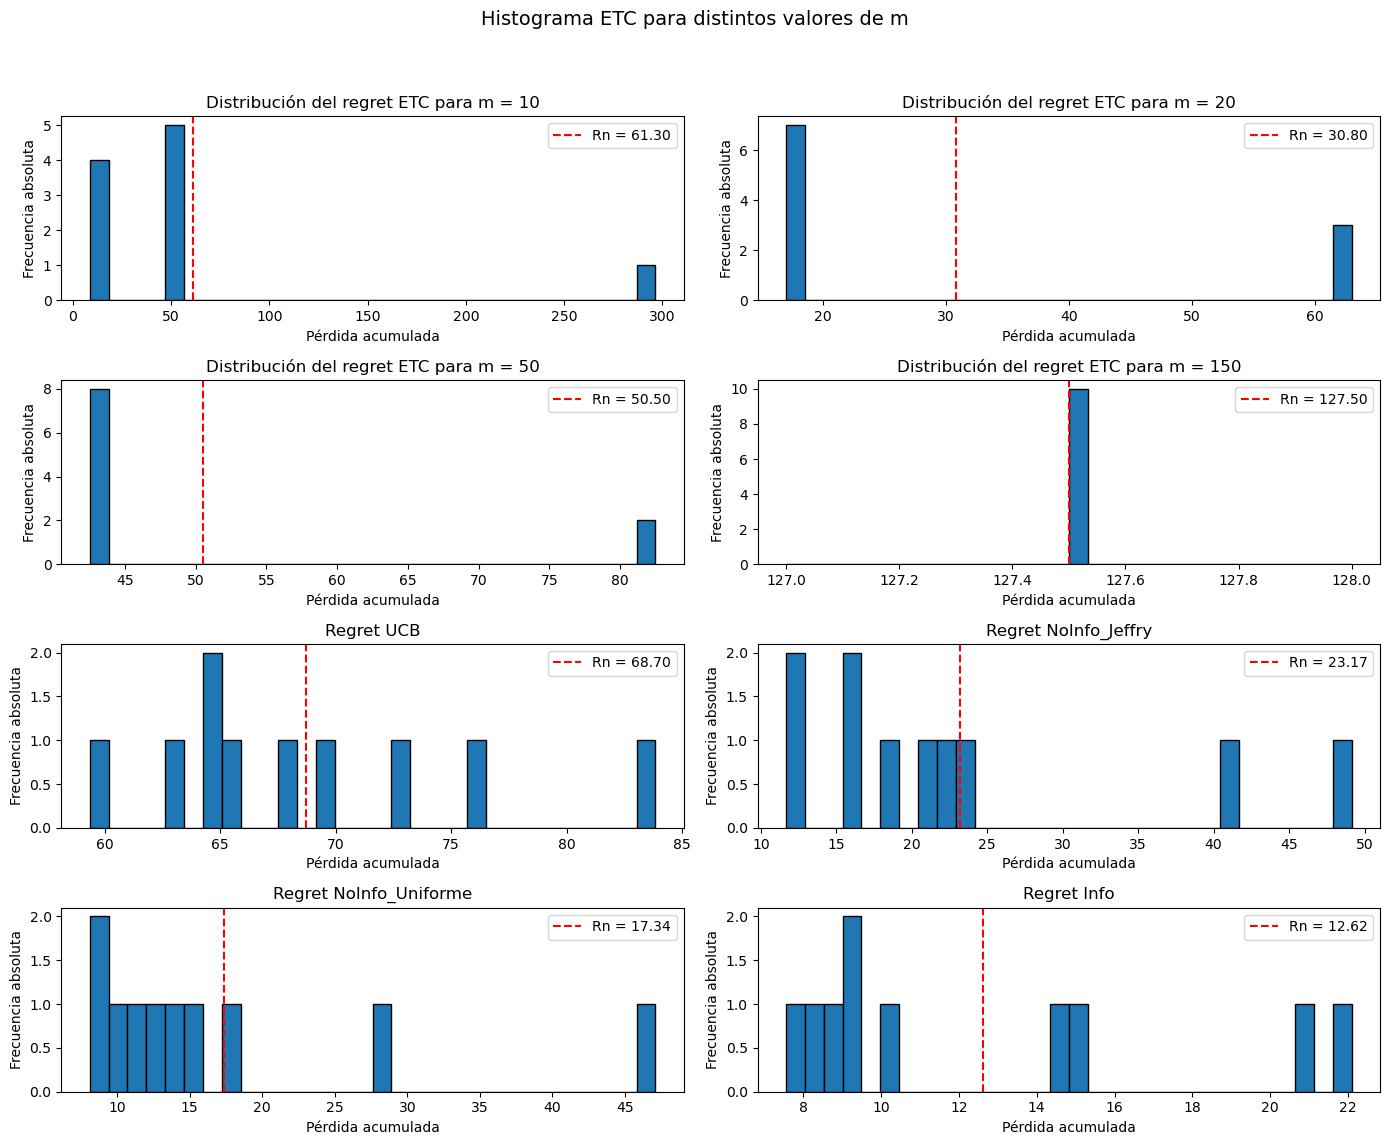

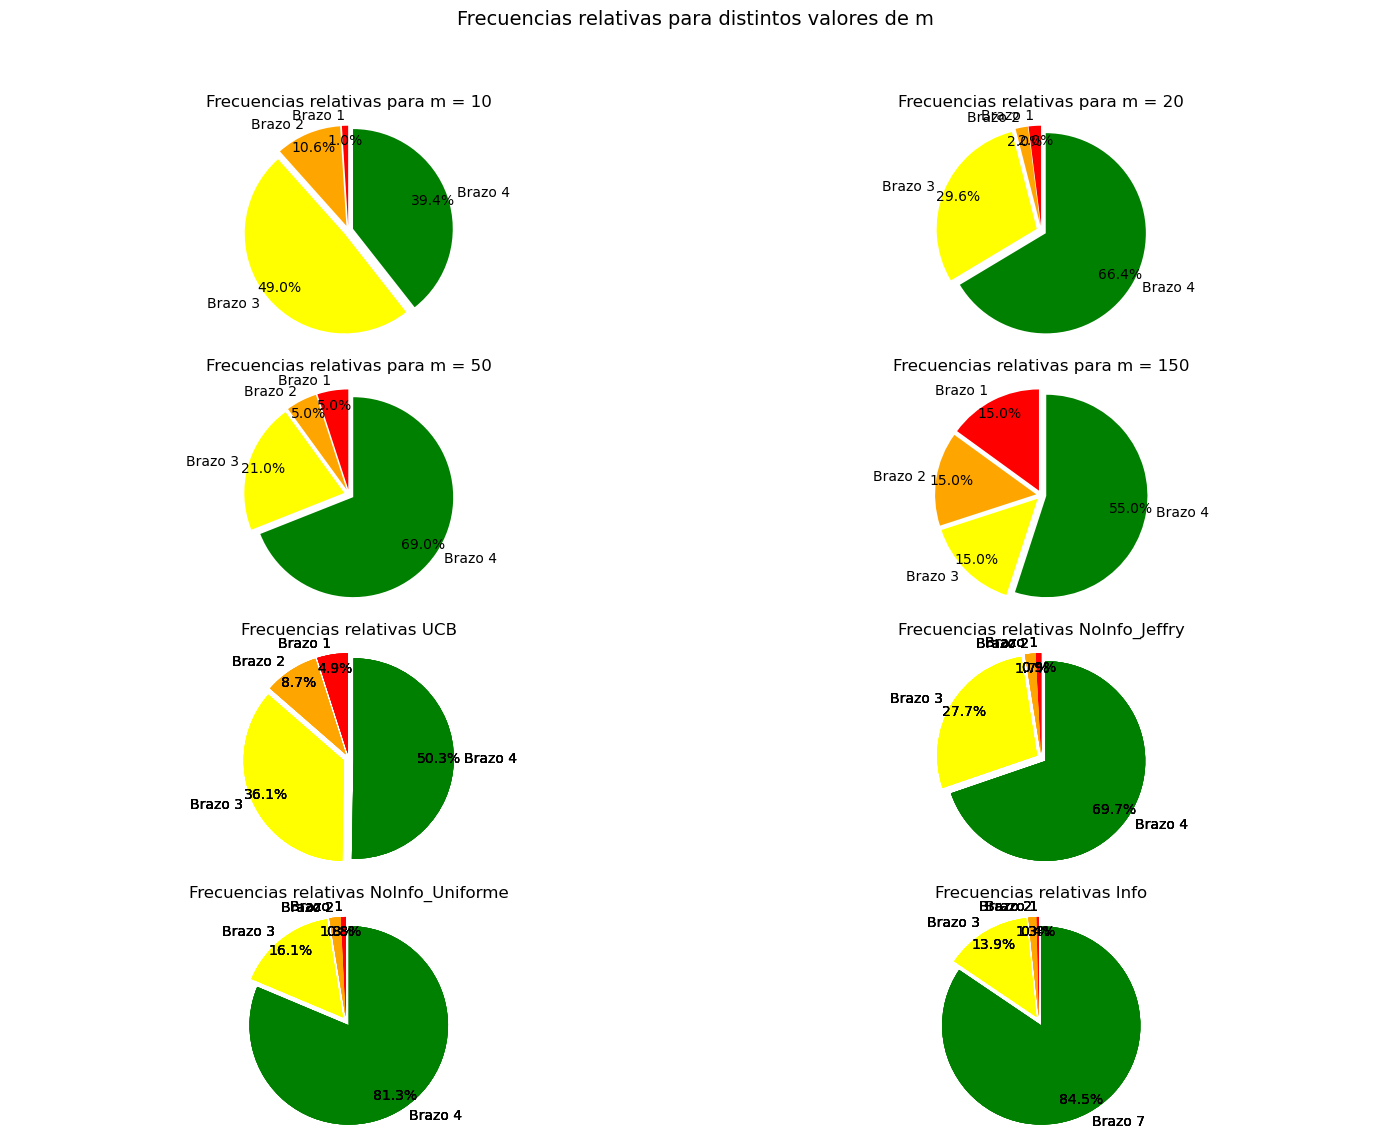

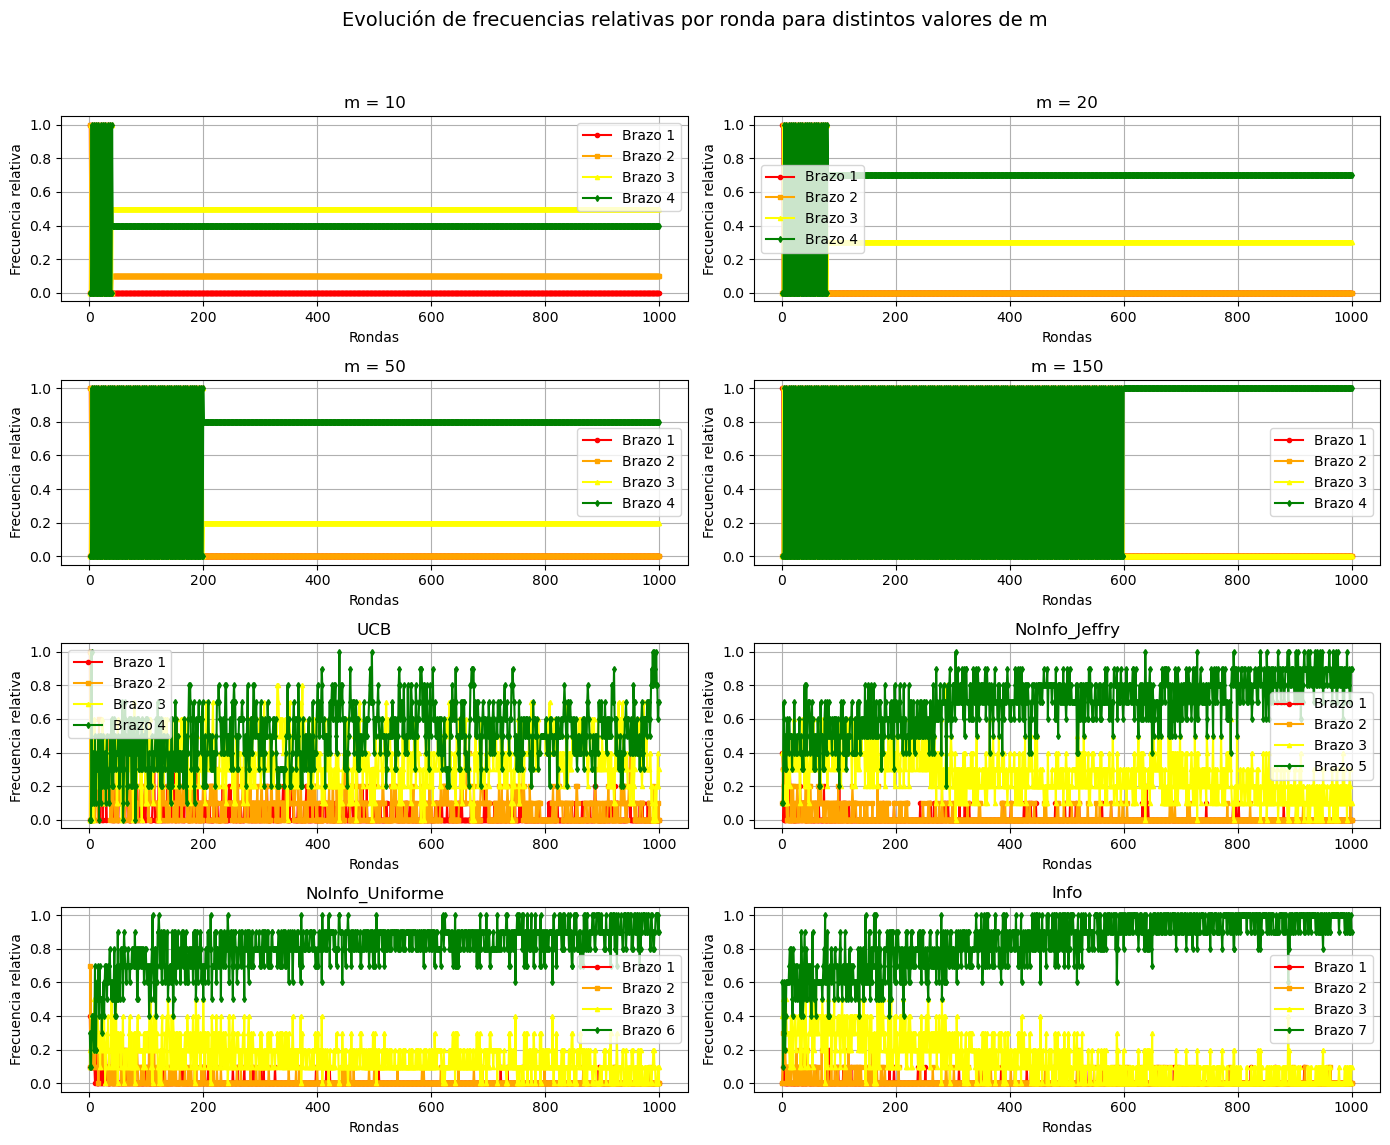

In [44]:
n = 1000 #horizonte
simula = 10 #numero de simulaciones
K = 4 #brazos

valoresm = [10,20,50,150]
pseudoregret_ETC_valoresM = [[],[],[],[]] #acumulador de pseudoregret para 4 valores de m
frecuencias_ETC = np.zeros((len(valoresm),K)) #lista acumuladora de las frecuencias acción 1,2,3,4
acumbrazos_ETC = [np.zeros((n,K)),np.zeros((n,K)),np.zeros((n,K)),np.zeros((n,K))] #acumulador de brazos jugados por rondas para 4 valores de m

pseudoregret_UCB = [] #acumulador de pseudoregret UCB
frecuencias_UCB = np.zeros(K) #frecuencia de cada accion UCB
acumbrazos_UCB = np.zeros((n,K)) #acumulador de brazos jugados por rondas UCB

pseudoregret_NoInfo_Jeffry = [] #acumulador de pseudoregret NoInfo Jeffry
frecuencias_NoInfo_Jeffry = np.zeros(K) #frecuencia de cada accion NoInfo Jeffry
acumbrazos_NoInfo_Jeffry = np.zeros((n,K)) #acumulador de brazos jugados por rondas NoInfo Jeffry

pseudoregret_NoInfo_Uniforme = [] #acumulador de pseudoregret NoInfo Uniforme
frecuencias_NoInfo_Uniforme = np.zeros(K) #frecuencia de cada accion NoInfo Uniforme
acumbrazos_NoInfo_Uniforme = np.zeros((n,K)) #acumulador de brazos jugados por rondas NoInfo Uniforme

pseudoregret_Info = []
frecuencias_Info = np.zeros(K)
acumbrazos_Info = np.zeros((n,K))


#Simulacion ETC
for m in tqdm(valoresm):
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
        brazosjugados = ETCrondas(n, m)
        pseudoregret_ETC_valoresM[valoresm.index(m)].append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_ETC[valoresm.index(m)][k] += bandido.frecuency()[k]
        for t in range(n):
            acumbrazos_ETC[valoresm.index(m)][t][brazosjugados[t]] += 1
#Simulacion UCB
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
    brazosjugados = UCBrondas(n,1/(n**2))
    pseudoregret_UCB.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_UCB[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_UCB[t][brazosjugados[t]] += 1
#Simulacion NoInfo Jeffry
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5],bandido) # beta(0.5,0.5) es la dist a priori para cada brazo
    pseudoregret_NoInfo_Jeffry.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_NoInfo_Jeffry[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_NoInfo_Jeffry[t][brazosjugados[t]] += 1
# Simulacion NoInfo Uniforme
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la dist a priori para cada brazo
    pseudoregret_NoInfo_Uniforme.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_NoInfo_Uniforme[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_NoInfo_Uniforme[t][brazosjugados[t]] += 1
# Simulacion Info
for _ in tqdm(range(simula)):
    bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [2,5,3,4,5,3,6,3],bandido) # beta(2.1,1) es la dist a priori para cada brazo
    pseudoregret_Info.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_Info[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_Info[t][brazosjugados[t]] += 1


# GRAFICAS PSEUDOREGRETS
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()
for i, m in enumerate(valoresm):
    axs[i].hist(pseudoregret_ETC_valoresM[i], bins=30, edgecolor='black')
    ValorRegret_ETCrondas = np.mean(pseudoregret_ETC_valoresM[i])
    axs[i].axvline(ValorRegret_ETCrondas, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {ValorRegret_ETCrondas:.2f}")
    axs[i].set_title(f'Distribución del regret ETC para m = {m}')
    axs[i].set_xlabel('Pérdida acumulada')
    axs[i].set_ylabel('Frecuencia absoluta')
    axs[i].legend()


axs[4].hist(pseudoregret_UCB, bins=30, edgecolor='black')
ValorRegret_UCB = np.mean(pseudoregret_UCB)
axs[4].axvline(ValorRegret_UCB, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_UCB:.2f}")
axs[4].set_title("Regret UCB")
axs[4].set_xlabel("Pérdida acumulada")
axs[4].set_ylabel("Frecuencia absoluta")
axs[4].legend()

axs[5].hist(pseudoregret_NoInfo_Jeffry, bins=30, edgecolor='black')
ValorRegret_NoInfo_Jeffry = np.mean(pseudoregret_NoInfo_Jeffry)
axs[5].axvline(ValorRegret_NoInfo_Jeffry, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_NoInfo_Jeffry:.2f}")
axs[5].set_title("Regret NoInfo_Jeffry")
axs[5].set_xlabel("Pérdida acumulada")
axs[5].set_ylabel("Frecuencia absoluta")
axs[5].legend()

axs[6].hist(pseudoregret_NoInfo_Uniforme, bins=30, edgecolor='black')
ValorRegret_NoInfo_Uniforme = np.mean(pseudoregret_NoInfo_Uniforme)
axs[6].axvline(ValorRegret_NoInfo_Uniforme, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_NoInfo_Uniforme:.2f}")
axs[6].set_title("Regret NoInfo_Uniforme")
axs[6].set_xlabel("Pérdida acumulada")
axs[6].set_ylabel("Frecuencia absoluta")
axs[6].legend()

axs[7].hist(pseudoregret_Info, bins=30, edgecolor='black')
ValorRegret_Info = np.mean(pseudoregret_Info)
axs[7].axvline(ValorRegret_Info, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_Info:.2f}")
axs[7].set_title("Regret Info")
axs[7].set_xlabel("Pérdida acumulada")
axs[7].set_ylabel("Frecuencia absoluta")
axs[7].legend()

plt.suptitle("Histograma ETC para distintos valores de m", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título principal
plt.show()

#GRAFICAS FRECUENCIAS
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()
for i, m in enumerate(valoresm):
    axs[i].pie(frecuencias_ETC[i] / simula, labels=["Brazo 1", "Brazo 2", "Brazo 3", "Brazo 4"],
               colors=['red', 'orange', 'yellow', 'green'],
           autopct='%1.1f%%', startangle=90,
           pctdistance=0.85,  # más lejos del centro
           labeldistance=1.1,
           explode=[0.05] * K) # más lejos del centro también
    axs[i].axis('equal')
    axs[i].set_title(f"Frecuencias relativas para m = {m}")

for k in range(K):
    axs[4].pie(frecuencias_UCB / simula, labels=["Brazo 1", "Brazo 2", "Brazo 3", "Brazo 4"],
                colors=['red', 'orange', 'yellow', 'green'],
            autopct='%1.1f%%', startangle=90,
            pctdistance=0.85,  # más lejos del centro
            labeldistance=1.1,
            explode=[0.05] * K) # más lejos del centro también
    axs[4].axis('equal')
    axs[4].set_title(f"Frecuencias relativas UCB")

for k in range(K):
    axs[5].pie(frecuencias_NoInfo_Jeffry / simula, labels=["Brazo 1", "Brazo 2", "Brazo 3", "Brazo 4"],
                colors=['red', 'orange', 'yellow', 'green'],
            autopct='%1.1f%%', startangle=90,
            pctdistance=0.85,  # más lejos del centro
            labeldistance=1.1,
            explode=[0.05] * K) # más lejos del centro también
    axs[5].axis('equal')
    axs[5].set_title(f"Frecuencias relativas NoInfo_Jeffry")

for k in range(K):
    axs[6].pie(frecuencias_NoInfo_Uniforme / simula, labels=["Brazo 1", "Brazo 2", "Brazo 3", "Brazo 4"],
                colors=['red', 'orange', 'yellow', 'green'],
            autopct='%1.1f%%', startangle=90,
            pctdistance=0.85,  # más lejos del centro
            labeldistance=1.1,
            explode=[0.05] * K) # más lejos del centro también
    axs[6].axis('equal')
    axs[6].set_title(f"Frecuencias relativas NoInfo_Uniforme")

for k in range(K):
    axs[7].pie(frecuencias_Info / simula, labels=["Brazo 1", "Brazo 2", "Brazo 3", "Brazo 7"],
                colors=['red', 'orange', 'yellow', 'green'],
            autopct='%1.1f%%', startangle=90,
            pctdistance=0.85,  # más lejos del centro
            labeldistance=1.1,
            explode=[0.05] * K) # más lejos del centro también
    axs[7].axis('equal')
    axs[7].set_title(f"Frecuencias relativas Info")

plt.suptitle("Frecuencias relativas para distintos valores de m", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título principal
plt.show()

#GRAFICAS FRECUENCIAS BRAZOS por RONDAS
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()
x = np.arange(1, n+1)  # Rondas

for i, m in enumerate(valoresm):
    # Calculamos frecuencias relativas para cada brazo
    brazo1 = acumbrazos_ETC[i][:,0] / simula
    brazo2 = acumbrazos_ETC[i][:,1] / simula
    brazo3 = acumbrazos_ETC[i][:,2] / simula
    brazo4 = acumbrazos_ETC[i][:,3] / simula

    axs[i].plot(x, brazo1, 'o-', label='Brazo 1', color='red', markersize=3)
    axs[i].plot(x, brazo2, 's-', label='Brazo 2', color='orange', markersize=3)
    axs[i].plot(x, brazo3, '^-', label='Brazo 3', color='yellow', markersize=3)
    axs[i].plot(x, brazo4, 'd-', label='Brazo 4', color='green', markersize=3)

    axs[i].set_xlabel("Rondas")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"m = {m}")
    axs[i].grid(True)
    axs[i].legend()

axs[4].plot(x, acumbrazos_UCB[:,0] / simula, 'o-', label='Brazo 1', color='red', markersize=3)
axs[4].plot(x, acumbrazos_UCB[:,1] / simula, 's-', label='Brazo 2', color='orange', markersize=3)
axs[4].plot(x, acumbrazos_UCB[:,2] / simula, '^-', label='Brazo 3', color='yellow', markersize=3)
axs[4].plot(x, acumbrazos_UCB[:,3] / simula, 'd-', label='Brazo 4', color='green', markersize=3)
axs[4].set_xlabel("Rondas")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("UCB")
axs[4].grid(True)
axs[4].legend()

axs[5].plot(x, acumbrazos_NoInfo_Jeffry[:,0] / simula, 'o-', label='Brazo 1', color='red', markersize=3)
axs[5].plot(x, acumbrazos_NoInfo_Jeffry[:,1] / simula, 's-', label='Brazo 2', color='orange', markersize=3)
axs[5].plot(x, acumbrazos_NoInfo_Jeffry[:,2] / simula, '^-', label='Brazo 3', color='yellow', markersize=3)
axs[5].plot(x, acumbrazos_NoInfo_Jeffry[:,3] / simula, 'd-', label='Brazo 5', color='green', markersize=3)
axs[5].set_xlabel("Rondas")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("NoInfo_Jeffry")
axs[5].grid(True)
axs[5].legend()

axs[6].plot(x, acumbrazos_NoInfo_Uniforme[:,0] / simula, 'o-', label='Brazo 1', color='red', markersize=3)
axs[6].plot(x, acumbrazos_NoInfo_Uniforme[:,1] / simula, 's-', label='Brazo 2', color='orange', markersize=3)
axs[6].plot(x, acumbrazos_NoInfo_Uniforme[:,2] / simula, '^-', label='Brazo 3', color='yellow', markersize=3)
axs[6].plot(x, acumbrazos_NoInfo_Uniforme[:,3] / simula, 'd-', label='Brazo 6', color='green', markersize=3)
axs[6].set_xlabel("Rondas")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("NoInfo_Uniforme")
axs[6].grid(True)
axs[6].legend()

axs[7].plot(x, acumbrazos_Info[:,0] / simula, 'o-', label='Brazo 1', color='red', markersize=3)
axs[7].plot(x, acumbrazos_Info[:,1] / simula, 's-', label='Brazo 2', color='orange', markersize=3)
axs[7].plot(x, acumbrazos_Info[:,2] / simula, '^-', label='Brazo 3', color='yellow', markersize=3)
axs[7].plot(x, acumbrazos_Info[:,3] / simula, 'd-', label='Brazo 7', color='green', markersize=3)
axs[7].set_xlabel("Rondas")
axs[7].set_ylabel("Frecuencia relativa")
axs[7].set_title("Info")
axs[7].grid(True)
axs[7].legend()

plt.suptitle("Evolución de frecuencias relativas por ronda para distintos valores de m", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título principal
plt.show()



CONCLUSIONES A DESTACAR

* Destacar que aunque el m=50 tenga el mayor % de elegir el brazo optimo, no es el que tiene menor perdida acumulada, debido a la exporacion estamos tambien seleccionando muchas mas veces el brazo peor. Por eso el m=20 aunque tenga menor % de elegir el brazo optimo resulta mejor en tema de perdidas acumuladas.

* En las fases de exploracion, como el ultimo brazo en representarse es el verde se observa un rectangulo verde, se trata de una superposion de las iteraciones entre 0 y 1 debido a la exploracion de cada brazo

### Variacion de n

* No representar la frecuencia de eleccion de brazos. Representar perdida acumulada / n. (hacerlo directamente en una grafica plot(rangen, perdida/n))

* Nuestro n es mas reducido, entonces los valoresm son proporcionales al minimo n (Ej: 10/1000 = m_min/100 => m_min = 1)

FALTA HACER
* Implementar ETC con m=0 para comporbar como deberia ser la grafica aleatoria. Parece raro que m=1 el brazo optimo sea el que menos veces se haya jugado

* Implementar perdida acumulada/n

100%|██████████| 200/200 [02:56<00:00,  1.13it/s]


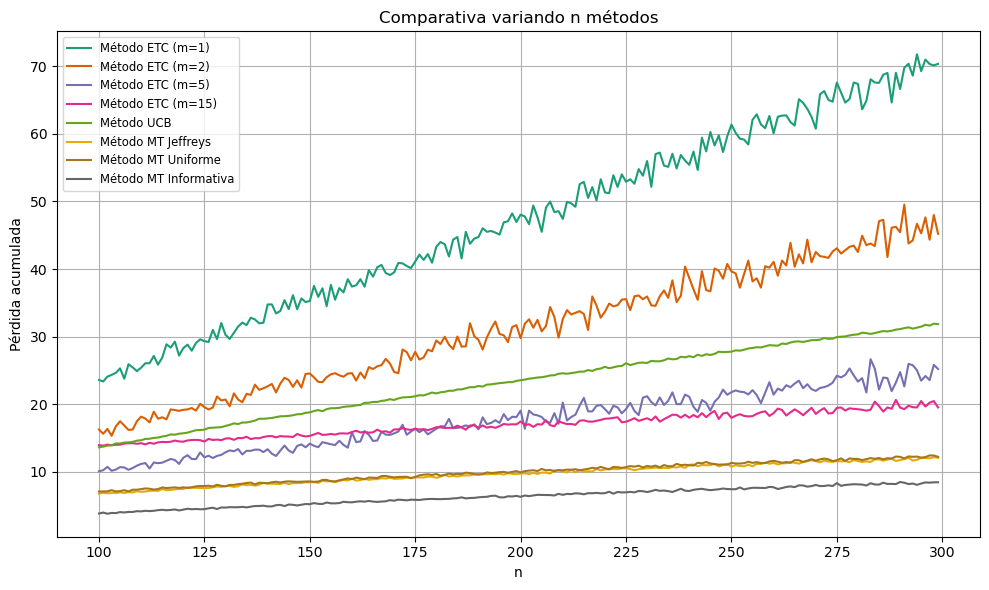

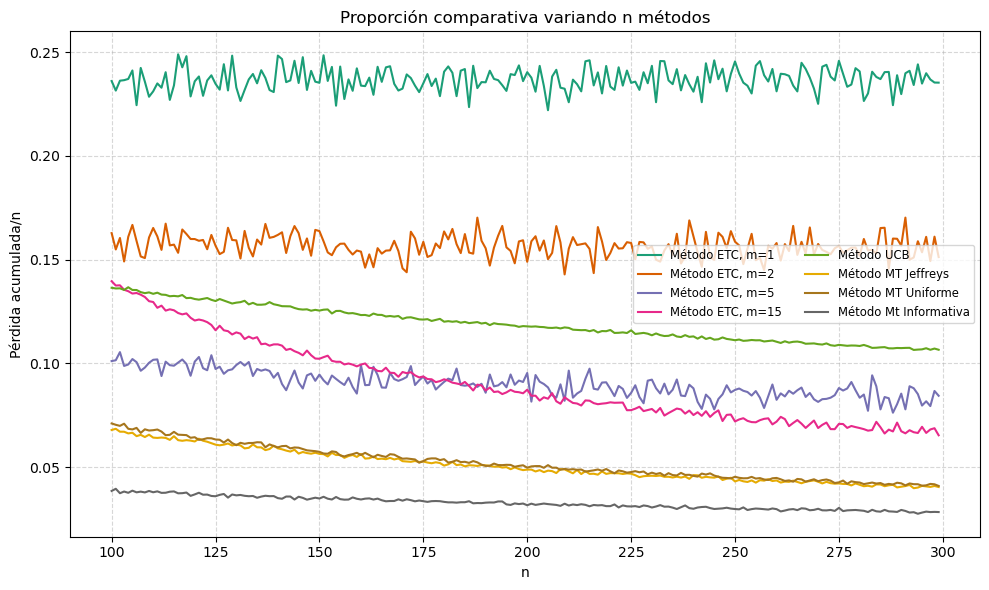

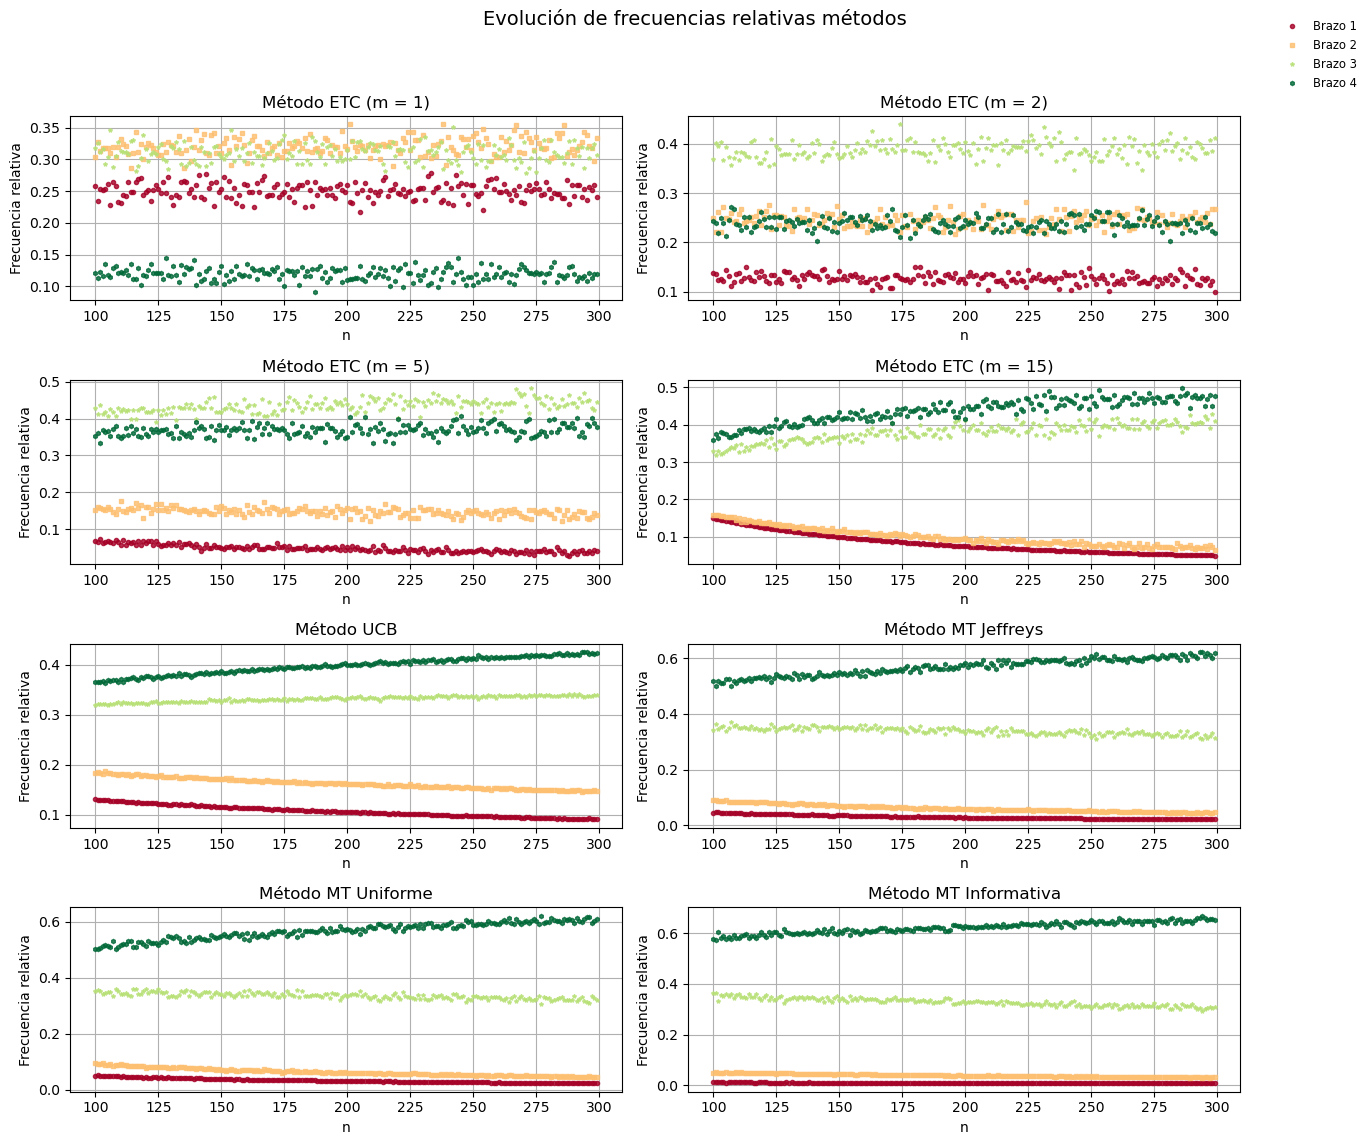

In [45]:
nvalores = range(100,300) #horizonte
simula = 1000 #numero de simulaciones
K = 4 #brazos

valoresm = [1,2,5,15]
regret_ETC_valoresM = [[] for _ in range(len(valoresm))] #acumulador de regret para 4 valores de m
frecuenciasParaCadaN_ETC = [[[] for _ in range(K)] for _ in range(len(valoresm))]

regret_UCB = [] #acumulador de pseudoregret UCB
frecuenciasParaCadaN_UCB = [[] for _ in range(K)] #frecuencia de cada accion UCB

regret_NoInfo_Jeffry = [] #acumulador de pseudoregret NoInfo Jeffry
frecuenciasParaCadaN_NoInfo_Jeffry = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Jeffry

regret_NoInfo_Uniforme = [] #acumulador de pseudoregret NoInfo Uniforme
frecuenciasParaCadaN_NoInfo_Uniforme = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Uniforme

regret_Info = []
frecuenciasParaCadaN_Info = [[] for _ in range(K)]


#Simulacion ETC
for n in tqdm(nvalores):
    pseudoregret_ETC_valoresM  = [[] for _ in range(len(valoresm))] # Reset accumulators for each n
    for m in valoresm:
        frecuencias_ETC = [[] for _ in range(K)] # Frecuencias de cada brazo para cada valor de K
        for _ in range(simula):
            bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
            brazosjugados = ETCrondas(n, m)
            pseudoregret_ETC_valoresM[valoresm.index(m)].append(bandido.pseudoregret())
            for k in range(K):
                frecuencias_ETC[k].append(bandido.frecuency()[k])
        [frecuenciasParaCadaN_ETC[valoresm.index(m)][i].append(np.mean(frecuencias_ETC[i])/n) for i in range(K)]
    [regret_ETC_valoresM[i].append(np.mean(pseudoregret_ETC_valoresM[i])) for i in range(len(valoresm))]
#Simulacion UCB
for n in tqdm(nvalores):
    pseudoregret_UCB = []  # Reset accumulators for each n
    frecuencias_UCB = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
        brazosjugados = UCBrondas(n,1/(n**2))
        pseudoregret_UCB.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_UCB[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_UCB[i].append(np.mean(frecuencias_UCB[i])/n) for i in range(K)]
    regret_UCB.append(np.mean(pseudoregret_UCB))
#Simulacion NoInfo Jeffry
for n in tqdm(nvalores):
    pseudoregret_NoInfo_Jeffry = []  # Reset accumulators for each n
    frecuencias_NoInfo_Jeffry = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
        brazosjugados = BayesBernoulli(n, [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5],bandido) # beta(0.5,0.5) es la dist a priori para cada brazo
        pseudoregret_NoInfo_Jeffry.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Jeffry[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_NoInfo_Jeffry[i].append(np.mean(frecuencias_NoInfo_Jeffry[i])/n) for i in range(K)]
    regret_NoInfo_Jeffry.append(np.mean(pseudoregret_NoInfo_Jeffry))
# Simulacion NoInfo Uniforme
for n in tqdm(nvalores):
    pseudoregret_NoInfo_Uniforme = []  # Reset accumulators for each n
    frecuencias_NoInfo_Uniforme = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])  # Reset the bandit for each simulation
        brazosjugados = BayesBernoulli(n, [1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la dist a priori para cada brazo
        pseudoregret_NoInfo_Uniforme.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Uniforme[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_NoInfo_Uniforme[i].append(np.mean(frecuencias_NoInfo_Uniforme[i])/n) for i in range(K)]
    regret_NoInfo_Uniforme.append(np.mean(pseudoregret_NoInfo_Uniforme))
# Simulacion Info
for n in tqdm(nvalores):
    pseudoregret_Info = []  # Reset accumulators for each n
    frecuencias_Info = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.2, 0.4, 0.65, 0.7])
        brazosjugados = BayesBernoulli(n, [2,5,3,4,5,3,6,3],bandido) # beta(2.1,1) es la dist a priori para cada brazo
        pseudoregret_Info.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_Info[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_Info[i].append(np.mean(frecuencias_Info[i])/n) for i in range(K)]
    regret_Info.append(np.mean(pseudoregret_Info))




# GRAFICAS EVOLCUION PERDIDA ACUMULADA
plt.figure(figsize=(10,6))
etiquetas = [
    *[f'Método ETC (m={m})' for m in valoresm],
    'Método UCB',
    'Método MT Jeffreys',
    'Método MT Uniforme',
    'Método MT Informativa'
]
series = regret_ETC_valoresM + [regret_UCB, regret_NoInfo_Jeffry, regret_NoInfo_Uniforme, regret_Info]
colores = ['#1b9e77','#d95f02','#7570b3','#e7298a',
 '#66a61e','#e6ab02','#a6761d','#666666']

for color, label, y in zip(colores, etiquetas, series):
    plt.plot(nvalores, y, label=label, color=color, linewidth=1.5)

plt.xlabel('n')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando n métodos')
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

# GRAFICAS EVOLCUION PERDIDA ACUMULADA ENTRE N
n_array = np.array(list(nvalores))  # Convertimos el range en array
paleta = colores

series = (
    [np.array(regret_ETC_valoresM[i]) / n_array for i in range(len(valoresm))] +
    [np.array(regret_UCB)       / n_array,
     np.array(regret_NoInfo_Jeffry)   / n_array,
     np.array(regret_NoInfo_Uniforme) / n_array,
     np.array(regret_Info)      / n_array]
)

# Etiquetas correspondientes
labels = (
    [f'Método ETC, m={m}' for m in valoresm] +
    ['Método UCB',
     'Método MT Jeffreys',
     'Método MT Uniforme',
     'Método Mt Informativa']
)

plt.figure(figsize=(10,6))
for color, y, label in zip(paleta, series, labels):
    plt.plot(n_array, y,
             color=color,
             linewidth=1.5,
             label=label)

plt.xlabel('n')
plt.ylabel('Pérdida acumulada/n')
plt.title('Proporción comparativa variando n métodos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

#GRAFICAS FRECUENCIAS BRAZOS por RONDAS
# Parámetros
n_array = np.array(list(nvalores))
valoresm = valoresm  # tu lista de m
sim = simula         # tu variable de simulaciones

# Paleta para 4 brazos evitando rojo, amarillo y verde
cmap = plt.get_cmap('RdYlGn')
colors_4 = [cmap(i) for i in np.linspace(0, 1, 4)]
markers_4 = ['o', 's','*', 'h']
labels_4 = [f'Brazo {k+1}' for k in range(4)]

fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()

# Recolectar handles para la leyenda global
handles = []

# 1) ETC
for i, m in enumerate(valoresm):
    for k in range(4):
        h, = axs[i].plot(
            n_array,
            frecuenciasParaCadaN_ETC[i][k],
            marker=markers_4[k],
            linestyle='None',
            markersize=3,
            linewidth=1,
            alpha=0.8,
            color=colors_4[k]
        )
        # Guardar un handle de cada brazo solo la primera vez
        if i == 0:
            handles.append(h)
    axs[i].set_xlabel("n")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"Método ETC (m = {m})")
    axs[i].grid(True)
    # No axs[i].legend()

# 2) UCB
for k in range(4):
    h, = axs[4].plot(
        n_array,
        frecuenciasParaCadaN_UCB[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[4].set_xlabel("n")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("Método UCB")
axs[4].grid(True)

# 3) MT Jeffreys
for k in range(4):
    axs[5].plot(
        n_array,
        frecuenciasParaCadaN_NoInfo_Jeffry[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[5].set_xlabel("n")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("Método MT Jeffreys")
axs[5].grid(True)

# 4) MT Uniforme
for k in range(4):
    axs[6].plot(
        n_array,
        frecuenciasParaCadaN_NoInfo_Uniforme[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[6].set_xlabel("n")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("Método MT Uniforme")
axs[6].grid(True)

# 5) MT Informativa
for k in range(4):
    axs[7].plot(
        n_array,
        frecuenciasParaCadaN_Info[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[7].set_xlabel("n")
axs[7].set_ylabel("Frecuencia relativa")
axs[7].set_title("Método MT Informativa")
axs[7].grid(True)

# Ajustes generales
plt.suptitle("Evolución de frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])   # reservar espacio a la derecha

# Leyenda global en esquina superior derecha
fig.legend(handles, labels_4,
           loc='upper right',
           bbox_to_anchor=(0.98, 0.98),
           fontsize='small',
           ncol=1,
           frameon=False)

plt.show()


CONCLUSIONES A RESALTAR

* En los metodos ETC m=1/2 no se aprecia un descenso de porporcion, por lo que el metodo no está mejorando (eleccion mas aleatoria) en cambio para valores de m mas altos si que se aprecia un comportamiento de aprendizaje. 

* Los metodos ETC aunque aumente n siguen explorando el mismo numero de ronda, pero la explotacion si que varia. Por lo que aquellos valores m que haga que el metodo obtenga mejor informacion sobre las medias hace que luego en la explotacion juegue mas veces brazos mejores

* Para Bayesianos aunque si haya mejoria, es a menor escala al tener ya un rendimiento muy bueno

* Explicar que para bayesianos se distingue mas el brazo optimo del resto, decreciendo la frecuencia del segundo mejor brazo al igual que el resto aunque a menor ritmo por presentar ya una frecuencia bastante reducida. En cambio para los frecuentistas aumentan la frecuencia de los dos mejores brazos a coste de disminuir la de los dos peores.

### Variacion $\Delta$

* Los brazos son $\mu_4 = 0.9,\mu_3 = 0.9-\Delta,\mu_2 = 0.9-2\Delta,\mu_1 = 0.9-3\Delta$ por eso tomamos $\Delta \in [0,0.3]$ cuando $\mu_4=0$ no podemos seguir

In [17]:
n = 1000 #horizonte
simula = 100 #numero de simulaciones
K = 4 #brazos
Dvalores = np.linspace(0,0.3,100)

valoresm = [1,2,5,15]
regret_ETC_valoresM = [[] for _ in range(len(valoresm))] #acumulador de regret para 4 valores de m
frecuenciasParaCadaDelta_ETC = [[[] for _ in range(K)] for _ in range(len(valoresm))]

regret_UCB = [] #acumulador de pseudoregret UCB
frecuenciasParaCadaDelta_UCB = [[] for _ in range(K)] #frecuencia de cada accion UCB

regret_NoInfo_Jeffry = [] #acumulador de pseudoregret NoInfo Jeffry
frecuenciasParaCadaDelta_NoInfo_Jeffry = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Jeffry

regret_NoInfo_Uniforme = [] #acumulador de pseudoregret NoInfo Uniforme
frecuenciasParaCadaDelta_NoInfo_Uniforme = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Uniforme

regret_Info = []
frecuenciasParaCadaDelta_Info = [[] for _ in range(K)]


#Simulacion ETC
for Delta in tqdm(Dvalores):
    pseudoregret_ETC_valoresM  = [[] for _ in range(len(valoresm))] # Reset accumulators for each n
    for m in valoresm:
        frecuencias_ETC = [[] for _ in range(K)] # Frecuencias de cada brazo para cada valor de K
        for _ in range(simula):
            bandido = BernoulliBandit([0.9-3*Delta, 0.9-2*Delta, 0.9-Delta, 0.9])  # Reset the bandit for each simulation
            brazosjugados = ETCrondas(n, m)
            pseudoregret_ETC_valoresM[valoresm.index(m)].append(bandido.pseudoregret())
            for k in range(K):
                frecuencias_ETC[k].append(bandido.frecuency()[k])
        [frecuenciasParaCadaDelta_ETC[valoresm.index(m)][i].append(np.mean(frecuencias_ETC[i])/n) for i in range(K)]
    [regret_ETC_valoresM[i].append(np.mean(pseudoregret_ETC_valoresM[i])) for i in range(len(valoresm))]
#Simulacion UCB
for Delta in tqdm(Dvalores):
    pseudoregret_UCB = []  # Reset accumulators for each n
    frecuencias_UCB = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.9-3*Delta, 0.9-2*Delta, 0.9-Delta, 0.9])  # Reset the bandit for each simulation
        brazosjugados = UCBrondas(n,1/(n**2))
        pseudoregret_UCB.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_UCB[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_UCB[i].append(np.mean(frecuencias_UCB[i])/n) for i in range(K)]
    regret_UCB.append(np.mean(pseudoregret_UCB))
#Simulacion NoInfo Jeffry
for Delta in tqdm(Dvalores):
    pseudoregret_NoInfo_Jeffry = []  # Reset accumulators for each n
    frecuencias_NoInfo_Jeffry = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.9-3*Delta, 0.9-2*Delta, 0.9-Delta, 0.9])  # Reset the bandit for each simulation
        brazosjugados = BayesBernoulli(n, [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5],bandido) # beta(0.5,0.5) es la dist a priori para cada brazo
        pseudoregret_NoInfo_Jeffry.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Jeffry[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_NoInfo_Jeffry[i].append(np.mean(frecuencias_NoInfo_Jeffry[i])/n) for i in range(K)]
    regret_NoInfo_Jeffry.append(np.mean(pseudoregret_NoInfo_Jeffry))
# Simulacion NoInfo Uniforme
for Delta in tqdm(Dvalores):
    pseudoregret_NoInfo_Uniforme = []  # Reset accumulators for each n
    frecuencias_NoInfo_Uniforme = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.9-3*Delta, 0.9-2*Delta, 0.9-Delta, 0.9])  # Reset the bandit for each simulation
        brazosjugados = BayesBernoulli(n, [1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la dist a priori para cada brazo
        pseudoregret_NoInfo_Uniforme.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Uniforme[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_NoInfo_Uniforme[i].append(np.mean(frecuencias_NoInfo_Uniforme[i])/n) for i in range(K)]
    regret_NoInfo_Uniforme.append(np.mean(pseudoregret_NoInfo_Uniforme))
# Simulacion Info
for Delta in tqdm(Dvalores):
    pseudoregret_Info = []  # Reset accumulators for each n
    frecuencias_Info = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = BernoulliBandit([0.9-3*Delta, 0.9-2*Delta, 0.9-Delta, 0.9])
        brazosjugados = BayesBernoulli(n, [19,3+Delta*400/0.3,19,3+Delta*40/0.3,19,3+Delta*10/0.3,19,3],bandido) # beta(p fijo,q creciente) es la dist a priori para cada brazo
        pseudoregret_Info.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_Info[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_Info[i].append(np.mean(frecuencias_Info[i])/n) for i in range(K)]
    regret_Info.append(np.mean(pseudoregret_Info))



# GRAFICAS EVOLCUION PERDIDA ACUMULADA
plt.figure(figsize=(10,6))
etiquetas = [
    *[f'Método ETC (m={m})' for m in valoresm],
    'Método UCB',
    'Método MT Jeffreys',
    'Método MT Uniforme',
    'Método MT Informativa'
]
series = regret_ETC_valoresM + [regret_UCB, regret_NoInfo_Jeffry, regret_NoInfo_Uniforme, regret_Info]
colores = ['#1b9e77','#d95f02','#7570b3','#e7298a',
 '#66a61e','#e6ab02','#a6761d','#666666']

for color, label, y in zip(colores, etiquetas, series):
    plt.plot(Dvalores, y, label=label, color=color, linewidth=1.5)

plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando Δ métodos')
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

#GRAFICAS FRECUENCIAS BRAZOS por RONDAS
# Parámetros
D_array = np.array(list(Dvalores))
valoresm = valoresm  # tu lista de m
sim = simula         # tu variable de simulaciones

# Paleta para 4 brazos evitando rojo, amarillo y verde
cmap = plt.get_cmap('RdYlGn')
colors_4 = [cmap(i) for i in np.linspace(0, 1, 4)]
markers_4 = ['o', 's','*', 'h']
labels_4 = [f'Brazo {k+1}' for k in range(4)]

fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()

# Recolectar handles para la leyenda global
handles = []

# 1) ETC
for i, m in enumerate(valoresm):
    for k in range(4):
        h, = axs[i].plot(
            D_array,
            frecuenciasParaCadaDelta_ETC[i][k],
            marker=markers_4[k],
            linestyle='None',
            markersize=3,
            linewidth=1,
            alpha=0.8,
            color=colors_4[k]
        )
        # Guardar un handle de cada brazo solo la primera vez
        if i == 0:
            handles.append(h)
    axs[i].set_xlabel("Δ")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"Método ETC (m = {m})")
    axs[i].grid(True)
    # No axs[i].legend()

# 2) UCB
for k in range(4):
    h, = axs[4].plot(
        D_array,
        frecuenciasParaCadaDelta_UCB[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[4].set_xlabel("Δ")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("Método UCB")
axs[4].grid(True)

# 3) MT Jeffreys
for k in range(4):
    axs[5].plot(
        D_array,
        frecuenciasParaCadaDelta_NoInfo_Jeffry[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[5].set_xlabel("Δ")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("Método MT Jeffreys")
axs[5].grid(True)

# 4) MT Uniforme
for k in range(4):
    axs[6].plot(
        D_array,
        frecuenciasParaCadaDelta_NoInfo_Uniforme[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[6].set_xlabel("Δ")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("Método MT Uniforme")
axs[6].grid(True)

# 5) MT Informativa
for k in range(4):
    axs[7].plot(
        D_array,
        frecuenciasParaCadaDelta_Info[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[7].set_xlabel("Δ")
axs[7].set_ylabel("Frecuencia relativa")
axs[7].set_title("Método MT Informativa")
axs[7].grid(True)

# Ajustes generales
plt.suptitle("Evolución de frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])   # reservar espacio a la derecha

# Leyenda global en esquina superior derecha
fig.legend(handles, labels_4,
           loc='upper right',
           bbox_to_anchor=(0.98, 0.98),
           fontsize='small',
           ncol=1,
           frameon=False)

plt.show()




  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'BayesBernoulli' is not defined

CONCLUSIONES A DESTACAR

* El metodo ETC m=1 siempre coge el brazo 1 en Delta = 0 por desempate sale favorecido, en cambio cuando aumentamos el numero de exploraciones ya puede suceder que otro brazo sea el mejor al explorar mas rondas y por eso hay diferencia de frecuencia relativa para distintos m igual Delta=0

* El metodo Bayes requiere casi el doble de tiempo computacional que el resto, lleva mas tiempo cada iteracion.

## Normal

### 10 brazos

100%|██████████| 1000/1000 [00:12<00:00, 78.46it/s]


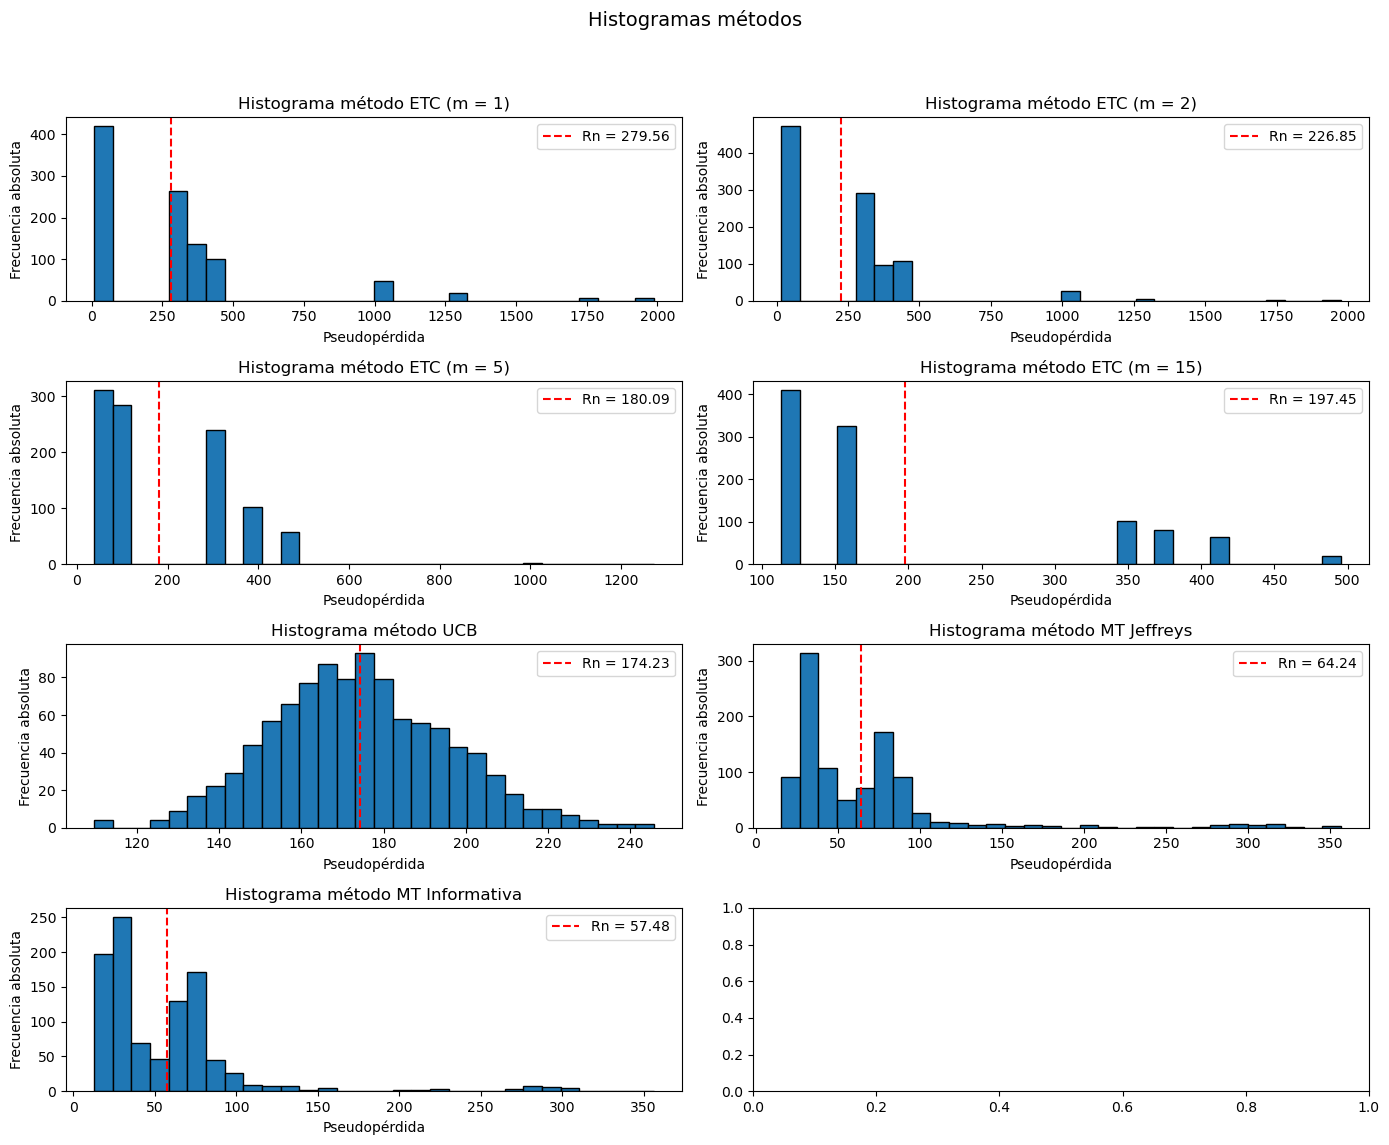

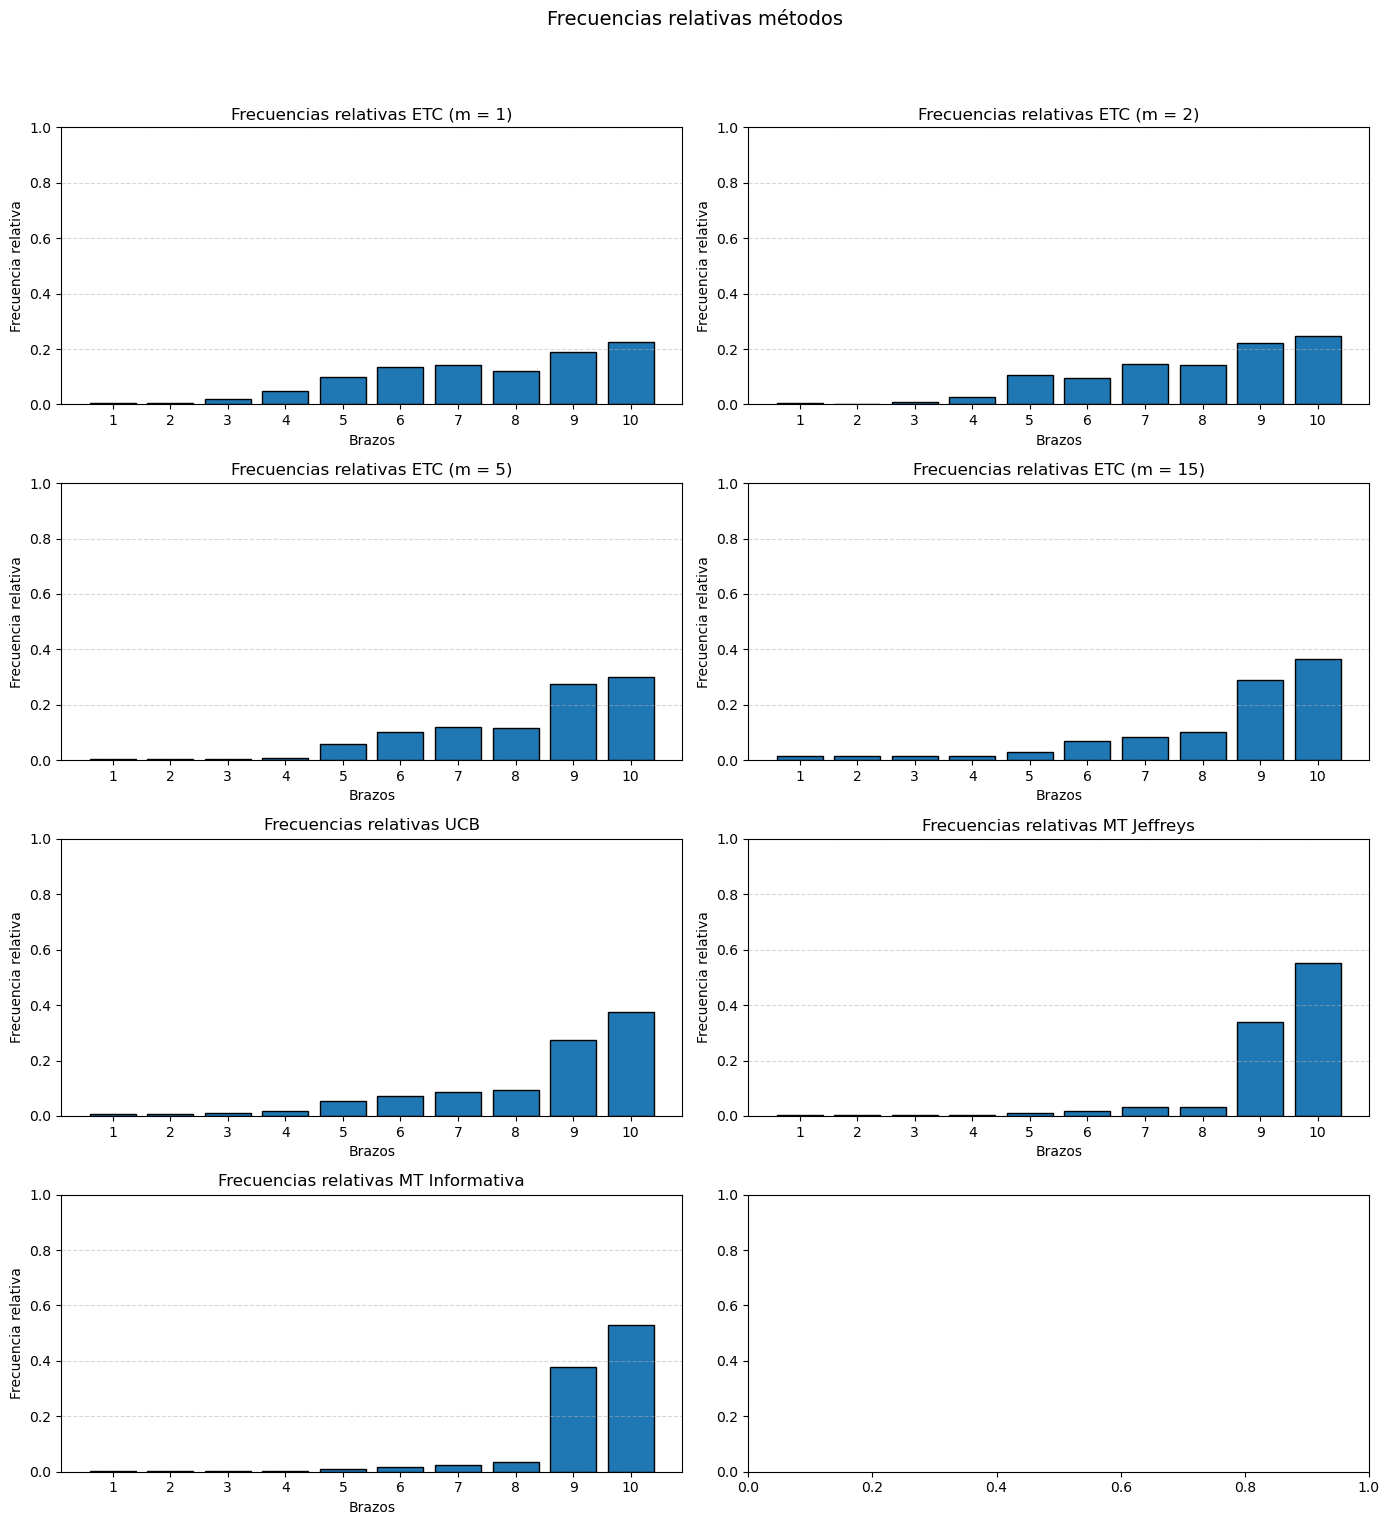

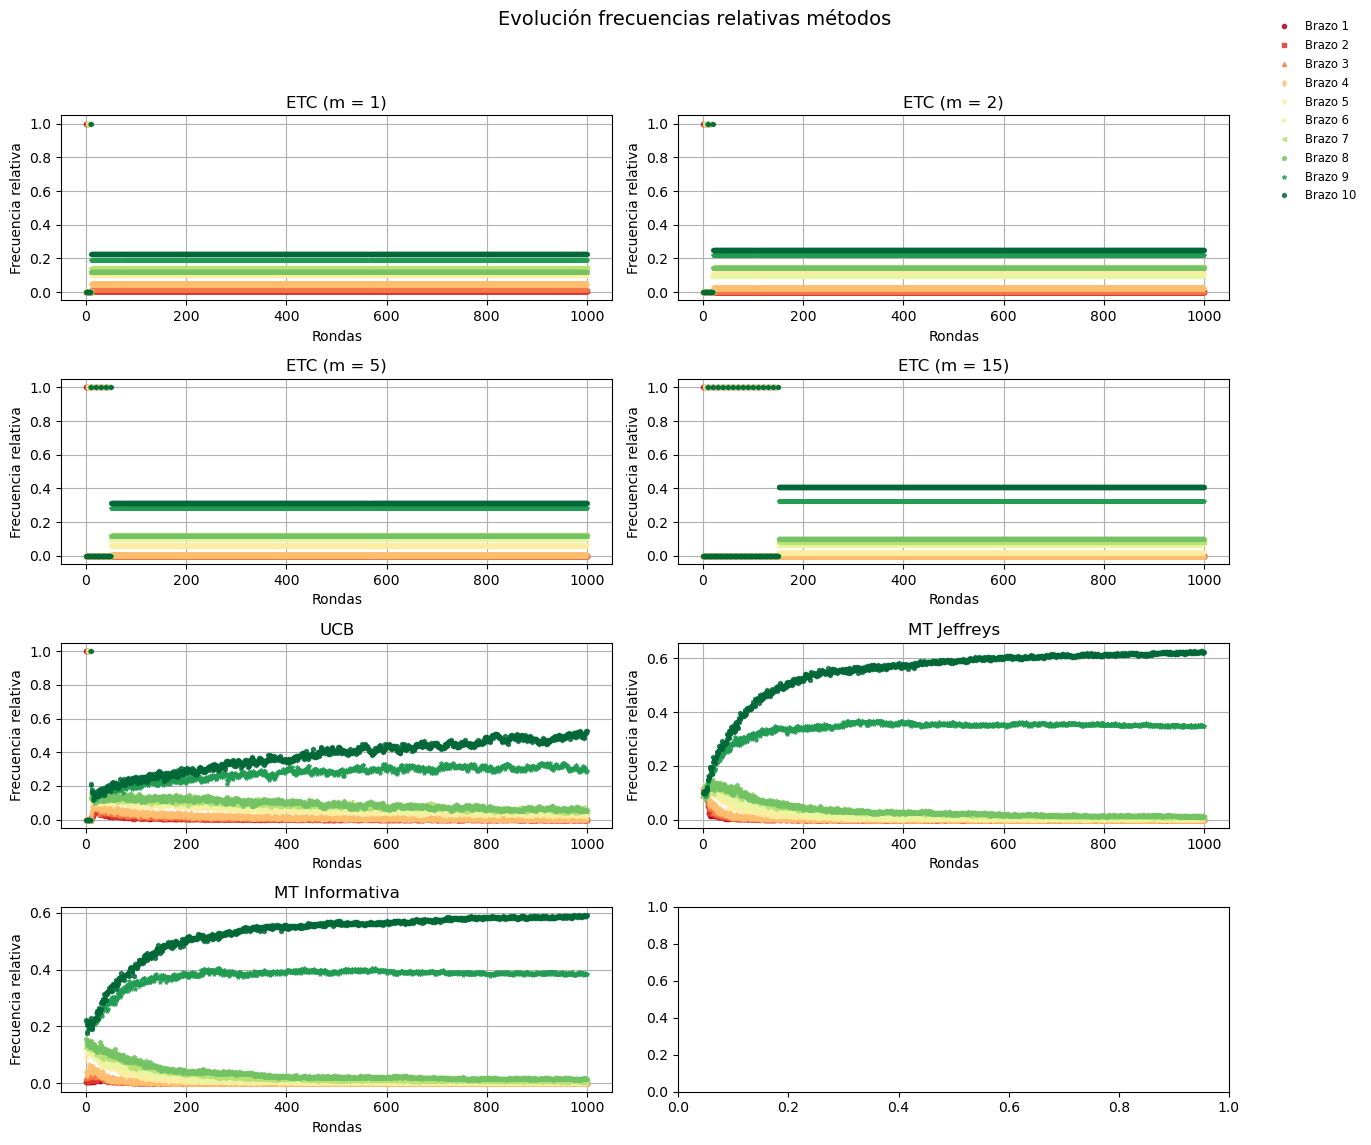

In [26]:
n = 1000 #horizonte
simula = 1000 #numero de simulaciones
K = 10 #brazos

valoresm = [1,2,5,15]
pseudoregret_ETC_valoresM = [[] for _ in range(len(valoresm))] #acumulador de pseudoregret para 4 valores de m
frecuencias_ETC = np.zeros((len(valoresm),K)) #lista acumuladora de las frecuencias acción 1,2,3,4
acumbrazos_ETC = [np.zeros((n,K)),np.zeros((n,K)),np.zeros((n,K)),np.zeros((n,K))] #acumulador de brazos jugados por rondas para 4 valores de m

pseudoregret_UCB = [] #acumulador de pseudoregret UCB
frecuencias_UCB = np.zeros(K) #frecuencia de cada accion UCB
acumbrazos_UCB = np.zeros((n,K)) #acumulador de brazos jugados por rondas UCB

pseudoregret_NoInfo_Jeffry = [] #acumulador de pseudoregret NoInfo Jeffry
frecuencias_NoInfo_Jeffry = np.zeros(K) #frecuencia de cada accion NoInfo Jeffry
acumbrazos_NoInfo_Jeffry = np.zeros((n,K)) #acumulador de brazos jugados por rondas NoInfo Jeffry

pseudoregret_NoInfo_Uniforme = [] #acumulador de pseudoregret NoInfo Uniforme
frecuencias_NoInfo_Uniforme = np.zeros(K) #frecuencia de cada accion NoInfo Uniforme
acumbrazos_NoInfo_Uniforme = np.zeros((n,K)) #acumulador de brazos jugados por rondas NoInfo Uniforme

pseudoregret_Info = []
frecuencias_Info = np.zeros(K)
acumbrazos_Info = np.zeros((n,K))


#Simulacion ETC
for m in tqdm(valoresm):
    for _ in range(simula):
        bandido = NormalBandit([1, 1.2, 1.7, 2, 2.55, 2.65, 2.7, 2.72, 2.95, 3])  # Reset the bandit for each simulation
        brazosjugados = ETCrondas(n, m)
        pseudoregret_ETC_valoresM[valoresm.index(m)].append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_ETC[valoresm.index(m)][k] += bandido.frecuency()[k]
        for t in range(n):
            acumbrazos_ETC[valoresm.index(m)][t][brazosjugados[t]] += 1
#Simulacion UCB
for _ in tqdm(range(simula)):
    bandido = NormalBandit([1, 1.2, 1.7, 2, 2.55, 2.65, 2.7, 2.72, 2.95, 3])  # Reset the bandit for each simulation
    brazosjugados = UCBrondas(n,1/(n**2))
    pseudoregret_UCB.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_UCB[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_UCB[t][brazosjugados[t]] += 1
#Simulacion NoInfo Jeffry
for _ in tqdm(range(simula)):
    bandido = NormalBandit([1, 1.2, 1.7, 2, 2.55, 2.65, 2.7, 2.72, 2.95, 3])  # Reset the bandit for each simulation
    brazosjugados = BayesNormalNoInfo(n,[1,1,1,1,1,1,1,1,1,1]) # beta(0.5,0.5) es la dist a priori para cada brazo
    pseudoregret_NoInfo_Jeffry.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_NoInfo_Jeffry[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_NoInfo_Jeffry[t][brazosjugados[t]] += 1
# Simulacion NoInfo Uniforme 
'''for _ in tqdm(range(simula)):
    bandido = NormalBandit([1, 1.2, 1.7, 2, 2.55, 2.65, 2.7, 2.72, 2.95, 3])  # Reset the bandit for each simulation
    brazosjugados = BayesBernoulli(n, [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la dist a priori para cada brazo
    pseudoregret_NoInfo_Uniforme.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_NoInfo_Uniforme[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_NoInfo_Uniforme[t][brazosjugados[t]] += 1'''
# Simulacion Info
for _ in tqdm(range(simula)):
    bandido =  NormalBandit([1, 1.2, 1.7, 2, 2.55, 2.65, 2.7, 2.72, 2.95, 3])   # Reset the bandit for each simulation
    brazosjugados =BayesNormalInfo(n,[1, 1, 1.2, 1, 1.7, 1, 2, 1, 2.55, 1, 2.65, 1, 2.7, 1, 2.72, 1, 2.95, 1, 3, 1] ,[1,1,1,1,1,1,1,1,1,1]) 
    pseudoregret_Info.append(bandido.pseudoregret())
    for k in range(K):
        frecuencias_Info[k] += bandido.frecuency()[k]
    for t in range(n):
        acumbrazos_Info[t][brazosjugados[t]] += 1


# GRAFICAS PSEUDOREGRETS
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()
for i, m in enumerate(valoresm):
    axs[i].hist(pseudoregret_ETC_valoresM[i], bins=30, edgecolor='black')
    ValorRegret_ETCrondas = np.mean(pseudoregret_ETC_valoresM[i])
    axs[i].axvline(ValorRegret_ETCrondas, color='red', linestyle='dashed', linewidth=1.5, label=f"Rn = {ValorRegret_ETCrondas:.2f}")
    axs[i].set_title(f'Histograma método ETC (m = {m})')
    axs[i].set_xlabel('Pseudopérdida')
    axs[i].set_ylabel('Frecuencia absoluta')
    axs[i].legend()


axs[4].hist(pseudoregret_UCB, bins=30, edgecolor='black')
ValorRegret_UCB = np.mean(pseudoregret_UCB)
axs[4].axvline(ValorRegret_UCB, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_UCB:.2f}")
axs[4].set_title("Histograma método UCB")
axs[4].set_xlabel('Pseudopérdida')
axs[4].set_ylabel("Frecuencia absoluta")
axs[4].legend()

axs[5].hist(pseudoregret_NoInfo_Jeffry, bins=30, edgecolor='black')
ValorRegret_NoInfo_Jeffry = np.mean(pseudoregret_NoInfo_Jeffry)
axs[5].axvline(ValorRegret_NoInfo_Jeffry, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_NoInfo_Jeffry:.2f}")
axs[5].set_title("Histograma método MT Jeffreys")
axs[5].set_xlabel('Pseudopérdida')
axs[5].set_ylabel("Frecuencia absoluta")
axs[5].legend()

axs[6].hist(pseudoregret_Info, bins=30, edgecolor='black')
ValorRegret_Info = np.mean(pseudoregret_Info)
axs[6].axvline(ValorRegret_Info, color='red', linestyle='dashed', linewidth=1.5,
               label=f"Rn = {ValorRegret_Info:.2f}")
axs[6].set_title("Histograma método MT Informativa")
axs[6].set_xlabel('Pseudopérdida')
axs[6].set_ylabel("Frecuencia absoluta")
axs[6].legend()

plt.suptitle("Histogramas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título principal
plt.show()

#GRAFICAS FRECUENCIAS
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
axs = axs.flatten()
labels = [f"{i+1}" for i in range(K)]

for i, m in enumerate(valoresm):
    # calcula las frecuencias relativas de los 10 brazos para el valor m
    rel_freq = np.array(frecuencias_ETC[i]) / (simula*n)

    # dibuja un bar chart en lugar de un plot lineal
    axs[i].bar(range(K), rel_freq, tick_label=labels, edgecolor='black')
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel("Brazos")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"Frecuencias relativas ETC (m = {m})")
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)

rel_freq_UCB = np.array(frecuencias_UCB) / (simula*n)
axs[4].bar(range(K), rel_freq_UCB,
           tick_label=labels,
           edgecolor='black')
axs[4].set_ylim(0, 1)
axs[4].set_xlabel("Brazos")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("Frecuencias relativas UCB")

rel_freq_noinfo = np.array(frecuencias_NoInfo_Jeffry) / (simula*n)
axs[5].bar(range(K), rel_freq_noinfo,
           tick_label=labels,
           edgecolor='black')
axs[5].set_ylim(0, 1)
axs[5].set_xlabel("Brazos")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("Frecuencias relativas MT Jeffreys")
axs[5].grid(axis='y', linestyle='--', alpha=0.5)

rel_freq_info = np.array(frecuencias_Info) /(simula*n)
axs[6].bar(range(K), rel_freq_info,
           tick_label=labels,
           edgecolor='black')
axs[6].set_ylim(0, 1)
axs[6].set_xlabel("Brazos")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("Frecuencias relativas MT Informativa")
axs[6].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Deja espacio para el título principal
plt.show()


#GRAFICAS FRECUENCIAS BRAZOS/RONDAS
cmap = plt.get_cmap('RdYlGn')
colores = [cmap(i) for i in np.linspace(0, 1, 10)]
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()
x = np.arange(1, n+1)  # Rondas

# Paleta y marcadores
cmap = plt.get_cmap('RdYlGn')
colores = [cmap(i) for i in np.linspace(0, 1, 10)]
marcadores = ['o', 's', '^', 'd', 'v', '>', '<', 'p', '*', 'h']

# Para coleccionar un único handle/label por brazo
handles = []
labels  = [f'Brazo {k+1}' for k in range(10)]

# 1) ETC
for i, m in enumerate(valoresm):
    for k in range(10):
        h, = axs[i].plot(
            x, acumbrazos_ETC[i][:, k] / simula,
            marker=marcadores[k],
            linestyle='None',
            markersize=3,
            alpha=0.8,
            color=colores[k]
        )
        # Sólo agregamos el handle de cada brazo la primera vez
        if i == 0:
            handles.append(h)

    axs[i].set_xlabel("Rondas")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"ETC (m = {m})")
    axs[i].grid(True)
    # NO axs[i].legend()

# 2) UCB
for k in range(10):
    h, = axs[4].plot(
        x, acumbrazos_UCB[:, k] / simula,
        marker=marcadores[k],
        linestyle='None',
        markersize=3,
        alpha=0.8,
        color=colores[k]
    )
# NO axs[4].legend()
axs[4].set_xlabel("Rondas")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("UCB")
axs[4].grid(True)

# 3) MT Jeffreys
for k in range(10):
    axs[5].plot(
        x, acumbrazos_NoInfo_Jeffry[:, k] / simula,
        marker=marcadores[k], linestyle='None',
        markersize=3, alpha=0.8, color=colores[k]
    )
axs[5].set_xlabel("Rondas")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("MT Jeffreys")
axs[5].grid(True)

# 5) MT Informativa
for k in range(10):
    axs[6].plot(
        x, acumbrazos_Info[:, k] / simula,
        marker=marcadores[k], linestyle='None',
        markersize=3, alpha=0.8, color=colores[k]
    )
axs[6].set_xlabel("Rondas")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("MT Informativa")
axs[6].grid(True)

# Suyptitle y ajuste de layout
plt.suptitle("Evolución frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])  # Deja espacio a la derecha

# Leyenda global en esquina superior derecha
fig.legend(handles, labels,
           loc='upper right',
           bbox_to_anchor=(0.98, 0.98),
           fontsize='small',
           ncol=1,
           frameon=False)

plt.show()



### Variacion de n

100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


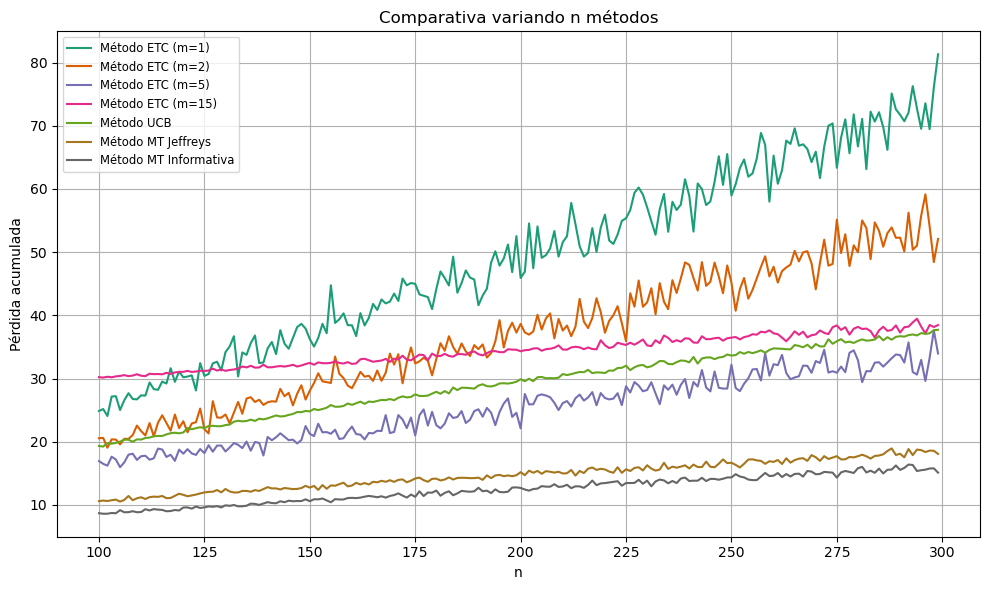

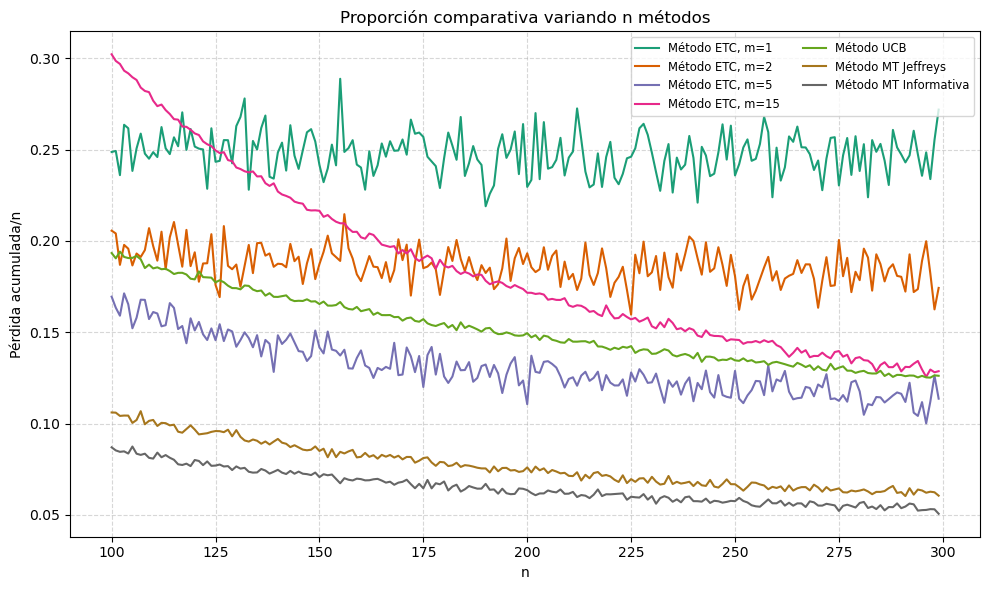

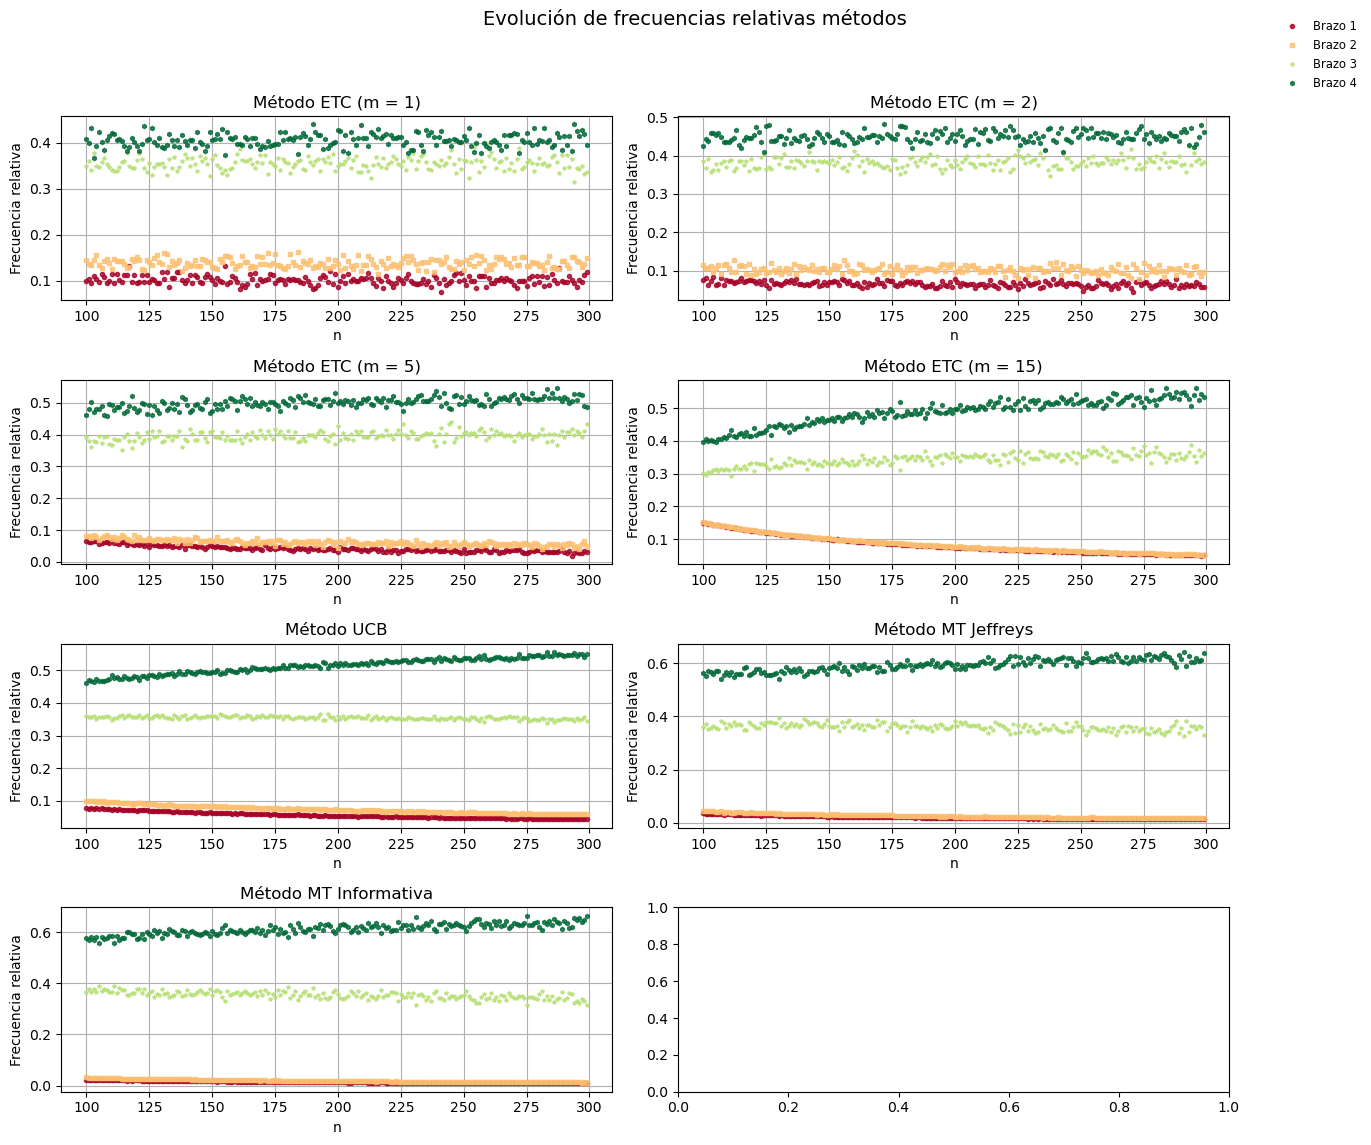

In [27]:
nvalores = range(100,300) #horizonte
simula = 1000 #numero de simulaciones
K = 4 #brazos

valoresm = [1,2,5,15]
regret_ETC_valoresM = [[] for _ in range(len(valoresm))] #acumulador de regret para 4 valores de m
frecuenciasParaCadaN_ETC = [[[] for _ in range(K)] for _ in range(len(valoresm))]

regret_UCB = [] #acumulador de pseudoregret UCB
frecuenciasParaCadaN_UCB = [[] for _ in range(K)] #frecuencia de cada accion UCB

regret_NoInfo_Jeffry = [] #acumulador de pseudoregret NoInfo Jeffry
frecuenciasParaCadaN_NoInfo_Jeffry = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Jeffry

regret_NoInfo_Uniforme = [] #acumulador de pseudoregret NoInfo Uniforme
frecuenciasParaCadaN_NoInfo_Uniforme = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Uniforme

regret_Info = []
frecuenciasParaCadaN_Info = [[] for _ in range(K)]


#Simulacion ETC
for n in tqdm(nvalores):
    pseudoregret_ETC_valoresM  = [[] for _ in range(len(valoresm))] # Reset accumulators for each n
    for m in valoresm:
        frecuencias_ETC = [[] for _ in range(K)] # Frecuencias de cada brazo para cada valor de K
        for _ in range(simula):
            bandido = NormalBandit([2, 2.2, 2.9, 3])  # Reset the bandit for each simulation
            brazosjugados = ETCrondas(n, m)
            pseudoregret_ETC_valoresM[valoresm.index(m)].append(bandido.pseudoregret())
            for k in range(K):
                frecuencias_ETC[k].append(bandido.frecuency()[k])
        [frecuenciasParaCadaN_ETC[valoresm.index(m)][i].append(np.mean(frecuencias_ETC[i])/n) for i in range(K)]
    [regret_ETC_valoresM[i].append(np.mean(pseudoregret_ETC_valoresM[i])) for i in range(len(valoresm))]
#Simulacion UCB
for n in tqdm(nvalores):
    pseudoregret_UCB = []  # Reset accumulators for each n
    frecuencias_UCB = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([2, 2.2, 2.9, 3])  # Reset the bandit for each simulation
        brazosjugados = UCBrondas(n,1/(n**2))
        pseudoregret_UCB.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_UCB[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_UCB[i].append(np.mean(frecuencias_UCB[i])/n) for i in range(K)]
    regret_UCB.append(np.mean(pseudoregret_UCB))
#Simulacion NoInfo Jeffry
for n in tqdm(nvalores):
    pseudoregret_NoInfo_Jeffry = []  # Reset accumulators for each n
    frecuencias_NoInfo_Jeffry = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([2, 2.2, 2.9, 3])  # Reset the bandit for each simulation
        brazosjugados = BayesNormalNoInfo(n,[1,1,1,1])
        pseudoregret_NoInfo_Jeffry.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Jeffry[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_NoInfo_Jeffry[i].append(np.mean(frecuencias_NoInfo_Jeffry[i])/n) for i in range(K)]
    regret_NoInfo_Jeffry.append(np.mean(pseudoregret_NoInfo_Jeffry))
# Simulacion NoInfo Uniforme
'''for n in tqdm(nvalores):
    pseudoregret_NoInfo_Uniforme = []  # Reset accumulators for each n
    frecuencias_NoInfo_Uniforme = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([2, 2.2, 2.95, 3])  # Reset the bandit for each simulation
        brazosjugados = BayesBernoulli(n, [1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la dist a priori para cada brazo
        pseudoregret_NoInfo_Uniforme.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Uniforme[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_NoInfo_Uniforme[i].append(np.mean(frecuencias_NoInfo_Uniforme[i])/n) for i in range(K)]
    regret_NoInfo_Uniforme.append(np.mean(pseudoregret_NoInfo_Uniforme))'''
# Simulacion Info
for n in tqdm(nvalores):
    pseudoregret_Info = []  # Reset accumulators for each n
    frecuencias_Info = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([2, 2.2, 2.9, 3])
        brazosjugados = BayesNormalInfo(n,[2, 1, 2.2,  1, 2.9,  1, 3, 1],[1,1,1,1])
        pseudoregret_Info.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_Info[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaN_Info[i].append(np.mean(frecuencias_Info[i])/n) for i in range(K)]
    regret_Info.append(np.mean(pseudoregret_Info))

# GRAFICAS PSEUDOREGRETS
plt.figure(figsize=(10,6))
etiquetas = [
    *[f'Método ETC (m={m})' for m in valoresm],
    'Método UCB',
    'Método MT Jeffreys',
    'Método MT Informativa'
]
series = regret_ETC_valoresM + [regret_UCB, regret_NoInfo_Jeffry, regret_Info]
colores = ['#1b9e77','#d95f02','#7570b3','#e7298a',
           '#66a61e','#a6761d','#666666']  # uno menos

for color, label, y in zip(colores, etiquetas, series):
    plt.plot(nvalores, y, label=label, color=color, linewidth=1.5)

plt.xlabel('n')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando n métodos')
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()


#PERDIDA ACUMULADA/N
n_array = np.array(list(nvalores))
paleta = colores

series = (
    [np.array(regret_ETC_valoresM[i]) / n_array for i in range(len(valoresm))] +
    [np.array(regret_UCB)       / n_array,
     np.array(regret_NoInfo_Jeffry)   / n_array,
     np.array(regret_Info)      / n_array]
)

labels = (
    [f'Método ETC, m={m}' for m in valoresm] +
    ['Método UCB',
     'Método MT Jeffreys',
     'Método MT Informativa']
)

plt.figure(figsize=(10,6))
for color, y, label in zip(paleta, series, labels):
    plt.plot(n_array, y,
             color=color,
             linewidth=1.5,
             label=label)

plt.xlabel('n')
plt.ylabel('Pérdida acumulada/n')
plt.title('Proporción comparativa variando n métodos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


#GRAFICAS FRECUENCIAS BRAZOS por RONDAS
# Parámetros
n_array = np.array(list(nvalores))
valoresm = valoresm  # tu lista de m
sim = simula         # tu variable de simulaciones

# Paleta para 4 brazos evitando rojo, amarillo y verde
cmap = plt.get_cmap('RdYlGn')
colors_4 = [cmap(i) for i in np.linspace(0, 1, 4)]
markers_4 = ['o', 's','*', 'h']
labels_4 = [f'Brazo {k+1}' for k in range(4)]

fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()

# Recolectar handles para la leyenda global
handles = []

# 1) ETC
for i, m in enumerate(valoresm):
    for k in range(4):
        h, = axs[i].plot(
            n_array,
            frecuenciasParaCadaN_ETC[i][k],
            marker=markers_4[k],
            linestyle='None',
            markersize=3,
            linewidth=1,
            alpha=0.8,
            color=colors_4[k]
        )
        # Guardar un handle de cada brazo solo la primera vez
        if i == 0:
            handles.append(h)
    axs[i].set_xlabel("n")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"Método ETC (m = {m})")
    axs[i].grid(True)
    # No axs[i].legend()

# 2) UCB
for k in range(4):
    h, = axs[4].plot(
        n_array,
        frecuenciasParaCadaN_UCB[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[4].set_xlabel("n")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("Método UCB")
axs[4].grid(True)

# 3) MT Jeffreys
for k in range(4):
    axs[5].plot(
        n_array,
        frecuenciasParaCadaN_NoInfo_Jeffry[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[5].set_xlabel("n")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("Método MT Jeffreys")
axs[5].grid(True)

# 5) MT Informativa
for k in range(4):
    axs[6].plot(
        n_array,
        frecuenciasParaCadaN_Info[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[6].set_xlabel("n")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("Método MT Informativa")
axs[6].grid(True)

# Ajustes generales
plt.suptitle("Evolución de frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])   # reservar espacio a la derecha

# Leyenda global en esquina superior derecha
fig.legend(handles, labels_4,
           loc='upper right',
           bbox_to_anchor=(0.98, 0.98),
           fontsize='small',
           ncol=1,
           frameon=False)

plt.show()


### Variacion de $\Delta$

100%|██████████| 100/100 [09:35<00:00,  5.75s/it]


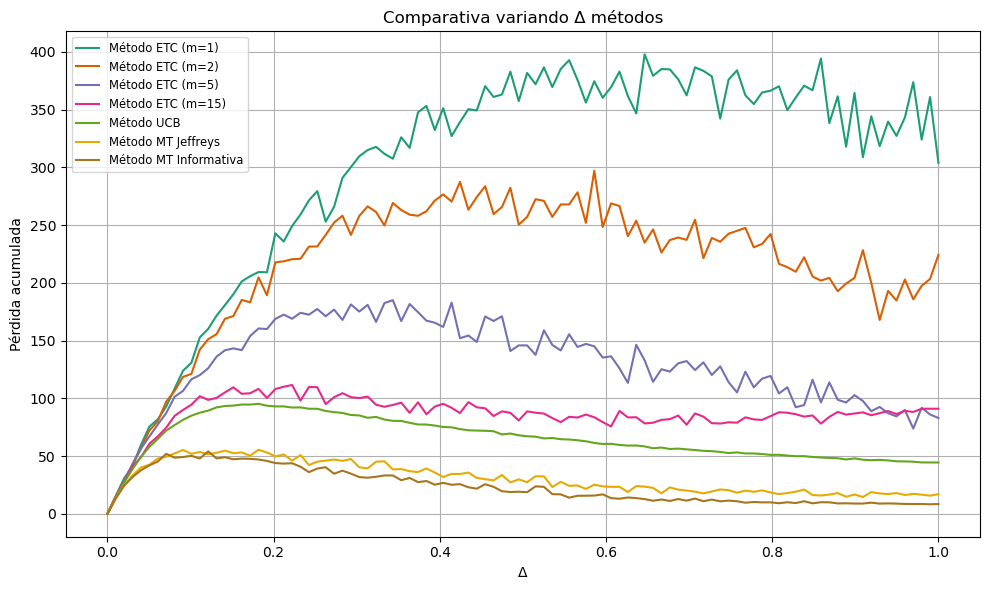

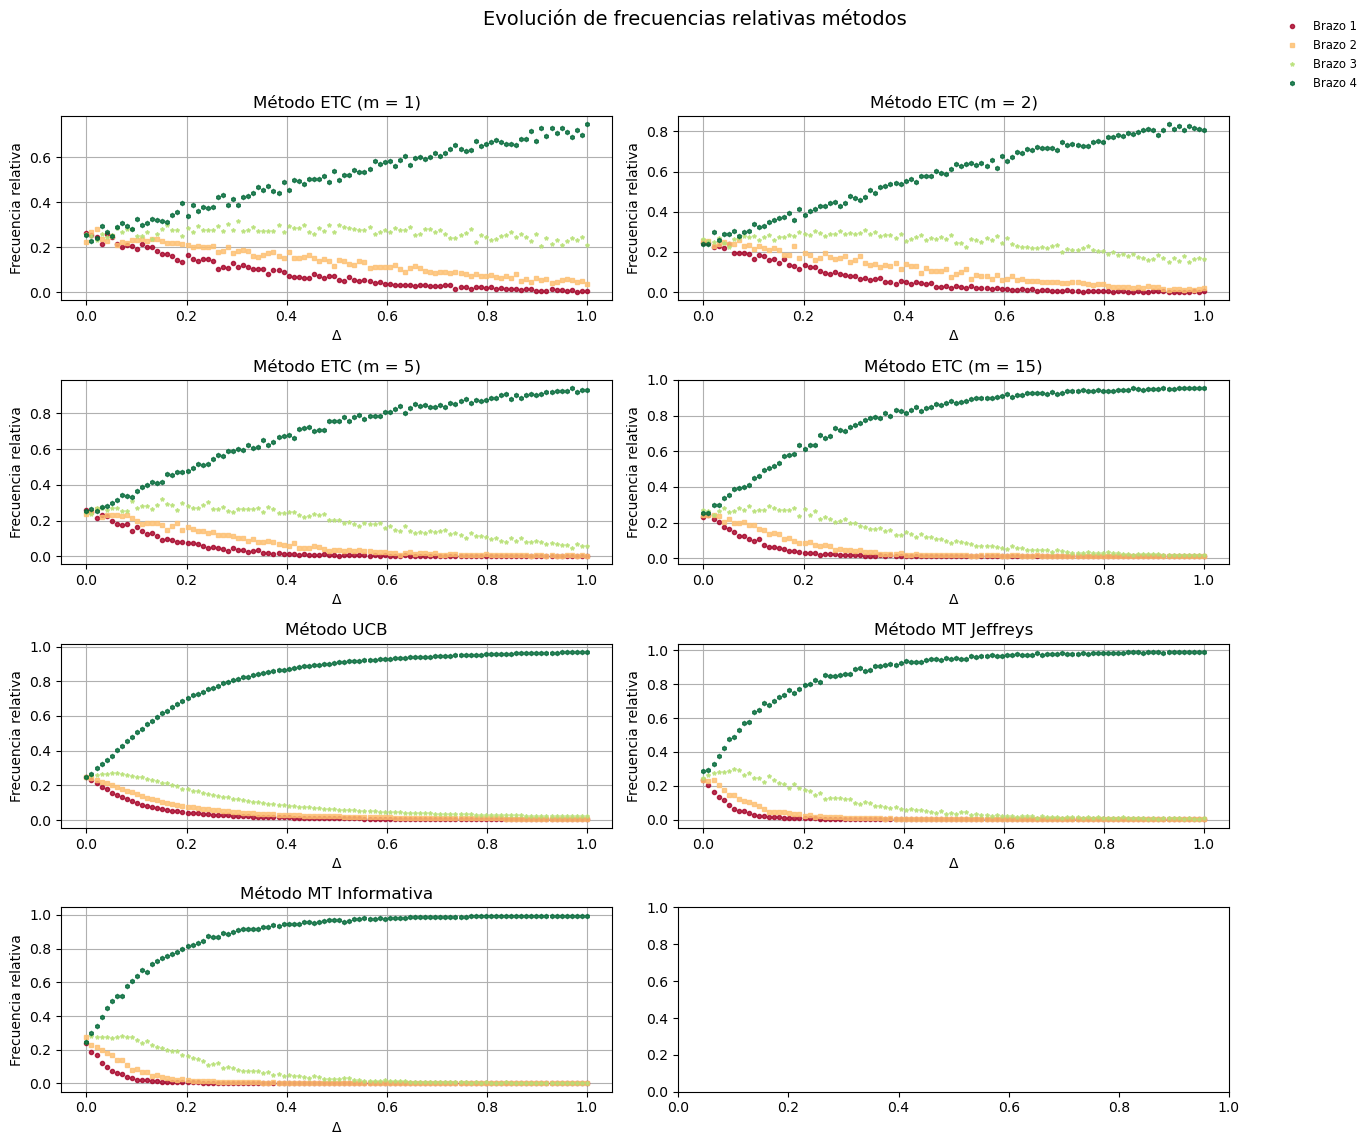

In [28]:
n = 1000 #horizonte
simula = 1000 #numero de simulaciones
K = 4 #brazos
Dvalores = np.linspace(0,1,100)

valoresm = [1,2,5,15]
regret_ETC_valoresM = [[] for _ in range(len(valoresm))] #acumulador de regret para 4 valores de m
frecuenciasParaCadaDelta_ETC = [[[] for _ in range(K)] for _ in range(len(valoresm))]

regret_UCB = [] #acumulador de pseudoregret UCB
frecuenciasParaCadaDelta_UCB = [[] for _ in range(K)] #frecuencia de cada accion UCB

regret_NoInfo_Jeffry = [] #acumulador de pseudoregret NoInfo Jeffry
frecuenciasParaCadaDelta_NoInfo_Jeffry = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Jeffry

regret_NoInfo_Uniforme = [] #acumulador de pseudoregret NoInfo Uniforme
frecuenciasParaCadaDelta_NoInfo_Uniforme = [[] for _ in range(K)] #frecuencia de cada accion NoInfo Uniforme

regret_Info = []
frecuenciasParaCadaDelta_Info = [[] for _ in range(K)]


#Simulacion ETC
for Delta in tqdm(Dvalores):
    pseudoregret_ETC_valoresM  = [[] for _ in range(len(valoresm))] # Reset accumulators for each n
    for m in valoresm:
        frecuencias_ETC = [[] for _ in range(K)] # Frecuencias de cada brazo para cada valor de K
        for _ in range(simula):
            bandido = NormalBandit([3-3*Delta, 3-2*Delta, 3-Delta, 3])  # Reset the bandit for each simulation
            brazosjugados = ETCrondas(n, m)
            pseudoregret_ETC_valoresM[valoresm.index(m)].append(bandido.pseudoregret())
            for k in range(K):
                frecuencias_ETC[k].append(bandido.frecuency()[k])
        [frecuenciasParaCadaDelta_ETC[valoresm.index(m)][i].append(np.mean(frecuencias_ETC[i])/n) for i in range(K)]
    [regret_ETC_valoresM[i].append(np.mean(pseudoregret_ETC_valoresM[i])) for i in range(len(valoresm))]
#Simulacion UCB
for Delta in tqdm(Dvalores):
    pseudoregret_UCB = []  # Reset accumulators for each n
    frecuencias_UCB = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([3-3*Delta, 3-2*Delta, 3-Delta, 3])  # Reset the bandit for each simulation
        brazosjugados = UCBrondas(n,1/(n**2))
        pseudoregret_UCB.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_UCB[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_UCB[i].append(np.mean(frecuencias_UCB[i])/n) for i in range(K)]
    regret_UCB.append(np.mean(pseudoregret_UCB))
#Simulacion NoInfo Jeffry
for Delta in tqdm(Dvalores):
    pseudoregret_NoInfo_Jeffry = []  # Reset accumulators for each n
    frecuencias_NoInfo_Jeffry = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([3-3*Delta, 3-2*Delta, 3-Delta, 3])  # Reset the bandit for each simulation
        brazosjugados = BayesNormalNoInfo(n,[1,1,1,1])
        pseudoregret_NoInfo_Jeffry.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Jeffry[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_NoInfo_Jeffry[i].append(np.mean(frecuencias_NoInfo_Jeffry[i])/n) for i in range(K)]
    regret_NoInfo_Jeffry.append(np.mean(pseudoregret_NoInfo_Jeffry))
# Simulacion NoInfo Uniforme
'''for Delta in tqdm(Dvalores):
    pseudoregret_NoInfo_Uniforme = []  # Reset accumulators for each n
    frecuencias_NoInfo_Uniforme = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([3-3*Delta, 3-2*Delta, 3-Delta, 3])  # Reset the bandit for each simulation
        brazosjugados = BayesBernoulli(n, [1,1,1,1,1,1,1,1],bandido) # beta(1,1) es la dist a priori para cada brazo
        pseudoregret_NoInfo_Uniforme.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_NoInfo_Uniforme[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_NoInfo_Uniforme[i].append(np.mean(frecuencias_NoInfo_Uniforme[i])/n) for i in range(K)]
    regret_NoInfo_Uniforme.append(np.mean(pseudoregret_NoInfo_Uniforme))'''
# Simulacion Info
for Delta in tqdm(Dvalores):
    pseudoregret_Info = []  # Reset accumulators for each n
    frecuencias_Info = [[] for _ in range(K)]
    for _ in range(simula):
        bandido = NormalBandit([3-3*Delta, 3-2*Delta, 3-Delta, 3])
        brazosjugados = BayesNormalInfo(n, [3-3*Delta, 1, 3-2*Delta, 1, 3-Delta, 1, 3, 1] , [1,1,1,1]) 
        pseudoregret_Info.append(bandido.pseudoregret())
        for k in range(K):
            frecuencias_Info[k].append(bandido.frecuency()[k])
    [frecuenciasParaCadaDelta_Info[i].append(np.mean(frecuencias_Info[i])/n) for i in range(K)]
    regret_Info.append(np.mean(pseudoregret_Info))





# GRAFICAS EVOLCUION PERDIDA ACUMULADA
plt.figure(figsize=(10,6))
etiquetas = [
    *[f'Método ETC (m={m})' for m in valoresm],
    'Método UCB',
    'Método MT Jeffreys',
    'Método MT Informativa'
]
series = regret_ETC_valoresM + [regret_UCB, regret_NoInfo_Jeffry, regret_Info]
colores = ['#1b9e77','#d95f02','#7570b3','#e7298a',
 '#66a61e','#e6ab02','#a6761d','#666666']

for color, label, y in zip(colores, etiquetas, series):
    plt.plot(Dvalores, y, label=label, color=color, linewidth=1.5)

plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando Δ métodos')
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

#GRAFICAS FRECUENCIAS BRAZOS por RONDAS
# Parámetros
D_array = np.array(list(Dvalores))
valoresm = valoresm  # tu lista de m
sim = simula         # tu variable de simulaciones

# Paleta para 4 brazos evitando rojo, amarillo y verde
cmap = plt.get_cmap('RdYlGn')
colors_4 = [cmap(i) for i in np.linspace(0, 1, 4)]
markers_4 = ['o', 's','*', 'h']
labels_4 = [f'Brazo {k+1}' for k in range(4)]

fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()

# Recolectar handles para la leyenda global
handles = []

# 1) ETC
for i, m in enumerate(valoresm):
    for k in range(4):
        h, = axs[i].plot(
            D_array,
            frecuenciasParaCadaDelta_ETC[i][k],
            marker=markers_4[k],
            linestyle='None',
            markersize=3,
            linewidth=1,
            alpha=0.8,
            color=colors_4[k]
        )
        # Guardar un handle de cada brazo solo la primera vez
        if i == 0:
            handles.append(h)
    axs[i].set_xlabel("Δ")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"Método ETC (m = {m})")
    axs[i].grid(True)
    # No axs[i].legend()

# 2) UCB
for k in range(4):
    h, = axs[4].plot(
        D_array,
        frecuenciasParaCadaDelta_UCB[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[4].set_xlabel("Δ")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("Método UCB")
axs[4].grid(True)

# 3) MT Jeffreys
for k in range(4):
    axs[5].plot(
        D_array,
        frecuenciasParaCadaDelta_NoInfo_Jeffry[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[5].set_xlabel("Δ")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("Método MT Jeffreys")
axs[5].grid(True)


# 5) MT Informativa
for k in range(4):
    axs[6].plot(
        D_array,
        frecuenciasParaCadaDelta_Info[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[6].set_xlabel("Δ")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("Método MT Informativa")
axs[6].grid(True)

# Ajustes generales
plt.suptitle("Evolución de frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])   # reservar espacio a la derecha

# Leyenda global en esquina superior derecha
fig.legend(handles, labels_4,
           loc='upper right',
           bbox_to_anchor=(0.98, 0.98),
           fontsize='small',
           ncol=1,
           frameon=False)

plt.show()







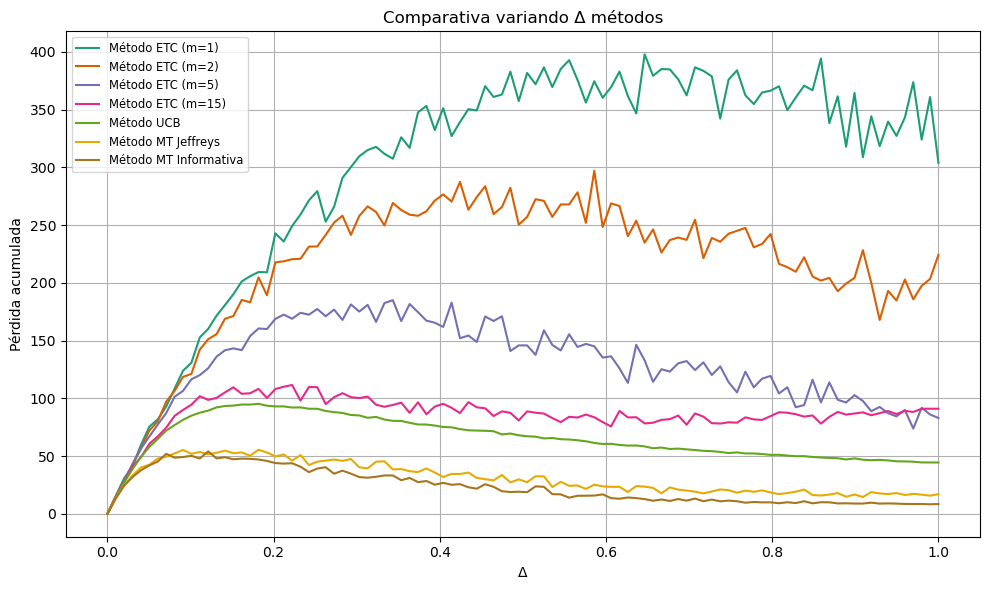

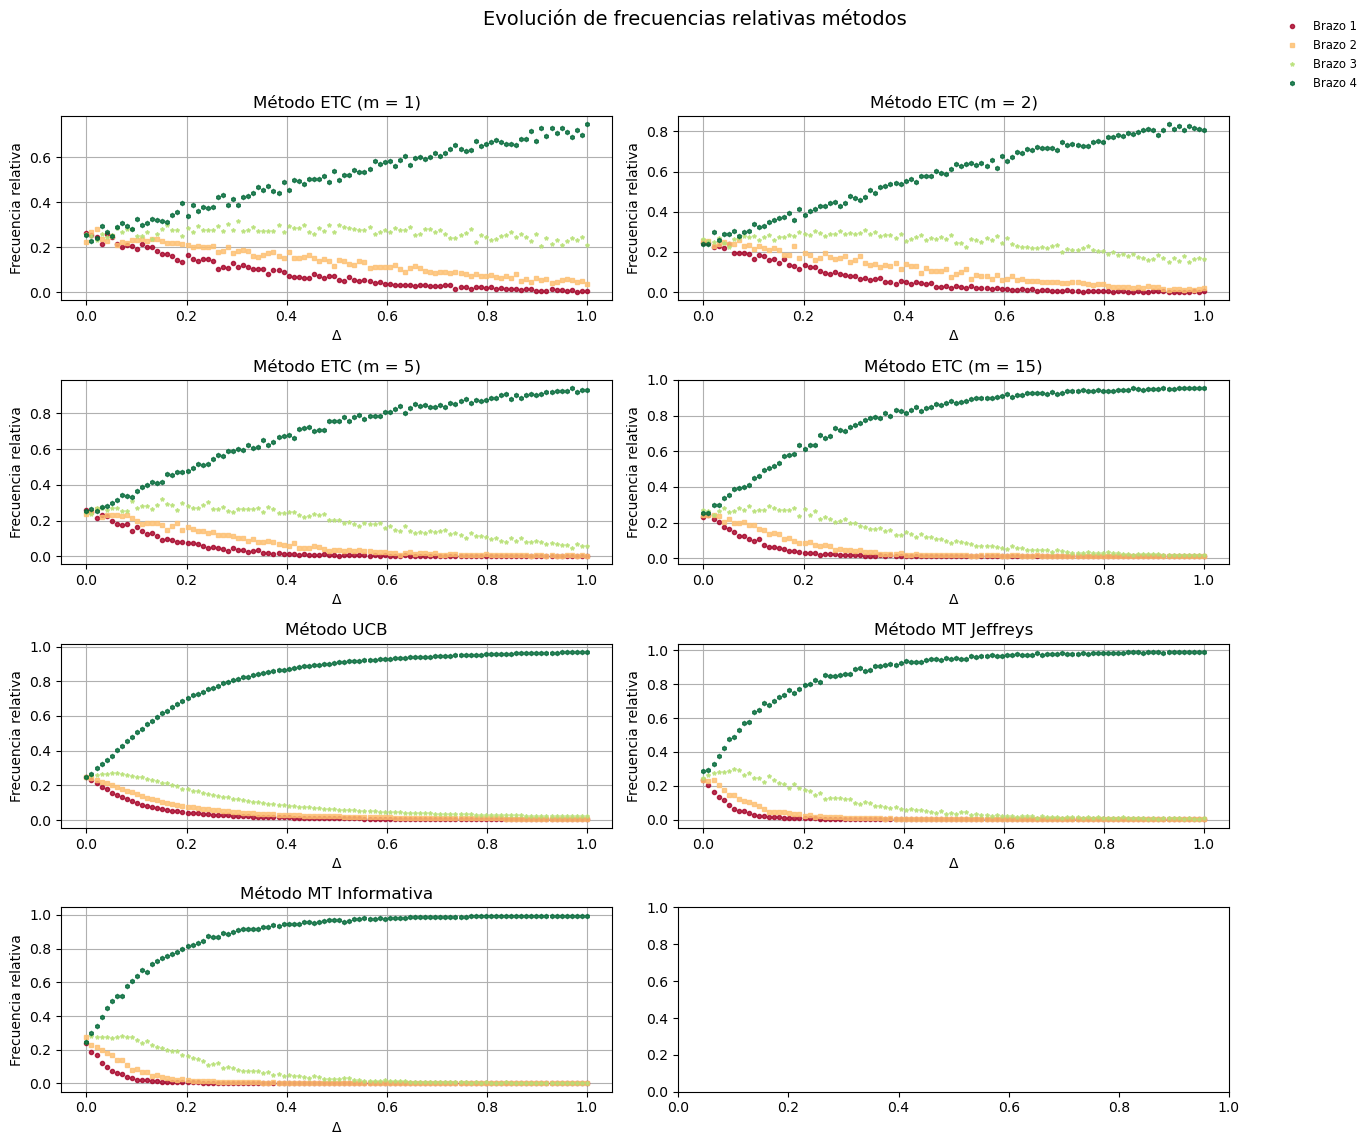

In [29]:


# GRAFICAS EVOLCUION PERDIDA ACUMULADA
plt.figure(figsize=(10,6))
etiquetas = [
    *[f'Método ETC (m={m})' for m in valoresm],
    'Método UCB',
    'Método MT Jeffreys',
    'Método MT Informativa'
]
series = regret_ETC_valoresM + [regret_UCB, regret_NoInfo_Jeffry, regret_Info]
colores = ['#1b9e77','#d95f02','#7570b3','#e7298a',
 '#66a61e','#e6ab02','#a6761d','#666666']

for color, label, y in zip(colores, etiquetas, series):
    plt.plot(Dvalores, y, label=label, color=color, linewidth=1.5)

plt.xlabel('Δ')
plt.ylabel('Pérdida acumulada')
plt.title('Comparativa variando Δ métodos')
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

#GRAFICAS FRECUENCIAS BRAZOS por RONDAS
# Parámetros
D_array = np.array(list(Dvalores))
valoresm = valoresm  # tu lista de m
sim = simula         # tu variable de simulaciones

# Paleta para 4 brazos evitando rojo, amarillo y verde
cmap = plt.get_cmap('RdYlGn')
colors_4 = [cmap(i) for i in np.linspace(0, 1, 4)]
markers_4 = ['o', 's','*', 'h']
labels_4 = [f'Brazo {k+1}' for k in range(4)]

fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()

# Recolectar handles para la leyenda global
handles = []

# 1) ETC
for i, m in enumerate(valoresm):
    for k in range(4):
        h, = axs[i].plot(
            D_array,
            frecuenciasParaCadaDelta_ETC[i][k],
            marker=markers_4[k],
            linestyle='None',
            markersize=3,
            linewidth=1,
            alpha=0.8,
            color=colors_4[k]
        )
        # Guardar un handle de cada brazo solo la primera vez
        if i == 0:
            handles.append(h)
    axs[i].set_xlabel("Δ")
    axs[i].set_ylabel("Frecuencia relativa")
    axs[i].set_title(f"Método ETC (m = {m})")
    axs[i].grid(True)
    # No axs[i].legend()

# 2) UCB
for k in range(4):
    h, = axs[4].plot(
        D_array,
        frecuenciasParaCadaDelta_UCB[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[4].set_xlabel("Δ")
axs[4].set_ylabel("Frecuencia relativa")
axs[4].set_title("Método UCB")
axs[4].grid(True)

# 3) MT Jeffreys
for k in range(4):
    axs[5].plot(
        D_array,
        frecuenciasParaCadaDelta_NoInfo_Jeffry[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[5].set_xlabel("Δ")
axs[5].set_ylabel("Frecuencia relativa")
axs[5].set_title("Método MT Jeffreys")
axs[5].grid(True)


# 5) MT Informativa
for k in range(4):
    axs[6].plot(
        D_array,
        frecuenciasParaCadaDelta_Info[k],
        marker=markers_4[k],
        linestyle='None',
        markersize=3,
        linewidth=1,
        alpha=0.8,
        color=colors_4[k]
    )
axs[6].set_xlabel("Δ")
axs[6].set_ylabel("Frecuencia relativa")
axs[6].set_title("Método MT Informativa")
axs[6].grid(True)

# Ajustes generales
plt.suptitle("Evolución de frecuencias relativas métodos", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])   # reservar espacio a la derecha

# Leyenda global en esquina superior derecha
fig.legend(handles, labels_4,
           loc='upper right',
           bbox_to_anchor=(0.98, 0.98),
           fontsize='small',
           ncol=1,
           frameon=False)

plt.show()






---





---

